# Using Word2Vec Embedding to extend unsupervised guesser POC

We can use Gensim to make a more powerful version of our unsupervised Proof-of-Concept. Let's see if we can make less of a toy version using the Google News Skip-Gram model with 300-feature embeddings (requires ~2GB).

In [1]:
import decryptoai.word2vec_loader.loader as wv_loader

limit = 200_000
print(f"Loading {limit} keys")
google_news_wv = wv_loader.load_word2vec_keyedvectors(limit=limit, debug=True)

Loading 200000 keys


In [2]:
# pre-normalize all the vectors
google_news_wv.unit_normalize_all()

# Modelling a stronger Guesser

Now that we have a bit of a grasp on how the Google News Word2Vec model is compatible with our Decrypto words from the word2vec integration notebook, let's build a stronger guesser and compare some different probability schemes.

We'll start with some strategies that simply manipulate the cosine similarity. I expect these to perform poorly for 2 reasons.

One is that the cosine similarity doesn't really correspond to something probablistic, so in a way we are using it more as a heuristic. This could backfire because it doesn't really take word context or word frequency into account.

Another more subtle reason is that the cosine similarity is symmetric. This implies that the probability of using a clue for a keyword is the same as the probability of using the keyword as a clue for the clue word if it was the keyword (that was a mouthful). We know from Baye's Theorem this isn't quite true, because it doesn't take the probabilities/frequencies of each individual word into account, nor the density of similar neighbors each word has in the vector space.

However, they should yield much better guesses than random because the embeddings store a lot of semantic information.

Importantly, let's not forget to use log probabilities/heuristics due to our design choice in Guesser Proof-Of-Concept.

In [3]:
import numpy as np

def cosine_similarity(clue_index, keyword_index):
    clue_embedding = google_news_wv[clue_index.squeeze()].transpose()
    keyword_embedding = google_news_wv[keyword_index.squeeze()]
    return np.expand_dims(keyword_embedding.dot(clue_embedding), axis=-1)

# simple heuristics

def log_square_cosine_similarity(clue_index, keyword_index):
    similarity = cosine_similarity(clue_index, keyword_index)
    return 2 * np.log(np.abs(similarity))

def log_normalized_cosine_similarity(clue_index, keyword_index):
    similarity = cosine_similarity(clue_index, keyword_index)
    normalized_similiarity = (1 + similarity) / 2
    print(np.log(normalized_similiarity))
    return np.log(normalized_similiarity)

See synthetic datamuse notebook if you don't have the csv files. We're going to use them to evaluate the heuristics.

In [4]:
import pandas
import synthetic_datamuse as sd

meaning_df = pandas.read_csv(sd.MEANING_CSV_PATH)
triggerword_df = pandas.read_csv(sd.TRIGGERWORD_CSV_PATH)

In [5]:
import numpy as np
import swifter
import numpy_guesser as nguesser

from collections import defaultdict
from dataclasses import dataclass
from functools import partial

@dataclass
class Suite:
    name: str
    clue_df: pandas.DataFrame
    correct_code_index: pandas.Series

def get_guess(strat_func, input_row):
    keyword_card = (input_row.keyword1, input_row.keyword2, input_row.keyword3, input_row.keyword4)
    clues = (input_row.clue1, input_row.clue2, input_row.clue3)
    wv_kw_card = map(wv_loader.official_keyword_to_word, keyword_card)
    random_vars = nguesser.guesser_random_variables(wv_kw_card, google_news_wv.key_to_index)
    code_log_probabilities = nguesser.log_expected_probabilities_codes(strat_func, random_vars, nguesser.np_clues(clues, google_news_wv.key_to_index))
    print(code_log_probabilities)
    code_index_guess = np.argmax(code_log_probabilities)
    return pandas.Series([code_index_guess, code_log_probabilities[code_index_guess]], index=["code_index_guess", "log_expected_prob"])

meaning_clue_df, meaning_correct_code_index = meaning_df.drop('code_index', axis=1), meaning_df['code_index']
triggerword_clue_df, triggerword_correct_code_index = triggerword_df.drop('code_index', axis=1), triggerword_df['code_index']

suites = [Suite("meaning", meaning_clue_df, meaning_correct_code_index), Suite("triggerword", triggerword_clue_df, triggerword_correct_code_index)]

strat_funcs = [log_square_cosine_similarity, log_normalized_cosine_similarity]
guesses_by_suitename_and_strat = defaultdict(dict)
for strat_func in strat_funcs:
    print(strat_func.__name__)
    get_guess_with_strat = partial(get_guess, strat_func)

    for suite in suites:
        guesses = suite.clue_df.swifter.apply(get_guess_with_strat, axis=1)
        guesses["correct"] = guesses["code_index_guess"] == suite.correct_code_index
        percent_correct = 100 * np.sum(guesses["correct"]) / len(guesses)
        print(f"percent {suite.name} clues correct: {percent_correct:.2f}%")
        guesses_by_suitename_and_strat[suite.name][strat_func] = guesses

/Users/jadenrodriguez/Projects/decrypto-ai-research/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


log_square_cosine_similarity


Pandas Apply:   0%|          | 120/36000 [00:00<00:59, 605.57it/s]

[[[ -6.48345709]
  [ -4.94646978]
  [ -3.75542951]]

 [[ -7.46862555]
  [ -1.44027388]
  [ -5.73620796]]

 [[ -3.67285442]
  [-21.95550728]
  [ -1.80470634]]

 [[ -7.76063204]
  [ -7.80311871]
  [ -3.80844545]]]
[[ -6.48345709  -4.94646978  -3.75542951]
 [ -7.46862555  -1.44027388  -5.73620796]
 [ -3.67285442 -21.95550728  -1.80470634]
 [ -7.76063204  -7.80311871  -3.80844545]]
[[ -6.48345709  -4.94646978  -3.75542951]
 [ -7.46862555  -1.44027388  -5.73620796]
 [ -3.67285442 -21.95550728  -1.80470634]
 [ -7.76063204  -7.80311871  -3.80844545]]
[ -9.7284373  -11.73217642 -34.17517233 -32.24740982 -20.02278376
 -16.09128213 -14.21980166 -16.22354078 -33.17956233 -33.23257828
 -19.02717376 -17.07645059 -14.35553217 -12.42776966  -8.86855781
  -8.92157376 -15.23140264 -17.21218109 -18.44330978 -14.51180816
 -12.95633543 -11.00561225 -33.47156882 -35.45234728]
[[[ -6.48345709]
  [ -4.94646978]
  [ -5.0955472 ]]

 [[ -7.46862555]
  [ -1.44027388]
  [ -4.66020727]]

 [[ -3.67285442]
  [-21.95

Pandas Apply:   1%|          | 253/36000 [00:00<00:55, 646.03it/s]

[[[-3.63901496]
  [-2.80384254]
  [-4.9684515 ]]

 [[-7.91033792]
  [-4.42169952]
  [-4.36892653]]

 [[-4.68960285]
  [-5.59385967]
  [-2.19299817]]

 [[-2.7791152 ]
  [-2.63087749]
  [-5.56881189]]]
[[-3.63901496 -2.80384254 -4.9684515 ]
 [-7.91033792 -4.42169952 -4.36892653]
 [-4.68960285 -5.59385967 -2.19299817]
 [-2.7791152  -2.63087749 -5.56881189]]
[[-3.63901496 -2.80384254 -4.9684515 ]
 [-7.91033792 -4.42169952 -4.36892653]
 [-4.68960285 -5.59385967 -2.19299817]
 [-2.7791152  -2.63087749 -5.56881189]]
[-10.25371265 -13.62952638 -13.60180116 -14.80168653 -10.63881898
  -8.46289062 -12.90717864 -16.28299236 -18.4726491  -19.07300949
 -15.50966692 -12.73421359 -11.86237192 -13.06225729 -14.07975388
 -14.68011427 -12.28893185 -11.68940687  -9.95188427  -7.77595592
 -12.16926622  -9.39381289 -13.34142637 -12.7419014 ]
[[[ -5.52600384]
  [ -3.63901496]
  [ -4.9684515 ]]

 [[ -1.23220396]
  [ -7.91033792]
  [ -4.36892653]]

 [[-18.37793922]
  [ -4.68960285]
  [ -2.19299817]]

 [[-10.23

Pandas Apply:   1%|          | 391/36000 [00:00<00:54, 654.86it/s]

[[[-7.17338943]
  [-7.736619  ]
  [-6.24812031]]

 [[-2.80018449]
  [-2.1833992 ]
  [-6.95355272]]

 [[-2.81628346]
  [-2.63858986]
  [-4.5279808 ]]

 [[-3.9695704 ]
  [-7.13181353]
  [-5.74364233]]]
[[-7.17338943 -7.736619   -6.24812031]
 [-2.80018449 -2.1833992  -6.95355272]
 [-2.81628346 -2.63858986 -4.5279808 ]
 [-3.9695704  -7.13181353 -5.74364233]]
[[-7.17338943 -7.736619   -6.24812031]
 [-2.80018449 -2.1833992  -6.95355272]
 [-2.81628346 -2.63858986 -4.5279808 ]
 [-3.9695704  -7.13181353 -5.74364233]]
[-13.88476944 -15.10043097 -16.76553202 -15.55562162 -21.25875568
 -18.83318377 -15.06478429 -16.28044581 -11.68689466 -11.18241668
 -16.18011832 -14.45997882 -17.50645518 -16.29654479 -11.24780297
 -10.743325   -16.1962173  -16.90164971 -18.65974212 -16.2341702
 -12.40108991 -10.6809504  -12.85628057 -13.56171298]
[[[-7.17338943]
  [-6.24812031]
  [-3.68686914]]

 [[-2.80018449]
  [-6.95355272]
  [-5.12917089]]

 [[-2.81628346]
  [-4.5279808 ]
  [-4.51823854]]

 [[-3.9695704 ]
  [

Pandas Apply:   1%|▏         | 457/36000 [00:00<01:04, 550.00it/s]

[[[-3.61823845]
  [-6.35126448]
  [-2.74952507]]

 [[-5.33771467]
  [-2.18390846]
  [-7.16071177]]

 [[-5.69631672]
  [-6.93258429]
  [-6.05118179]]

 [[-3.7710247 ]
  [-4.22304869]
  [-3.97913575]]]
[[-3.61823845 -6.35126448 -2.74952507]
 [-5.33771467 -2.18390846 -7.16071177]
 [-5.69631672 -6.93258429 -6.05118179]
 [-3.7710247  -4.22304869 -3.97913575]]
[[-3.61823845 -6.35126448 -2.74952507]
 [-5.33771467 -2.18390846 -7.16071177]
 [-5.69631672 -6.93258429 -6.05118179]
 [-3.7710247  -4.22304869 -3.97913575]]
[-11.8533287   -9.78128266 -17.7115345  -14.52995849 -15.0019989
 -13.89246893 -17.74016094 -15.6681149  -15.01982403 -16.24943471
 -12.31028843 -15.61194515 -19.20829296 -16.02671695 -10.62975025
 -11.85936093 -12.66889048 -17.08007717 -17.28300095 -16.17347097
  -8.70445824 -12.00611496 -13.45313406 -17.86432076]
[[[-3.61823845]
  [-6.35126448]
  [-4.49223423]]

 [[-5.33771467]
  [-2.18390846]
  [-5.82873726]]

 [[-5.69631672]
  [-6.93258429]
  [-5.05580664]]

 [[-3.7710247 ]
  [

Pandas Apply:   2%|▏         | 580/36000 [00:01<01:04, 545.00it/s]

[[[-8.42829514]
  [-5.57672405]
  [-1.95934272]]

 [[-6.4214406 ]
  [-7.12761736]
  [-5.98080587]]

 [[-4.12500238]
  [-6.86419916]
  [-6.54145002]]

 [[-7.43765068]
  [-1.50823081]
  [-3.97435045]]]
[[-8.42829514 -5.57672405 -1.95934272]
 [-6.4214406  -7.12761736 -5.98080587]
 [-4.12500238 -6.86419916 -6.54145002]
 [-7.43765068 -1.50823081 -3.97435045]]
[[-8.42829514 -5.57672405 -1.95934272]
 [-6.4214406  -7.12761736 -5.98080587]
 [-4.12500238 -6.86419916 -6.54145002]
 [-7.43765068 -1.50823081 -3.97435045]]
[-22.09736252 -19.53026295 -21.27330017 -19.26684475 -15.91733181
 -16.47797596 -18.53961468 -15.97251511 -15.24498248 -17.25999022
  -9.88901412 -14.47112143 -15.68253231 -13.67607689 -13.21196246
 -15.2269702   -7.59257591 -11.61403906 -18.99518061 -19.55582476
 -16.52461076 -21.10671806 -16.26119256 -20.28265572]
[[[-8.42829514]
  [-5.57672405]
  [-7.45905113]]

 [[-6.4214406 ]
  [-7.12761736]
  [-2.76527977]]

 [[-4.12500238]
  [-6.86419916]
  [-3.6260941 ]]

 [[-7.43765068]
  

Pandas Apply:   2%|▏         | 716/36000 [00:01<00:58, 607.75it/s]

[[[ -3.40150833]
  [ -3.41596723]
  [-10.47378922]]

 [[ -6.73495054]
  [ -5.04658747]
  [ -2.27546096]]

 [[ -5.48438692]
  [ -4.1212821 ]
  [ -2.64306426]]

 [[ -4.34607792]
  [ -0.624901  ]
  [ -7.5962677 ]]]
[[ -3.40150833  -3.41596723 -10.47378922]
 [ -6.73495054  -5.04658747  -2.27546096]
 [ -5.48438692  -4.1212821   -2.64306426]
 [ -4.34607792  -0.624901    -7.5962677 ]]
[[ -3.40150833  -3.41596723 -10.47378922]
 [ -6.73495054  -5.04658747  -2.27546096]
 [ -5.48438692  -4.1212821   -2.64306426]
 [ -4.34607792  -0.624901    -7.5962677 ]]
[-11.09116006 -16.0443635   -9.79825139 -15.11905813  -6.30187029
  -6.66947359 -12.79398203 -17.74718547 -21.33002186 -18.45250034
 -17.83364075 -10.0029158  -11.17581511 -16.49662185 -21.0047636
 -18.12724209 -16.58307713  -8.38474888 -10.0375061  -10.40510941
 -19.8664546  -12.03572965 -18.94114923 -10.74282098]
[[[-3.40150833]
  [-3.41596723]
  [-6.47009897]]

 [[-6.73495054]
  [-5.04658747]
  [-3.23280168]]

 [[-5.48438692]
  [-4.1212821 ]
 

Pandas Apply:   2%|▏         | 850/36000 [00:01<00:55, 638.64it/s]

[[[-6.36192036]
  [-6.21892071]
  [-2.37332296]]

 [[-4.98214531]
  [-5.21897602]
  [-3.01583362]]

 [[-9.06713009]
  [-2.15926361]
  [-9.35442638]]

 [[-7.15164089]
  [-5.54213095]
  [-9.40545845]]]
[[-6.36192036 -6.21892071 -2.37332296]
 [-4.98214531 -5.21897602 -3.01583362]
 [-9.06713009 -2.15926361 -9.35442638]
 [-7.15164089 -5.54213095 -9.40545845]]
[[-6.36192036 -6.21892071 -2.37332296]
 [-4.98214531 -5.21897602 -3.01583362]
 [-9.06713009 -2.15926361 -9.35442638]
 [-7.15164089 -5.54213095 -9.40545845]]
[-20.93532276 -20.98635483 -11.53701758 -17.92664242 -14.91988492
 -21.25847769 -20.5554924  -20.60652447  -9.51473188 -16.54686737
 -12.89759922 -19.87870264 -18.30188441 -24.69150925 -16.65942907
 -23.69156456 -16.982584   -17.62509465 -16.38639522 -22.72498798
 -14.74393988 -21.7250433  -11.68422747 -12.32673812]
[[[-6.36192036]
  [-6.21892071]
  [-5.14430904]]

 [[-4.98214531]
  [-5.21897602]
  [-1.93128538]]

 [[-9.06713009]
  [-2.15926361]
  [-4.29683161]]

 [[-7.15164089]
  

Pandas Apply:   3%|▎         | 980/36000 [00:01<01:04, 546.99it/s]

[[[-5.23413277]
  [-6.13179636]
  [-1.93128538]]

 [[-5.60208702]
  [-9.2845974 ]
  [-1.32239723]]

 [[-7.36870146]
  [-7.70622921]
  [-4.37224674]]

 [[-1.02646112]
  [-7.03544855]
  [-4.07970905]]]
[[-5.23413277 -6.13179636 -1.93128538]
 [-5.60208702 -9.2845974  -1.32239723]
 [-7.36870146 -7.70622921 -4.37224674]
 [-1.02646112 -7.03544855 -4.07970905]]
[[-5.23413277 -6.13179636 -1.93128538]
 [-5.60208702 -9.2845974  -1.32239723]
 [-7.36870146 -7.70622921 -4.37224674]
 [-1.02646112 -7.03544855 -4.07970905]]
[-18.89097691 -18.59843922 -14.26275921 -17.02007103 -13.59197855
 -16.64182806 -16.10613012 -15.81359243 -15.23960161 -17.38802528
 -14.56882095 -17.00978231 -14.82289505 -17.58020687 -18.58458424
 -20.73300791 -16.33543539 -15.72654724  -8.48065472 -11.53050423
 -12.2423439  -14.68330526 -10.66397572 -10.05508757]
[[[-5.23413277]
  [-6.13179636]
  [-4.53789139]]

 [[-5.60208702]
  [-9.2845974 ]
  [-2.93318343]]

 [[-7.36870146]
  [-7.70622921]
  [-4.87261248]]

 [[-1.02646112]
  

Pandas Apply:   3%|▎         | 1109/36000 [00:01<00:58, 593.31it/s]

[[[-5.22024393]
  [-4.53709269]
  [-4.56114531]]

 [[-3.31574559]
  [-3.74383163]
  [-1.91377783]]

 [[-5.84116125]
  [-3.9695704 ]
  [-8.90936565]]

 [[-3.60749984]
  [-4.2756567 ]
  [-6.45509624]]]
[[-5.22024393 -4.53709269 -4.56114531]
 [-3.31574559 -3.74383163 -1.91377783]
 [-5.84116125 -3.9695704  -8.90936565]
 [-3.60749984 -4.2756567  -6.45509624]]
[[-5.22024393 -4.53709269 -4.56114531]
 [-3.31574559 -3.74383163 -1.91377783]
 [-5.84116125 -3.9695704  -8.90936565]
 [-3.60749984 -4.2756567  -6.45509624]]
[-17.87344122 -15.41917181 -11.10359216 -15.64491057 -11.40967846
 -18.40526628 -16.76220393 -14.30793452 -11.8464613  -13.74041224
 -12.1525476  -16.50076795 -12.29203176 -16.83335018 -14.14613819
 -16.04008913 -14.67796326 -12.03059578 -10.05837035 -17.05395818
 -11.91247678 -16.26069713 -12.13821554  -9.49084806]
[[[-1.45924318]
  [-5.71347761]
  [-4.82464886]]

 [[-4.83055925]
  [-2.5877974 ]
  [-4.74258804]]

 [[-6.99582386]
  [-6.41231537]
  [-8.17848015]]

 [[-4.60762596]
  

Pandas Apply:   3%|▎         | 1175/36000 [00:01<00:57, 610.14it/s]

[[[-2.21605253]
  [-8.74323654]
  [-4.32968426]]

 [[-6.00905037]
  [-6.18588257]
  [-3.13162804]]

 [[-5.30503321]
  [-1.80470634]
  [-6.22786903]]

 [[-6.99050331]
  [-5.24479675]
  [-3.17908883]]]
[[-2.21605253 -8.74323654 -4.32968426]
 [-6.00905037 -6.18588257 -3.13162804]
 [-5.30503321 -1.80470634 -6.22786903]
 [-6.99050331 -5.24479675 -3.17908883]]
[[-2.21605253 -8.74323654 -4.32968426]
 [-6.00905037 -6.18588257 -3.13162804]
 [-5.30503321 -1.80470634 -6.22786903]
 [-6.99050331 -5.24479675 -3.17908883]]
[-14.62980413 -11.58102393  -7.1523869   -7.1998477  -10.59247732
 -13.68871832 -20.98015594 -17.93137574 -12.14344096 -10.99284554
 -15.58353138 -17.48171616 -17.17989779 -17.22735858 -15.82060003
 -14.67000461 -14.87951422 -13.681458   -18.86536789 -21.96160889
 -17.50607014 -19.40425491 -13.1248939  -11.92683768]
[[[-2.21605253]
  [-8.74323654]
  [-4.27520561]]

 [[-6.00905037]
  [-6.18588257]
  [-4.50333309]]

 [[-5.30503321]
  [-1.80470634]
  [-4.90577316]]

 [[-6.99050331]
  

Pandas Apply:   4%|▎         | 1300/36000 [00:02<01:06, 520.74it/s]

[[[-3.98414326]
  [-0.81465048]
  [-8.56093693]]

 [[-2.34996724]
  [-3.78494692]
  [-5.72111607]]

 [[-9.74144268]
  [-9.06142712]
  [-3.82690406]]

 [[-5.03857517]
  [-2.43516517]
  [-3.42318535]]]
[[-3.98414326 -0.81465048 -8.56093693]
 [-2.34996724 -3.78494692 -5.72111607]
 [-9.74144268 -9.06142712 -3.82690406]
 [-5.03857517 -2.43516517 -3.42318535]]
[[-3.98414326 -0.81465048 -8.56093693]
 [-2.34996724 -3.78494692 -5.72111607]
 [-9.74144268 -9.06142712 -3.82690406]
 [-5.03857517 -2.43516517 -3.42318535]]
[-11.59599423 -11.19227552 -18.76668644 -16.46875572 -12.14042449
 -10.24621248  -6.99152178  -6.58780307 -19.97233129 -14.83457971
 -13.34606934  -8.61203647 -16.27720922 -13.9792785  -22.08732653
 -16.94957495 -20.73754478 -17.89772391 -11.57434171  -9.68012971
 -17.38445902 -12.65042615 -22.66093922 -19.82111835]
[[[ -3.98414326]
  [-10.19584179]
  [ -0.81465048]]

 [[ -2.34996724]
  [ -8.05780983]
  [ -3.78494692]]

 [[ -9.74144268]
  [ -2.48255086]
  [ -9.06142712]]

 [[ -5.03

Pandas Apply:   4%|▍         | 1432/36000 [00:02<00:59, 581.24it/s]

[[[ -5.88759756]
  [ -4.86703539]
  [ -1.58950162]]

 [[-11.32000542]
  [-10.53040409]
  [ -5.61312819]]

 [[ -6.05355501]
  [ -2.81401443]
  [ -2.42099762]]

 [[ -3.90551996]
  [ -7.37123108]
  [ -3.40679216]]]
[[ -5.88759756  -4.86703539  -1.58950162]
 [-11.32000542 -10.53040409  -5.61312819]
 [ -6.05355501  -2.81401443  -2.42099762]
 [ -3.90551996  -7.37123108  -3.40679216]]
[[ -5.88759756  -4.86703539  -1.58950162]
 [-11.32000542 -10.53040409  -5.61312819]
 [ -6.05355501  -2.81401443  -2.42099762]
 [ -3.90551996  -7.37123108  -3.40679216]]
[-18.83899927 -19.82479382 -14.31474018 -12.10840416 -18.87195683
 -15.67982626 -18.60803843 -19.59383297 -15.72352147 -17.54081202
 -20.28073812 -21.11223412 -16.53371859 -14.32738256 -18.17346072
 -19.99075127 -15.01428771 -19.03791428 -14.38568354 -11.19355297
 -16.02542567 -16.85692167  -8.30903602 -12.33266258]
[[[ -5.88759756]
  [ -4.86703539]
  [ -8.02042675]]

 [[-11.32000542]
  [-10.53040409]
  [ -4.10006714]]

 [[ -6.05355501]
  [ -2.81

Pandas Apply:   4%|▍         | 1566/36000 [00:02<01:09, 498.02it/s]

[[[ -4.75783539]
  [ -1.02347291]
  [ -3.4475739 ]]

 [[ -5.81491756]
  [ -4.57161427]
  [ -3.53979611]]

 [[ -5.69631672]
  [-11.26894569]
  [ -3.85987711]]

 [[ -6.69295645]
  [ -5.25577736]
  [ -1.40713668]]]
[[ -4.75783539  -1.02347291  -3.4475739 ]
 [ -5.81491756  -4.57161427  -3.53979611]
 [ -5.69631672 -11.26894569  -3.85987711]
 [ -6.69295645  -5.25577736  -1.40713668]]
[[ -4.75783539  -1.02347291  -3.4475739 ]
 [ -5.81491756  -4.57161427  -3.53979611]
 [ -5.69631672 -11.26894569  -3.85987711]
 [ -6.69295645  -5.25577736  -1.40713668]]
[-13.18932676 -10.73658633 -19.5665772  -17.43391776 -13.55340886
 -13.87348986 -10.69826758  -8.24552715 -20.53143716 -18.49099994
 -14.51826882 -14.93057203 -10.25958574  -8.1269263  -13.71550488
 -11.67506766 -14.39966798 -14.49189019 -11.25622547 -11.57630646
 -14.71214461 -15.12444782 -21.40947604 -21.50169826]
[[[ -4.75783539]
  [ -5.06710577]
  [ -1.02347291]]

 [[ -5.81491756]
  [ -4.45489025]
  [ -4.57161427]]

 [[ -5.69631672]
  [ -8.31

Pandas Apply:   5%|▍         | 1688/36000 [00:02<01:02, 548.17it/s]

[[[ -4.6616292 ]
  [ -0.88574666]
  [ -6.54274082]]

 [[ -2.94389176]
  [ -4.52207375]
  [-12.60413742]]

 [[ -7.0612154 ]
  [ -4.70549297]
  [ -1.62015355]]

 [[ -3.25654864]
  [ -5.97486877]
  [ -5.40046024]]]
[[ -4.6616292   -0.88574666  -6.54274082]
 [ -2.94389176  -4.52207375 -12.60413742]
 [ -7.0612154   -4.70549297  -1.62015355]
 [ -3.25654864  -5.97486877  -5.40046024]]
[[ -4.6616292   -0.88574666  -6.54274082]
 [ -2.94389176  -4.52207375 -12.60413742]
 [ -7.0612154   -4.70549297  -1.62015355]
 [ -3.25654864  -5.97486877  -5.40046024]]
[-10.80385649 -14.58416319 -21.97125959 -14.76758242 -23.2406354
 -12.25665152  -5.44979197  -9.23009866 -14.19212556 -13.04984498
 -15.46150136 -10.53891408 -20.55109948 -13.3474223  -18.12602997
 -16.98374939 -19.578825   -25.6402216  -16.74643272  -5.76244885
 -14.32136321  -9.39877594 -14.50478244 -20.56617904]
[[[-4.6616292 ]
  [-0.88574666]
  [-4.56089592]]

 [[-2.94389176]
  [-4.52207375]
  [-2.90784788]]

 [[-7.0612154 ]
  [-4.70549297]
 

Pandas Apply:   5%|▌         | 1812/36000 [00:03<01:10, 488.23it/s]

[[[-11.53550816]
  [ -6.28270197]
  [ -4.39958858]]

 [[ -4.77423716]
  [ -7.72256184]
  [ -1.58950162]]

 [[-11.54675293]
  [ -1.76795912]
  [ -8.09675789]]

 [[ -1.81321716]
  [ -7.09344053]
  [ -3.03632975]]]
[[-11.53550816  -6.28270197  -4.39958858]
 [ -4.77423716  -7.72256184  -1.58950162]
 [-11.54675293  -1.76795912  -8.09675789]
 [ -1.81321716  -7.09344053  -3.03632975]]
[[-11.53550816  -6.28270197  -4.39958858]
 [ -4.77423716  -7.72256184  -1.58950162]
 [-11.54675293  -1.76795912  -8.09675789]
 [ -1.81321716  -7.09344053  -3.03632975]]
[-27.35482788 -22.29439974 -14.89296889 -16.33979702 -20.21845031
 -26.72570658 -19.15369701 -14.09326887 -10.94178486  -9.57852602
 -16.26726627 -19.96443558 -19.41895652 -20.86578465 -23.66890335
 -22.30564451 -23.03978205 -20.22969508  -9.68542075 -16.19267702
 -13.93536758 -17.63253689  -7.98076487  -5.1706779 ]
[[[ -1.89594662]
  [ -5.20865345]
  [ -5.63965559]]

 [[ -1.94101906]
  [ -3.386796  ]
  [ -3.53067541]]

 [[ -7.2128253 ]
  [ -3.78

Pandas Apply:   5%|▌         | 1865/36000 [00:03<01:09, 492.14it/s]

[[[-7.48258972]
  [-3.76755571]
  [-2.5031004 ]]

 [[-1.19868398]
  [-3.38796353]
  [-4.1346159 ]]

 [[-3.71057343]
  [-3.06396246]
  [-1.75125968]]

 [[-4.48599386]
  [-0.92850983]
  [-3.19943666]]]
[[-7.48258972 -3.76755571 -2.5031004 ]
 [-1.19868398 -3.38796353 -4.1346159 ]
 [-3.71057343 -3.06396246 -1.75125968]
 [-4.48599386 -0.92850983 -3.19943666]]
[[-7.48258972 -3.76755571 -2.5031004 ]
 [-1.19868398 -3.38796353 -4.1346159 ]
 [-3.71057343 -3.06396246 -1.75125968]
 [-4.48599386 -0.92850983 -3.19943666]]
[-12.62181294 -14.06998992 -14.68116808 -13.74598885 -12.54571545
 -10.16235924  -6.71749938  -8.16567636  -6.76574683  -7.4620831
  -4.6302942   -3.87845349 -11.61274505 -10.67756581  -9.60163736
 -10.29797363  -7.14218366  -8.77369916 -12.38816547 -10.00480926
 -10.37705779  -9.62521708 -10.05305672 -11.68457222]
[[[-2.5031004 ]
  [-1.31919205]
  [-7.48258972]]

 [[-4.1346159 ]
  [-6.36995983]
  [-1.19868398]]

 [[-1.75125968]
  [-5.59715128]
  [-3.71057343]]

 [[-3.19943666]
  [

Pandas Apply:   5%|▌         | 1978/36000 [00:03<01:14, 456.60it/s]

[[[-1.3245672 ]
  [-4.16176319]
  [-7.91731262]]

 [[-6.48275471]
  [-4.15231943]
  [-3.36002612]]

 [[-4.10937119]
  [-3.22664285]
  [-7.91747379]]

 [[-3.17312956]
  [-5.84314489]
  [-7.13152599]]]
[[-1.3245672  -4.16176319 -7.91731262]
 [-6.48275471 -4.15231943 -3.36002612]
 [-4.10937119 -3.22664285 -7.91747379]
 [-3.17312956 -5.84314489 -7.13152599]]
[[-1.3245672  -4.16176319 -7.91731262]
 [-6.48275471 -4.15231943 -3.36002612]
 [-4.10937119 -3.22664285 -7.91747379]
 [-3.17312956 -5.84314489 -7.13152599]]
[-13.39436042 -12.60841262  -7.91123617 -11.68273604 -10.52773821
 -15.08518589 -18.56199169 -17.77604389 -17.62671018 -16.84092355
 -20.24321222 -20.24337339 -11.6311605  -15.40266037 -16.17900324
 -15.39321661 -17.8698287  -13.3125422  -10.69491887 -15.25236654
 -15.24276161 -15.24292278 -14.31708503  -9.75979853]
[[[-1.3245672 ]
  [-4.16176319]
  [-5.49053764]]

 [[-6.48275471]
  [-4.15231943]
  [-4.17945004]]

 [[-4.10937119]
  [-3.22664285]
  [-3.97603965]]

 [[-3.17312956]
  

Pandas Apply:   6%|▌         | 2095/36000 [00:03<01:06, 512.54it/s]

[[[-2.37231946]
  [-0.92896181]
  [-4.40684652]]

 [[-0.54162467]
  [-2.45010352]
  [-4.89651775]]

 [[-4.04796314]
  [-4.43987465]
  [-1.9649564 ]]

 [[-5.18904161]
  [-6.04313421]
  [-5.39547491]]]
[[-2.37231946 -0.92896181 -4.40684652]
 [-0.54162467 -2.45010352 -4.89651775]
 [-4.04796314 -4.43987465 -1.9649564 ]
 [-5.18904161 -6.04313421 -5.39547491]]
[[-2.37231946 -0.92896181 -4.40684652]
 [-0.54162467 -2.45010352 -4.89651775]
 [-4.04796314 -4.43987465 -1.9649564 ]
 [-5.18904161 -6.04313421 -5.39547491]]
[ -6.78737938 -10.21789789 -11.70871186 -12.20766902 -13.31197143
 -10.38041008  -3.43554288  -6.86606139  -9.38834584 -10.37697423
 -10.9916054   -8.54971528  -9.87344271 -10.37239987 -10.90491319
 -11.89354157 -14.49794388 -14.98761511 -11.01452118  -8.08295983
 -12.04599166  -9.60410154 -14.03576279 -14.52543402]
[[[-2.37231946]
  [-0.92896181]
  [-6.27174854]]

 [[-0.54162467]
  [-2.45010352]
  [-6.71094942]]

 [[-4.04796314]
  [-4.43987465]
  [-6.38480949]]

 [[-5.18904161]
  

Pandas Apply:   6%|▌         | 2161/36000 [00:03<01:01, 549.53it/s]

[[[-3.65617895]
  [-2.74952507]
  [-8.4984293 ]]

 [[-4.5394063 ]
  [-6.57744551]
  [-7.71261311]]

 [[-3.90434217]
  [-5.25397587]
  [-3.63537264]]

 [[-1.02646112]
  [-4.25896406]
  [-7.52754641]]]
[[-3.65617895 -2.74952507 -8.4984293 ]
 [-4.5394063  -6.57744551 -7.71261311]
 [-3.90434217 -5.25397587 -3.63537264]
 [-1.02646112 -4.25896406 -7.52754641]]
[[-3.65617895 -2.74952507 -8.4984293 ]
 [-4.5394063  -6.57744551 -7.71261311]
 [-3.90434217 -5.25397587 -3.63537264]
 [-1.02646112 -4.25896406 -7.52754641]]
[-13.8689971  -17.76117086 -16.62276793 -16.43770123 -15.62775612
 -11.55051565 -10.92430401 -14.81647778 -18.29181147 -17.32092857
 -17.29679966 -12.433743   -14.36648035 -14.18141365 -18.98021698
 -18.00933409 -16.66173553 -15.87591934 -11.4885993   -7.41135883
 -16.10233593 -11.23927927 -14.77886629 -13.9930501 ]
[[[-3.65617895]
  [-7.37620163]
  [-2.74952507]]

 [[-4.5394063 ]
  [-1.11928225]
  [-6.57744551]]

 [[-3.90434217]
  [-9.60400963]
  [-5.25397587]]

 [[-1.02646112]
  

Pandas Apply:   6%|▌         | 2218/36000 [00:04<01:24, 399.55it/s]

[-19.90762854 -16.49211597 -20.11946392 -16.70120096 -20.29937649
 -20.29662609 -12.60924482  -9.19373226 -10.35162783  -8.75605202
 -10.53154039 -12.35147715 -16.10190439 -12.68364143 -13.63245201
 -12.0368762  -14.02144957 -15.84413671 -17.76440954 -17.76165915
 -15.29495716 -17.11489391 -15.50404215 -17.3267293 ]
[[[-9.25405788]
  [-3.97294569]
  [-2.77704334]]

 [[-1.30890894]
  [-5.79563284]
  [-6.39806938]]

 [[-4.79881811]
  [-5.79288244]
  [-5.64963341]]

 [[-6.46132326]
  [-2.37736988]
  [-4.40121126]]]
[[-9.25405788 -3.97294569 -2.77704334]
 [-1.30890894 -5.79563284 -6.39806938]
 [-4.79881811 -5.79288244 -5.64963341]
 [-6.46132326 -2.37736988 -4.40121126]]
[[-9.25405788 -3.97294569 -2.77704334]
 [-1.30890894 -5.79563284 -6.39806938]
 [-4.79881811 -5.79288244 -5.64963341]
 [-6.46132326 -2.37736988 -4.40121126]]
[-20.69932413 -19.45090199 -21.44500971 -19.44815159 -18.02949715
 -17.28106117 -10.93148804  -9.68306589  -9.87883472 -11.50300264
  -6.46332216  -9.33591223 -15.16983

Pandas Apply:   6%|▋         | 2324/36000 [00:04<01:21, 413.63it/s]

[[[-1.35154176]
  [-8.44085598]
  [-3.11839747]]

 [[-3.08028245]
  [-5.08960819]
  [-4.63924313]]

 [[-8.3502512 ]
  [-7.4436326 ]
  [-6.76974154]]

 [[-3.83883476]
  [-2.91842842]
  [-2.79485416]]]
[[-1.35154176 -8.44085598 -3.11839747]
 [-3.08028245 -5.08960819 -4.63924313]
 [-8.3502512  -7.4436326  -6.76974154]
 [-3.83883476 -2.91842842 -2.79485416]]
[[-1.35154176 -8.44085598 -3.11839747]
 [-3.08028245 -5.08960819 -4.63924313]
 [-8.3502512  -7.4436326  -6.76974154]
 [-3.83883476 -2.91842842 -2.79485416]]
[-13.21089149  -9.23600411 -13.43441749 -11.59002852  -8.9092133
 -11.03971171 -18.29087996 -14.31599259 -13.64231253 -13.31876922
  -9.11710835 -12.76845241 -21.4303503  -19.58596134 -16.55825686
 -16.23471355 -14.38707709 -15.90792274 -16.91893387 -19.04943228
 -12.04684043 -15.69818449 -14.40086484 -15.92171049]
[[[-1.35154176]
  [-8.44085598]
  [-3.76563001]]

 [[-3.08028245]
  [-5.08960819]
  [-2.24517345]]

 [[-8.3502512 ]
  [-7.4436326 ]
  [-1.71680081]]

 [[-3.83883476]
  [

Pandas Apply:   7%|▋         | 2460/36000 [00:04<01:03, 525.39it/s]

[[[-7.31555939]
  [-4.49519205]
  [-6.06143904]]

 [[-4.59043407]
  [-4.77600002]
  [-3.42318535]]

 [[-4.14503098]
  [-6.5365963 ]
  [-5.04277372]]

 [[-4.15175343]
  [-3.09971023]
  [-6.04214287]]]
[[-7.31555939 -4.49519205 -6.06143904]
 [-4.59043407 -4.77600002 -3.42318535]
 [-4.14503098 -6.5365963  -5.04277372]
 [-4.15175343 -3.09971023 -6.04214287]]
[[-7.31555939 -4.49519205 -6.06143904]
 [-4.59043407 -4.77600002 -3.42318535]
 [-4.14503098 -6.5365963  -5.04277372]
 [-4.15175343 -3.09971023 -6.04214287]]
[-17.13433313 -18.13370228 -17.27534103 -19.89429855 -13.83845496
 -15.45804334 -14.12839985 -15.12776899 -17.18846941 -17.16917324
 -13.75158334 -12.73291802 -12.06340837 -14.68236589 -14.98247004
 -14.96317387 -13.30618024 -10.66792655 -12.07013083 -13.6897192
 -14.98919249 -13.97052717 -16.74978876 -14.11153507]
[[[ -4.49519205]
  [ -2.27695537]
  [ -6.06143904]]

 [[ -4.77600002]
  [-10.02867413]
  [ -3.42318535]]

 [[ -6.5365963 ]
  [ -4.21144581]
  [ -5.04277372]]

 [[ -3.099

Pandas Apply:   7%|▋         | 2663/36000 [00:04<00:54, 614.05it/s]

[[[ -6.88578701]
  [ -1.91377783]
  [-10.0980711 ]]

 [[ -6.35158157]
  [ -4.44248724]
  [-13.90991879]]

 [[ -7.86332703]
  [ -5.02461576]
  [ -3.86969757]]

 [[ -5.16191196]
  [ -7.08576536]
  [ -4.8301158 ]]]
[[ -6.88578701  -1.91377783 -10.0980711 ]
 [ -6.35158157  -4.44248724 -13.90991879]
 [ -7.86332703  -5.02461576  -3.86969757]
 [ -5.16191196  -7.08576536  -4.8301158 ]]
[[ -6.88578701  -1.91377783 -10.0980711 ]
 [ -6.35158157  -4.44248724 -13.90991879]
 [ -7.86332703  -5.02461576  -3.86969757]
 [ -5.16191196  -7.08576536  -4.8301158 ]]
[-15.19797182 -16.15839005 -25.82032156 -16.74051857 -27.88147116
 -17.84124994 -12.13505697 -13.0954752  -21.47426844 -16.20631313
 -23.53541803 -17.30704451 -23.68702364 -14.60722065 -22.40388536
 -17.13593006 -25.04716349 -28.85901117 -20.98560858 -10.94538736
 -19.7024703  -13.47409678 -20.28459883 -24.09644651]
[[[-6.88578701]
  [-1.91377783]
  [-5.01767015]]

 [[-6.35158157]
  [-4.44248724]
  [-6.4653306 ]]

 [[-7.86332703]
  [-5.02461576]


Pandas Apply:   8%|▊         | 2727/36000 [00:05<00:55, 603.85it/s]

[-15.35775852 -11.25611544 -18.13877583 -14.04544115 -17.49157572
 -17.49988413 -12.71269751  -8.61105442 -11.36068177 -11.65569615
 -10.71348166 -15.11013913 -15.9269011  -11.83356643 -11.79386806
 -12.08888245 -13.93599367 -18.32434273 -18.44268489 -18.4509933
 -14.30965185 -18.70630932 -17.09897757 -21.48732662]
[[[-3.9834342 ]
  [-2.19299817]
  [-2.9005394 ]]

 [[-1.5936892 ]
  [-2.44831419]
  [-6.19028282]]

 [[-4.81620121]
  [-5.2376399 ]
  [-9.083951  ]]

 [[-7.331985  ]
  [-4.5904398 ]
  [-2.15926361]]]
[[-3.9834342  -2.19299817 -2.9005394 ]
 [-1.5936892  -2.44831419 -6.19028282]
 [-4.81620121 -5.2376399  -9.083951  ]
 [-7.331985   -4.5904398  -2.15926361]]
[[-3.9834342  -2.19299817 -2.9005394 ]
 [-1.5936892  -2.44831419 -6.19028282]
 [-4.81620121 -5.2376399  -9.083951  ]
 [-7.331985   -4.5904398  -2.15926361]]
[-15.51569939  -8.591012   -15.41135693 -11.38033772 -14.76415682
 -17.65782499 -12.87063837  -5.94595098  -9.73186851  -8.99059272
  -9.0846684  -15.26808    -13.199482

Pandas Apply:   8%|▊         | 2789/36000 [00:05<01:21, 405.04it/s]

[-16.46314001 -14.02962399 -12.66091299 -13.32976675 -13.35535336
 -16.45772314 -17.45416212 -15.0206461  -11.97764683 -12.74416161
 -12.67208719 -15.872118   -13.98594952 -14.65480328 -12.31166124
 -13.07817602 -12.30624437 -12.40390539 -10.1865449  -13.28891468
  -8.51225662 -11.71228743  -7.81239939  -7.91006041]
[[[-4.52114534]
  [-4.80543995]
  [-6.18835688]]

 [[-3.47787309]
  [-1.3116008 ]
  [-5.38789606]]

 [[-3.24044561]
  [-4.42171764]
  [-4.03172493]]

 [[-3.17604518]
  [-2.9583776 ]
  [-4.5856986 ]]]
[[-4.52114534 -4.80543995 -6.18835688]
 [-3.47787309 -1.3116008  -5.38789606]
 [-3.24044561 -4.42171764 -4.03172493]
 [-3.17604518 -2.9583776  -4.5856986 ]]
[[-4.52114534 -4.80543995 -6.18835688]
 [-3.47787309 -1.3116008  -5.38789606]
 [-3.24044561 -4.42171764 -4.03172493]
 [-3.17604518 -2.9583776  -4.5856986 ]]
[ -9.86447108 -10.41844475 -14.33075905 -13.52856159 -12.867419
 -11.51124787 -12.31503797 -12.86901164 -14.08794761 -12.48528934
 -12.62460756 -10.46797562 -13.4337816

Pandas Apply:   8%|▊         | 2906/36000 [00:05<01:18, 421.46it/s]

[[[ -4.12630987]
  [ -3.52509308]
  [-11.49439907]]

 [[ -1.11928225]
  [ -2.78147602]
  [ -4.525702  ]]

 [[ -4.04551458]
  [ -5.37772989]
  [ -1.4431392 ]]

 [[ -2.74997568]
  [ -3.37723446]
  [ -2.55765486]]]
[[ -4.12630987  -3.52509308 -11.49439907]
 [ -1.11928225  -2.78147602  -4.525702  ]
 [ -4.04551458  -5.37772989  -1.4431392 ]
 [ -2.74997568  -3.37723446  -2.55765486]]
[[ -4.12630987  -3.52509308 -11.49439907]
 [ -1.11928225  -2.78147602  -4.525702  ]
 [ -4.04551458  -5.37772989  -1.4431392 ]
 [ -2.74997568  -3.37723446  -2.55765486]]
[ -8.35092509  -9.46544075 -14.02974176 -12.06169462 -12.02924633
  -8.94668353  -6.08751452  -7.20203018 -17.99141121  -9.054667
 -15.99091578  -5.9396559  -12.09630966 -10.12826252 -18.32138968
  -9.38464546 -18.91714811 -11.94845104 -10.80077076  -7.71820796
 -17.02585077  -6.9745909  -19.62210464 -12.65340757]
[[[-4.12630987]
  [-3.52509308]
  [-5.71456814]]

 [[-1.11928225]
  [-2.78147602]
  [-2.80740595]]

 [[-4.04551458]
  [-5.37772989]
  

Pandas Apply:   8%|▊         | 3035/36000 [00:05<01:04, 509.77it/s]

[[[ -3.386796  ]
  [ -6.24280787]
  [ -7.91987848]]

 [[ -5.40012503]
  [ -4.15012884]
  [ -1.22239769]]

 [[-11.88618755]
  [ -7.13796425]
  [ -4.37585831]]

 [[ -5.28972244]
  [ -1.21378565]
  [ -5.20359182]]]
[[ -3.386796    -6.24280787  -7.91987848]
 [ -5.40012503  -4.15012884  -1.22239769]
 [-11.88618755  -7.13796425  -4.37585831]
 [ -5.28972244  -1.21378565  -5.20359182]]
[[ -3.386796    -6.24280787  -7.91987848]
 [ -5.40012503  -4.15012884  -1.22239769]
 [-11.88618755  -7.13796425  -4.37585831]
 [ -5.28972244  -1.21378565  -5.20359182]]
[-11.91278315 -12.74051666 -11.74715793 -15.72835207  -5.82297933
  -8.97643995 -16.0187912  -16.84652472 -20.45796776 -17.7416811
 -14.53378916 -10.98976898 -19.3513931  -23.33258724 -23.95619488
 -21.23990822 -21.01985168 -14.32237089 -12.75492799 -15.90838861
 -17.35972977 -13.81570959 -20.34756517 -13.65008438]
[[[ -3.386796  ]
  [ -6.24280787]
  [ -3.28318095]]

 [[ -5.40012503]
  [ -4.15012884]
  [ -2.70165634]]

 [[-11.88618755]
  [ -7.137

Pandas Apply:   9%|▊         | 3101/36000 [00:05<01:00, 548.24it/s]

[[[ -2.09965158]
  [ -4.28037453]
  [ -2.36658549]]

 [[ -4.81261301]
  [ -3.40150833]
  [-14.12826538]]

 [[ -3.36821938]
  [ -5.31136703]
  [ -4.75678921]]

 [[ -2.87778568]
  [ -3.39842582]
  [ -9.16793442]]]
[[ -2.09965158  -4.28037453  -2.36658549]
 [ -4.81261301  -3.40150833 -14.12826538]
 [ -3.36821938  -5.31136703  -4.75678921]
 [ -2.87778568  -3.39842582  -9.16793442]]
[[ -2.09965158  -4.28037453  -2.36658549]
 [ -4.81261301  -3.40150833 -14.12826538]
 [ -3.36821938  -5.31136703  -4.75678921]
 [ -2.87778568  -3.39842582  -9.16793442]]
[-10.25794911 -14.66909432 -21.53928399 -16.57895303 -19.62634277
 -10.2548666  -13.84977674 -18.26092196 -12.49056554 -19.29191446
 -10.57762432 -12.96782804 -21.77685928 -16.81652832  -9.1363132
 -15.93766212  -9.13323069 -20.89491057 -21.28642559 -11.91494942
  -8.64587951 -11.03608322 -10.55573821 -22.3174181 ]
[[[-2.09965158]
  [-4.28037453]
  [-3.95564485]]

 [[-4.81261301]
  [-3.40150833]
  [-3.08142948]]

 [[-3.36821938]
  [-5.31136703]
 

Pandas Apply:   9%|▉         | 3161/36000 [00:06<01:20, 408.49it/s]

[-16.68500233 -18.59290028  -9.85026538 -16.82452679  -8.97038591
 -14.03674936 -17.86782503 -19.77572298 -16.49098158 -20.07664871
 -15.6111021  -17.28887129 -10.99475324 -17.96901464 -16.45264673
 -20.03831387 -13.80439377 -10.4157995  -13.7524246  -18.81878805
 -19.21031809 -20.88808727 -17.4419446  -14.05335033]
[[[ -3.52509308]
  [ -4.63344049]
  [ -4.46966934]]

 [[ -6.777215  ]
  [ -6.70273972]
  [ -4.11682749]]

 [[ -4.97050667]
  [ -4.93436623]
  [-11.48457623]]

 [[ -7.72817802]
  [ -4.05448675]
  [ -0.92896181]]]
[[ -3.52509308  -4.63344049  -4.46966934]
 [ -6.777215    -6.70273972  -4.11682749]
 [ -4.97050667  -4.93436623 -11.48457623]
 [ -7.72817802  -4.05448675  -0.92896181]]
[[ -3.52509308  -4.63344049  -4.46966934]
 [ -6.777215    -6.70273972  -4.11682749]
 [ -4.97050667  -4.93436623 -11.48457623]
 [ -7.72817802  -4.05448675  -0.92896181]]
[-21.71240902 -11.15679461 -12.57628679  -9.38842112 -11.69640732
 -19.06415606 -22.89523172 -12.33961731 -16.18125057 -12.64054304


Pandas Apply:   9%|▉         | 3269/36000 [00:06<01:21, 404.03it/s]

[[[-3.95136905]
  [-8.249856  ]
  [-1.19868398]]

 [[-5.24828243]
  [-5.48574686]
  [-4.65097666]]

 [[-5.41965294]
  [-1.22214067]
  [-5.59176874]]

 [[-4.7524519 ]
  [-6.09209299]
  [-2.34663963]]]
[[-3.95136905 -8.249856   -1.19868398]
 [-5.24828243 -5.48574686 -4.65097666]
 [-5.41965294 -1.22214067 -5.59176874]
 [-4.7524519  -6.09209299 -2.34663963]]
[[-3.95136905 -8.249856   -1.19868398]
 [-5.24828243 -5.48574686 -4.65097666]
 [-5.41965294 -1.22214067 -5.59176874]
 [-4.7524519  -6.09209299 -2.34663963]]
[-15.02888465 -11.78375554  -9.82448637  -7.52014935 -14.6944387
 -15.63523078 -19.08990717 -15.84477806  -7.66910708  -8.81706274
 -12.5390594  -16.93214417 -18.32048559 -16.01614857 -12.10408378
 -13.25203943 -12.71042991 -16.16272259 -17.65328455 -18.59407663
 -11.43688273 -15.8299675   -7.17327654 -10.62556922]
[[[-3.95136905]
  [-8.249856  ]
  [-0.6694029 ]]

 [[-5.24828243]
  [-5.48574686]
  [-5.26719904]]

 [[-5.41965294]
  [-1.22214067]
  [-5.87931919]]

 [[-4.7524519 ]
  [

Pandas Apply:   9%|▉         | 3398/36000 [00:06<01:05, 499.79it/s]

[[[-4.68331718]
  [-3.77816248]
  [-4.63924313]]

 [[-5.09141827]
  [-2.31193423]
  [-3.63613009]]

 [[-5.57638264]
  [-2.94236922]
  [-4.65400457]]

 [[-3.48078275]
  [-4.991014  ]
  [-9.15690517]]]
[[-4.68331718 -3.77816248 -4.63924313]
 [-5.09141827 -2.31193423 -3.63613009]
 [-5.57638264 -2.94236922 -4.65400457]
 [-3.48078275 -4.991014   -9.15690517]]
[[-4.68331718 -3.77816248 -4.63924313]
 [-5.09141827 -2.31193423 -3.63613009]
 [-5.57638264 -2.94236922 -4.65400457]
 [-3.48078275 -4.991014   -9.15690517]]
[-11.64925599 -16.15215659 -11.2618165  -16.78259158 -13.31046128
 -14.32833576 -13.52358532 -18.02648592 -12.67303061 -17.19069266
 -14.7216754  -14.73643684 -12.99067521 -18.51145029 -12.52756
 -17.04522204 -15.20663977 -14.20352674 -10.89507532 -11.9129498
 -10.43196011 -10.44672155 -11.0623951  -10.05928206]
[[[-4.68331718]
  [-3.77816248]
  [-4.23741674]]

 [[-5.09141827]
  [-2.31193423]
  [-4.3716073 ]]

 [[-5.57638264]
  [-2.94236922]
  [-1.79007435]]

 [[-3.48078275]
  [-4.

Pandas Apply:  10%|▉         | 3596/36000 [00:06<00:55, 588.98it/s]

[[[ -8.31541348]
  [ -5.94147539]
  [ -1.37479377]]

 [[ -2.26012659]
  [ -5.41722775]
  [ -4.13978195]]

 [[ -2.13174224]
  [ -4.84268045]
  [-11.87638664]]

 [[ -3.26073933]
  [ -2.5455122 ]
  [ -6.55111933]]]
[[ -8.31541348  -5.94147539  -1.37479377]
 [ -2.26012659  -5.41722775  -4.13978195]
 [ -2.13174224  -4.84268045 -11.87638664]
 [ -3.26073933  -2.5455122   -6.55111933]]
[[ -8.31541348  -5.94147539  -1.37479377]
 [ -2.26012659  -5.41722775  -4.13978195]
 [ -2.13174224  -4.84268045 -11.87638664]
 [ -3.26073933  -2.5455122   -6.55111933]]
[-25.60902786 -20.28376055 -17.29787588 -19.70921326 -15.00070763
 -22.73731232 -20.07798862 -14.75272131  -8.47760081 -13.65392637
  -6.18043256 -16.68202543 -12.21299958 -14.62433696  -8.92376375
 -14.10008931  -6.05204821  -8.81703639 -13.34199667 -21.07860136
 -10.05276084 -20.55435371  -9.47821355 -12.24320173]
[[[-8.31541348]
  [-5.94147539]
  [-5.96251106]]

 [[-2.26012659]
  [-5.41722775]
  [-6.40580225]]

 [[-2.13174224]
  [-4.84268045]


Pandas Apply:  10%|█         | 3708/36000 [00:07<01:33, 345.98it/s]

[[[ -4.22473812]
  [-10.19173431]
  [ -0.81544948]]

 [[ -3.94099331]
  [ -4.91609716]
  [ -4.09520245]]

 [[ -3.77710104]
  [ -1.36683893]
  [ -5.49230576]]

 [[ -6.7007308 ]
  [ -7.16155815]
  [ -4.29558516]]]
[[ -4.22473812 -10.19173431  -0.81544948]
 [ -3.94099331  -4.91609716  -4.09520245]
 [ -3.77710104  -1.36683893  -5.49230576]
 [ -6.7007308   -7.16155815  -4.29558516]]
[[ -4.22473812 -10.19173431  -0.81544948]
 [ -3.94099331  -4.91609716  -4.09520245]
 [ -3.77710104  -1.36683893  -5.49230576]
 [ -6.7007308   -7.16155815  -4.29558516]]
[-14.63314104 -13.43642044  -9.6867795   -9.88716221 -15.48149872
 -16.87860203 -19.62503338 -18.42831278  -6.12328172  -9.6034174
 -11.91800094 -16.59485722 -18.0640378  -18.26442051  -9.50864768
 -12.98878336 -11.75410867 -15.03386164 -20.98766756 -22.38477087
 -12.43227744 -17.10913372  -8.88301921 -12.16277218]
[[[ -4.22473812]
  [-10.19173431]
  [ -4.6167531 ]]

 [[ -3.94099331]
  [ -4.91609716]
  [ -2.95678592]]

 [[ -3.77710104]
  [ -1.366

Pandas Apply:  11%|█         | 3812/36000 [00:07<01:28, 361.74it/s]

[[[-4.8281641 ]
  [-5.39659452]
  [-3.72261095]]

 [[-1.78487647]
  [-4.27127361]
  [-3.27077436]]

 [[-2.62178421]
  [-4.31807613]
  [-5.17568064]]

 [[-4.20203781]
  [-3.75701952]
  [-1.25851202]]]
[[-4.8281641  -5.39659452 -3.72261095]
 [-1.78487647 -4.27127361 -3.27077436]
 [-2.62178421 -4.31807613 -5.17568064]
 [-4.20203781 -3.75701952 -1.25851202]]
[[-4.8281641  -5.39659452 -3.72261095]
 [-1.78487647 -4.27127361 -3.27077436]
 [-2.62178421 -4.31807613 -5.17568064]
 [-4.20203781 -3.75701952 -1.25851202]]
[-14.27511835 -10.35794973 -12.4170146  -10.40475225 -11.85595798
 -13.76086426 -12.35715163  -8.43998301  -9.82556355  -7.36146462
  -9.26450694 -10.71757662 -11.2891531   -9.27689075 -10.61566877
  -8.15156984 -10.10141468  -9.64957809 -12.8694067  -14.77431297
 -12.19592237 -13.64899206 -12.2427249  -11.79088831]
[[[-4.8281641 ]
  [-3.72261095]
  [-2.41172838]]

 [[-1.78487647]
  [-3.27077436]
  [-3.84444976]]

 [[-2.62178421]
  [-5.17568064]
  [-6.90163708]]

 [[-4.20203781]
  

Pandas Apply:  11%|█         | 3889/36000 [00:08<01:53, 282.43it/s]

[[[-1.39215136]
  [-4.68472862]
  [-3.23486257]]

 [[-1.89594662]
  [-5.12625504]
  [-4.33929729]]

 [[-2.47992778]
  [-3.95868826]
  [-1.96316957]]

 [[-4.14477491]
  [-0.83856326]
  [-2.8219974 ]]]
[[-1.39215136 -4.68472862 -3.23486257]
 [-1.89594662 -5.12625504 -4.33929729]
 [-2.47992778 -3.95868826 -1.96316957]
 [-4.14477491 -0.83856326 -2.8219974 ]]
[[-1.39215136 -4.68472862 -3.23486257]
 [-1.89594662 -5.12625504 -4.33929729]
 [-2.47992778 -3.95868826 -1.96316957]
 [-4.14477491 -0.83856326 -2.8219974 ]]
[ -8.48157597  -9.3404038   -9.69013691  -8.17283702  -6.57001191
  -4.19388419  -8.54384482  -9.40267265  -9.08949745  -8.67663229
  -5.96937245  -4.69767946 -11.5039537   -9.9866538  -10.84104538
 -10.42818022  -6.55335361  -7.65778834 -13.16880083 -10.79267311
 -12.50589252 -11.23419952 -11.33832574 -12.44276047]
[[[-3.23486257]
  [-2.14535618]
  [-1.39215136]]

 [[-4.33929729]
  [-3.13655472]
  [-1.89594662]]

 [[-1.96316957]
  [-3.13474083]
  [-2.47992778]]

 [[-2.8219974 ]
  

Pandas Apply:  11%|█         | 3948/36000 [00:08<01:32, 345.30it/s]

[[[-3.61738443]
  [-5.55817366]
  [-5.85590363]]

 [[-5.7599535 ]
  [-4.76845741]
  [-4.05462408]]

 [[-4.52568817]
  [-5.44482136]
  [-3.52451253]]

 [[-3.60075998]
  [-7.15164089]
  [-8.51652813]]]
[[-3.61738443 -5.55817366 -5.85590363]
 [-5.7599535  -4.76845741 -4.05462408]
 [-4.52568817 -5.44482136 -3.52451253]
 [-3.60075998 -7.15164089 -8.51652813]]
[[-3.61738443 -5.55817366 -5.85590363]
 [-5.7599535  -4.76845741 -4.05462408]
 [-4.52568817 -5.44482136 -3.52451253]
 [-3.60075998 -7.15164089 -8.51652813]]
[-11.91035438 -16.90236998 -13.11682987 -17.57873392 -14.82364941
 -14.29353786 -14.84263968 -19.83465528 -17.06067848 -19.72130299
 -18.76749802 -16.43610692 -14.13848591 -18.60038996 -15.15004921
 -17.81067371 -17.53323269 -15.73195314 -13.21355772 -12.68344617
 -14.22512102 -11.89372993 -14.90148497 -13.10020542]
[[[-5.85590363]
  [-2.5877974 ]
  [-3.61738443]]

 [[-4.05462408]
  [-6.08876371]
  [-5.7599535 ]]

 [[-3.52451253]
  [-7.00616217]
  [-4.52568817]]

 [[-8.51652813]
  

Pandas Apply:  11%|█         | 4045/36000 [00:08<01:43, 308.52it/s]

[[[-2.34116673]
  [-4.47531748]
  [-4.32229424]]

 [[-4.67246342]
  [-1.29131615]
  [-9.80850792]]

 [[-3.9302845 ]
  [-5.31958342]
  [-4.49292374]]

 [[-8.71773911]
  [-4.18172789]
  [-3.09080768]]]
[[-2.34116673 -4.47531748 -4.32229424]
 [-4.67246342 -1.29131615 -9.80850792]
 [-3.9302845  -5.31958342 -4.49292374]
 [-8.71773911 -4.18172789 -3.09080768]]
[[-2.34116673 -4.47531748 -4.32229424]
 [-4.67246342 -1.29131615 -9.80850792]
 [-3.9302845  -5.31958342 -4.49292374]
 [-8.71773911 -4.18172789 -3.09080768]]
[ -8.12540662  -6.72329056 -17.46925807 -10.75155783 -16.33140254
 -11.01581836 -13.64070463 -12.23858857 -14.31434107 -13.08285451
 -13.17648554 -13.34711504 -18.2141099  -11.49640965  -9.54389489
  -8.31240833 -12.43430662 -17.92052031 -23.0015645  -17.68598032
 -14.33134949 -14.50197899 -18.35961676 -23.84583044]
[[[ -2.34116673]
  [ -3.77562404]
  [ -4.47531748]]

 [[ -4.67246342]
  [-12.76089668]
  [ -1.29131615]]

 [[ -3.9302845 ]
  [ -4.80975246]
  [ -5.31958342]]

 [[ -8.71

Pandas Apply:  11%|█▏        | 4104/36000 [00:08<01:27, 366.37it/s]

[[[ -1.46355486]
  [ -5.90565825]
  [ -5.26626062]]

 [[ -4.38296747]
  [ -2.3730464 ]
  [ -3.72268152]]

 [[ -4.07157612]
  [ -3.46571636]
  [ -4.53699875]]

 [[-12.90829372]
  [ -4.9849968 ]
  [ -0.88574666]]]
[[ -1.46355486  -5.90565825  -5.26626062]
 [ -4.38296747  -2.3730464   -3.72268152]
 [ -4.07157612  -3.46571636  -4.53699875]
 [-12.90829372  -4.9849968   -0.88574666]]
[[ -1.46355486  -5.90565825  -5.26626062]
 [ -4.38296747  -2.3730464   -3.72268152]
 [ -4.07157612  -3.46571636  -4.53699875]
 [-12.90829372  -4.9849968   -0.88574666]]
[ -8.37360001  -4.72234792  -8.65195274  -5.81501788 -10.17123318
 -10.9855504  -14.82562447 -11.17437238 -13.11494446  -8.73443049
 -14.63422489 -13.90496302 -13.69991589 -10.86298102 -11.71088314
  -7.33036917 -14.32283354 -12.77925444 -22.53663349 -23.35095072
 -20.54760075 -19.81833887 -21.64027071 -20.09669161]
[[[ -1.46355486]
  [ -5.38528442]
  [ -5.90565825]]

 [[ -4.38296747]
  [ -4.2292676 ]
  [ -2.3730464 ]]

 [[ -4.07157612]
  [ -1.52

Pandas Apply:  12%|█▏        | 4150/36000 [00:08<01:35, 333.50it/s]

[[[-4.78942585]
  [-0.67105174]
  [-7.17652082]]

 [[-3.26539564]
  [-4.04556322]
  [-5.91408539]]

 [[-4.92600203]
  [-7.89348745]
  [-5.43338633]]

 [[-4.83699608]
  [-3.73295188]
  [-1.45815825]]]
[[-4.78942585 -0.67105174 -7.17652082]
 [-3.26539564 -4.04556322 -5.91408539]
 [-4.92600203 -7.89348745 -5.43338633]
 [-4.83699608 -3.73295188 -1.45815825]]
[[-4.78942585 -0.67105174 -7.17652082]
 [-3.26539564 -4.04556322 -5.91408539]
 [-4.92600203 -7.89348745 -5.43338633]
 [-4.83699608 -3.73295188 -1.45815825]]
[-14.2683754  -10.29314733 -18.59699869 -14.14107156 -14.43646312
 -13.95576406  -9.36983371  -5.39460564 -18.33540392 -12.61704135
 -14.17486835 -12.43173385 -11.51113915  -7.05521202 -16.14808607
 -10.4297235  -15.83547473 -14.57303929 -11.42213321 -10.94143414
 -16.05908012 -14.31594563 -19.90700436 -18.64456892]
[[[-4.78942585]
  [-9.94934845]
  [-0.67105174]]

 [[-3.26539564]
  [-9.38054752]
  [-4.04556322]]

 [[-4.92600203]
  [-6.8897748 ]
  [-7.89348745]]

 [[-4.83699608]
  

Pandas Apply:  12%|█▏        | 4190/36000 [00:09<02:03, 257.07it/s]

[[[ -3.38495827]
  [ -3.52509308]
  [ -3.16199923]]

 [[ -0.97186905]
  [ -5.20520926]
  [ -7.63421822]]

 [[ -5.87533903]
  [ -5.82437325]
  [-13.37675381]]

 [[ -4.21467543]
  [ -8.57200623]
  [-13.90991879]]]
[[ -3.38495827  -3.52509308  -3.16199923]
 [ -0.97186905  -5.20520926  -7.63421822]
 [ -5.87533903  -5.82437325 -13.37675381]
 [ -4.21467543  -8.57200623 -13.90991879]]
[[ -3.38495827  -3.52509308  -3.16199923]
 [ -0.97186905  -5.20520926  -7.63421822]
 [ -5.87533903  -5.82437325 -13.37675381]
 [ -4.21467543  -8.57200623 -13.90991879]]
[-21.96692133 -22.50008631 -16.84354973 -23.1192503  -19.59118271
 -25.3337183  -17.87371594 -18.40688092  -9.95824152 -20.70616108
 -12.7058745  -22.92062908 -17.03465033 -23.31035089 -14.24254751
 -24.99046707 -17.60934448 -22.08156347 -15.37398672 -21.11652231
 -12.58188391 -22.79663849 -13.2010479  -17.67326689]
[[[-3.38495827]
  [-3.62280679]
  [-3.52509308]]

 [[-0.97186905]
  [-2.80733538]
  [-5.20520926]]

 [[-5.87533903]
  [-1.60138798]


Pandas Apply:  12%|█▏        | 4276/36000 [00:09<01:44, 302.90it/s]

[[[-5.39762783]
  [-3.17631054]
  [-6.49095869]]

 [[-6.3442173 ]
  [-8.91201878]
  [-4.11964369]]

 [[-5.95593882]
  [-2.95634198]
  [-7.83742094]]

 [[-7.06454754]
  [-8.77217007]
  [-8.78317833]]]
[[-5.39762783 -3.17631054 -6.49095869]
 [-6.3442173  -8.91201878 -4.11964369]
 [-5.95593882 -2.95634198 -7.83742094]
 [-7.06454754 -8.77217007 -8.78317833]]
[[-5.39762783 -3.17631054 -6.49095869]
 [-6.3442173  -8.91201878 -4.11964369]
 [-5.95593882 -2.95634198 -7.83742094]
 [-7.06454754 -8.77217007 -8.78317833]]
[-22.14706755 -23.09282494 -12.4736135  -17.13714814 -18.28944159
 -22.00721884 -17.35794878 -18.30370617 -15.79151797 -18.08373761
 -21.60734606 -22.95380831 -13.25189304 -17.91542768 -21.35891628
 -23.65113592 -21.21906757 -18.84775257 -14.36050177 -18.07827902
 -22.46752501 -23.81398726 -16.51184821 -14.14053321]
[[[-5.39762783]
  [-3.17631054]
  [-4.13639641]]

 [[-6.3442173 ]
  [-8.91201878]
  [-4.29814529]]

 [[-5.95593882]
  [-2.95634198]
  [-2.49895954]]

 [[-7.06454754]
  

Pandas Apply:  12%|█▏        | 4342/36000 [00:09<01:23, 379.86it/s]

[[[-5.07982969]
  [-8.2591114 ]
  [-8.92601013]]

 [[-3.71323109]
  [-2.91209173]
  [-4.67478323]]

 [[-5.82328176]
  [-3.81695557]
  [-7.69531059]]

 [[-1.61764872]
  [-4.91890335]
  [-4.25433636]]]
[[-5.07982969 -8.2591114  -8.92601013]
 [-3.71323109 -2.91209173 -4.67478323]
 [-5.82328176 -3.81695557 -7.69531059]
 [-1.61764872 -4.91890335 -4.25433636]]
[[-5.07982969 -8.2591114  -8.92601013]
 [-3.71323109 -2.91209173 -4.67478323]
 [-5.82328176 -3.81695557 -7.69531059]
 [-1.61764872 -4.91890335 -4.25433636]]
[-15.68723202 -12.24625778 -13.57156849 -13.15112162 -14.67351627
 -17.69404364 -19.66765308 -16.22667885 -16.45619678 -11.78452301
 -17.55814457 -16.32744503 -18.7571764  -18.33672953 -17.66138363
 -12.98970985 -19.66819525 -15.41696835 -14.55154335 -17.57207072
 -13.45575058 -12.22505105 -14.36061442 -10.10938752]
[[[-5.07982969]
  [-8.2591114 ]
  [-7.23610163]]

 [[-3.71323109]
  [-2.91209173]
  [-3.45343304]]

 [[-5.82328176]
  [-3.81695557]
  [-2.10099649]]

 [[-1.61764872]
  

Pandas Apply:  12%|█▏        | 4426/36000 [00:09<01:37, 322.58it/s]

[[[ -5.45646   ]
  [ -3.31641102]
  [ -6.33731222]]

 [[ -6.06321239]
  [-10.69744301]
  [ -3.83598924]]

 [[ -3.39915037]
  [ -6.13360929]
  [ -2.77779698]]

 [[ -4.10006714]
  [ -5.91527796]
  [ -4.16631126]]]
[[ -5.45646     -3.31641102  -6.33731222]
 [ -6.06321239 -10.69744301  -3.83598924]
 [ -3.39915037  -6.13360929  -2.77779698]
 [ -4.10006714  -5.91527796  -4.16631126]]
[[ -5.45646     -3.31641102  -6.33731222]
 [ -6.06321239 -10.69744301  -3.83598924]
 [ -3.39915037  -6.13360929  -2.77779698]
 [ -4.10006714  -5.91527796  -4.16631126]]
[-18.93169999 -20.32021427 -15.42605853 -15.75638056 -15.20772719
 -14.14953494 -12.1574204  -13.54593468 -18.53413391 -16.36313295
 -18.31580257 -14.75628734 -10.55155063 -10.88187265 -20.4339056
 -18.26290464 -15.65174055 -13.15041757 -11.25246739 -10.19427514
 -21.13482237 -17.57530713 -16.57098866 -14.06966567]
[[[ -5.45646   ]
  [ -3.31641102]
  [ -3.54933167]]

 [[ -6.06321239]
  [-10.69744301]
  [ -6.33294916]]

 [[ -3.39915037]
  [ -6.133

Pandas Apply:  13%|█▎        | 4534/36000 [00:09<01:26, 364.07it/s]

[[[-7.09092426]
  [-5.97061777]
  [-4.03172493]]

 [[-6.32608223]
  [-6.4116869 ]
  [-6.34365797]]

 [[-9.86762238]
  [-2.24678254]
  [-4.58264494]]

 [[-3.15229964]
  [-4.32163095]
  [-5.18106651]]]
[[-7.09092426 -5.97061777 -4.03172493]
 [-6.32608223 -6.4116869  -6.34365797]
 [-9.86762238 -2.24678254 -4.58264494]
 [-3.15229964 -4.32163095 -5.18106651]]
[[-7.09092426 -5.97061777 -4.03172493]
 [-6.32608223 -6.4116869  -6.34365797]
 [-9.86762238 -2.24678254 -4.58264494]
 [-3.15229964 -4.32163095 -5.18106651]]
[-18.0852561  -18.68367767 -15.68136477 -14.51877332 -17.75621319
 -15.99520016 -16.87934494 -17.47776651 -12.6045897  -13.75393128
 -14.67943811 -15.23035812 -22.18189812 -21.01930666 -20.3110342
 -21.46037579 -18.22097826 -20.5329113  -15.46657538 -13.70556235
 -13.59571147 -14.14663148  -9.43080711 -11.74274015]
[[[-7.09092426]
  [-5.97061777]
  [-8.24392128]]

 [[-6.32608223]
  [-6.4116869 ]
  [-1.44298911]]

 [[-9.86762238]
  [-2.24678254]
  [-8.64709377]]

 [[-3.15229964]
  [

Pandas Apply:  13%|█▎        | 4648/36000 [00:10<01:10, 444.03it/s]

[[[ -3.36181688]
  [ -2.24678254]
  [-14.61761856]]

 [[ -3.08741093]
  [ -5.36090183]
  [ -7.81683636]]

 [[ -4.57566881]
  [ -4.37328815]
  [ -8.0210371 ]]

 [[ -5.81732464]
  [ -8.87968063]
  [ -3.43626809]]]
[[ -3.36181688  -2.24678254 -14.61761856]
 [ -3.08741093  -5.36090183  -7.81683636]
 [ -4.57566881  -4.37328815  -8.0210371 ]
 [ -5.81732464  -8.87968063  -3.43626809]]
[[ -3.36181688  -2.24678254 -14.61761856]
 [ -3.08741093  -5.36090183  -7.81683636]
 [ -4.57566881  -4.37328815  -8.0210371 ]
 [ -5.81732464  -8.87968063  -3.43626809]]
[-16.74375582 -12.15898681 -15.55194139 -11.17137313 -20.05833387
 -20.26253462 -13.35523057  -8.77046156 -22.07831764 -10.89696717
 -26.58471012 -19.98812866 -14.63928771 -10.25871944 -24.55418921
 -13.37283874 -28.07296801 -21.2721858  -15.88094354 -16.08514428
 -25.79584503 -19.19926357 -24.80823135 -18.00744915]
[[[-3.36181688]
  [-2.24678254]
  [-4.76384354]]

 [[-3.08741093]
  [-5.36090183]
  [-4.11490202]]

 [[-4.57566881]
  [-4.37328815]


Pandas Apply:  13%|█▎        | 4700/36000 [00:10<01:07, 463.56it/s]

[[[-1.48303556]
  [-6.17780399]
  [-5.23834181]]

 [[-5.71174908]
  [-1.46355486]
  [-3.12120223]]

 [[-3.03871393]
  [-5.92228508]
  [-9.00010967]]

 [[-1.38425815]
  [-9.73341846]
  [-3.02636313]]]
[[-1.48303556 -6.17780399 -5.23834181]
 [-5.71174908 -1.46355486 -3.12120223]
 [-3.03871393 -5.92228508 -9.00010967]
 [-1.38425815 -9.73341846 -3.02636313]]
[[-1.48303556 -6.17780399 -5.23834181]
 [-5.71174908 -1.46355486 -3.12120223]
 [-3.03871393 -5.92228508 -9.00010967]
 [-1.38425815 -9.73341846 -3.02636313]]
[-11.9467001   -5.97295356 -10.52652287 -10.43168378 -14.33765626
 -20.2165637  -20.88966274 -14.9159162  -16.87237597 -14.66039729
 -20.68350935 -24.44527721 -12.33772016 -12.24288106  -9.7406106
  -7.52863193 -18.01047421 -15.89333463 -10.68326437 -16.56217182
  -8.08615482 -11.84792268 -12.54488504 -10.42774546]
[[[-1.48303556]
  [-5.21967363]
  [-6.17780399]]

 [[-5.71174908]
  [-4.93689203]
  [-1.46355486]]

 [[-3.03871393]
  [-1.25497699]
  [-5.92228508]]

 [[-1.38425815]
  [

Pandas Apply:  13%|█▎        | 4749/36000 [00:10<01:42, 303.59it/s]

[[[-5.89040518]
  [-3.02636313]
  [-9.87303543]]

 [[-6.96327829]
  [-3.81878233]
  [-9.58776665]]

 [[-1.50823081]
  [-5.80270672]
  [-5.64683819]]

 [[-4.04357195]
  [-7.76887417]
  [-4.88054514]]]
[[-5.89040518 -3.02636313 -9.87303543]
 [-6.96327829 -3.81878233 -9.58776665]
 [-1.50823081 -5.80270672 -5.64683819]
 [-4.04357195 -7.76887417 -4.88054514]]
[[-5.89040518 -3.02636313 -9.87303543]
 [-6.96327829 -3.81878233 -9.58776665]
 [-1.50823081 -5.80270672 -5.64683819]
 [-4.04357195 -7.76887417 -4.88054514]]
[-15.3560257  -14.58973265 -21.28087854 -16.57365704 -23.24704599
 -19.30611753 -15.63647962 -14.87018657 -22.63902044 -17.64653015
 -24.60518789 -20.37899065 -14.12236059  -9.41513908 -15.20004857
 -10.20755827 -19.1501404  -18.86487162 -16.65770173 -12.71677327
 -17.73538971 -13.50919247 -19.7193141  -19.43404531]
[[[ -5.89040518]
  [ -3.02636313]
  [-15.96677494]]

 [[ -6.96327829]
  [ -3.81878233]
  [-10.19010258]]

 [[ -1.50823081]
  [ -5.80270672]
  [ -4.62513351]]

 [[ -4.04

Pandas Apply:  13%|█▎        | 4789/36000 [00:10<02:08, 243.35it/s]

[[[-1.43729877]
  [-2.87479305]
  [-3.40104318]]

 [[-3.92321539]
  [-3.77022004]
  [-1.02347291]]

 [[-4.35388422]
  [-1.95736909]
  [-3.97580767]]

 [[-8.17982864]
  [-6.55068684]
  [-2.77667594]]]
[[-1.43729877 -2.87479305 -3.40104318]
 [-3.92321539 -3.77022004 -1.02347291]
 [-4.35388422 -1.95736909 -3.97580767]
 [-8.17982864 -6.55068684 -2.77667594]]
[[-1.43729877 -2.87479305 -3.40104318]
 [-3.92321539 -3.77022004 -1.02347291]
 [-4.35388422 -1.95736909 -3.97580767]
 [-8.17982864 -6.55068684 -2.77667594]]
[ -9.18332648  -7.98419476  -4.41814077  -6.1713438   -9.01145852
 -11.96379328 -10.77381611  -9.57468438  -9.28162766  -8.65726042
 -13.8749454  -14.44970989  -8.25215018 -10.00535321 -11.52514744
 -10.9007802  -14.30561423 -11.92804396 -12.0780946  -15.03042936
 -15.35109186 -15.92585635 -13.53824091 -11.16067064]
[[[-1.43729877]
  [-2.87479305]
  [-3.20065784]]

 [[-3.92321539]
  [-3.77022004]
  [-4.48087978]]

 [[-4.35388422]
  [-1.95736909]
  [-3.6922369 ]]

 [[-8.17982864]
  

Pandas Apply:  14%|█▎        | 4870/36000 [00:11<01:47, 290.58it/s]

[[-0.92896181 -6.42589045 -4.90647364]
 [-6.68803883 -7.28393745 -4.00067711]
 [-4.28308964 -1.05424166 -4.17980242]
 [-3.99469209 -6.74974346 -3.3048737 ]]
[[-0.92896181 -6.42589045 -4.90647364]
 [-6.68803883 -7.28393745 -4.00067711]
 [-4.28308964 -1.05424166 -4.17980242]
 [-3.99469209 -6.74974346 -3.3048737 ]]
[-12.39270169 -11.51777297  -5.98388058  -5.28807718 -11.67938238
 -11.85850769 -17.29373169 -16.41880298 -12.64875412 -11.04715419
 -18.34425592 -17.61758471 -14.70965719 -14.01385379 -16.47350073
 -14.8719008  -15.93930674 -15.03351021 -14.42125964 -14.60038495
 -16.18510318 -15.45843196  -9.95540738  -9.04961085]
[[[ -0.92896181]
  [ -4.90647364]
  [-12.21059608]]

 [[ -6.68803883]
  [ -4.00067711]
  [ -2.40816784]]

 [[ -4.28308964]
  [ -4.17980242]
  [ -4.60793352]]

 [[ -3.99469209]
  [ -3.3048737 ]
  [ -5.99936056]]]
[[ -0.92896181  -4.90647364 -12.21059608]
 [ -6.68803883  -4.00067711  -2.40816784]
 [ -4.28308964  -4.17980242  -4.60793352]
 [ -3.99469209  -3.3048737   -

Pandas Apply:  14%|█▎        | 4913/36000 [00:11<01:36, 321.31it/s]

[[[ -2.93496227]
  [-11.15807533]
  [ -1.96979523]]

 [[ -5.8187232 ]
  [ -3.75888157]
  [-10.00452328]]

 [[ -2.3730464 ]
  [ -6.35816002]
  [ -4.43899775]]

 [[ -4.05287838]
  [ -0.92896181]
  [-13.81027317]]]
[[ -2.93496227 -11.15807533  -1.96979523]
 [ -5.8187232   -3.75888157 -10.00452328]
 [ -2.3730464   -6.35816002  -4.43899775]
 [ -4.05287838  -0.92896181 -13.81027317]]
[[ -2.93496227 -11.15807533  -1.96979523]
 [ -5.8187232   -3.75888157 -10.00452328]
 [ -2.3730464   -6.35816002  -4.43899775]
 [ -4.05287838  -0.92896181 -13.81027317]]
[-11.13284159 -20.50411701 -19.29764557 -23.10339546 -13.86844736
  -8.30292183 -21.41579628 -30.7870717  -14.14667845 -25.98715639
  -8.71748024 -11.18668276 -23.53564501 -27.3413949   -8.10172319
 -19.94220114  -5.27180344 -13.30653149 -25.21547699 -19.64995146
  -9.78155518 -12.25075769 -12.38083363 -20.41556168]
[[[ -2.93496227]
  [-11.15807533]
  [ -5.13972998]]

 [[ -5.8187232 ]
  [ -3.75888157]
  [ -2.0921042 ]]

 [[ -2.3730464 ]
  [ -6.35

Pandas Apply:  14%|█▍        | 4984/36000 [00:11<01:53, 272.25it/s]

[[[-5.10739374]
  [-4.88336086]
  [-8.03359509]]

 [[-5.00185537]
  [-9.44887924]
  [-3.72708154]]

 [[-4.32335949]
  [-4.11964369]
  [-5.62282467]]

 [[-2.9602809 ]
  [-9.57311249]
  [-5.23663425]]]
[[-5.10739374 -4.88336086 -8.03359509]
 [-5.00185537 -9.44887924 -3.72708154]
 [-4.32335949 -4.11964369 -5.62282467]
 [-2.9602809  -9.57311249 -5.23663425]]
[[-5.10739374 -4.88336086 -8.03359509]
 [-5.00185537 -9.44887924 -3.72708154]
 [-4.32335949 -4.11964369 -5.62282467]
 [-2.9602809  -9.57311249 -5.23663425]]
[-20.17909765 -19.79290724 -12.95411897 -14.46367168 -18.40758777
 -20.3033309  -15.5080409  -15.12185049 -17.15509415 -14.35813332
 -22.60856295 -20.19779253 -12.93380189 -14.44335461 -21.80583382
 -19.00887299 -21.93006706 -17.62355351 -11.5707233  -13.46646643
 -20.44275522 -18.03198481 -15.11351967 -10.80700612]
[[[ -1.31893086]
  [ -5.51293755]
  [ -5.73898458]]

 [[ -2.76279998]
  [ -2.59088111]
  [ -5.21213627]]

 [[-10.33237934]
  [ -3.49079633]
  [ -2.34996724]]

 [[ -6.77

Pandas Apply:  14%|█▍        | 5016/36000 [00:11<02:39, 193.71it/s]

[[[-1.93128538]
  [-4.23511744]
  [-1.61162269]]

 [[-4.27965307]
  [-3.06939483]
  [-4.31438303]]

 [[-2.54606032]
  [-3.72525549]
  [-2.96723199]]

 [[-3.08243537]
  [-4.77550793]
  [-2.55673289]]]
[[-1.93128538 -4.23511744 -1.61162269]
 [-4.27965307 -3.06939483 -4.31438303]
 [-2.54606032 -3.72525549 -2.96723199]
 [-3.08243537 -4.77550793 -2.55673289]]
[[-1.93128538 -4.23511744 -1.61162269]
 [-4.27965307 -3.06939483 -4.31438303]
 [-2.54606032 -3.72525549 -2.96723199]
 [-3.08243537 -4.77550793 -2.55673289]]
[ -7.9679122   -7.5574131   -9.9709239   -8.21327376 -11.02117634
  -9.6740253  -11.4820025  -11.0715034   -9.61653125 -10.56164145
 -10.66678369 -12.02239299 -11.09556079  -9.33791065  -7.22707784
  -8.17218804  -8.93319094 -11.63595128 -11.63193583 -10.28478479
  -7.76345289  -9.11906219  -8.41931355 -11.12207389]
[[[-1.93128538]
  [-3.57887053]
  [-4.23511744]]

 [[-4.27965307]
  [-5.90751505]
  [-3.06939483]]

 [[-2.54606032]
  [-3.17631054]
  [-3.72525549]]

 [[-3.08243537]
  

Pandas Apply:  14%|█▍        | 5103/36000 [00:11<01:48, 284.18it/s]

[[[-1.61162269]
  [-3.57887053]
  [-4.23511744]]

 [[-4.31438303]
  [-5.90751505]
  [-3.06939483]]

 [[-2.96723199]
  [-3.17631054]
  [-3.72525549]]

 [[-2.55673289]
  [-3.6813345 ]
  [-4.77550793]]]
[[-1.61162269 -3.57887053 -4.23511744]
 [-4.31438303 -5.90751505 -3.06939483]
 [-2.96723199 -3.17631054 -3.72525549]
 [-2.55673289 -3.6813345  -4.77550793]]
[[-1.61162269 -3.57887053 -4.23511744]
 [-4.31438303 -5.90751505 -3.06939483]
 [-2.96723199 -3.17631054 -3.72525549]
 [-2.55673289 -3.6813345  -4.77550793]]
[-11.24439323 -12.29464567  -7.85732806  -9.56344116  -8.36235201
  -9.01821268 -11.61850905 -12.66876149 -11.725811   -12.2662015
 -12.23083496 -11.72097301  -9.61549735 -11.32161045 -13.10986447
 -13.65025496 -10.88368392  -9.71796131  -9.20499825  -9.86085892
 -12.69936538 -12.18950343  -9.96816087  -8.80243826]
[[[-2.07653379]
  [-4.36203003]
  [-3.13783455]]

 [[-4.84718418]
  [-1.401456  ]
  [-3.98676014]]

 [[-8.44941425]
  [-5.20260763]
  [-1.71680081]]

 [[-3.11144209]
  [

Pandas Apply:  14%|█▍        | 5139/36000 [00:12<02:08, 240.91it/s]

[[[ -5.73746443]
  [-13.90991879]
  [ -5.86562252]]

 [[ -2.42822123]
  [ -7.53464079]
  [ -4.23185158]]

 [[-17.95943832]
  [ -8.73639011]
  [ -1.45384943]]

 [[ -6.0496273 ]
  [ -9.8104248 ]
  [ -3.78425717]]]
[[ -5.73746443 -13.90991879  -5.86562252]
 [ -2.42822123  -7.53464079  -4.23185158]
 [-17.95943832  -8.73639011  -1.45384943]
 [ -6.0496273   -9.8104248   -3.78425717]]
[[ -5.73746443 -13.90991879  -5.86562252]
 [ -2.42822123  -7.53464079  -4.23185158]
 [-17.95943832  -8.73639011  -1.45384943]
 [ -6.0496273   -9.8104248   -3.78425717]]
[-14.72595465 -17.05636239 -18.70570612 -18.25811172 -19.77974081
 -17.00173867 -17.79198945 -20.12239718 -17.03023386 -14.94886851
 -18.10426855 -13.69249547 -36.10120869 -35.65361428 -31.35970163
 -29.27833629 -33.63548565 -32.00171471 -24.19139767 -21.41339552
 -19.44989061 -15.03811753 -20.65163994 -19.017869  ]
[[[ -5.73746443]
  [-13.90991879]
  [ -4.13325262]]

 [[ -2.42822123]
  [ -7.53464079]
  [ -6.81422806]]

 [[-17.95943832]
  [ -8.73

Pandas Apply:  14%|█▍        | 5198/36000 [00:12<02:02, 250.53it/s]

[[-6.02505207 -3.96939301 -1.90807521]
 [-5.01407146 -3.61175394 -4.5209446 ]
 [-3.51943827 -2.73712564 -4.29945803]
 [-4.29716921 -4.7476778  -1.40376365]]
[[-6.02505207 -3.96939301 -1.90807521]
 [-5.01407146 -3.61175394 -4.5209446 ]
 [-3.51943827 -2.73712564 -4.29945803]
 [-4.29716921 -4.7476778  -1.40376365]]
[-13.93626404 -11.04056966 -13.2831223  -10.16594136 -15.29367447
 -15.0721879  -13.28292251 -10.38722813  -9.65927231  -9.15496075
 -11.66982448 -14.06120729 -12.00977588  -8.89259493  -9.03926742
  -8.53495586 -10.17519128 -12.78806067 -12.78750682 -12.56602025
  -9.81699836 -12.20838118  -8.94237006 -11.55523944]
[[[-6.02505207]
  [-1.90807521]
  [-3.87202311]]

 [[-5.01407146]
  [-4.5209446 ]
  [-1.29323506]]

 [[-3.51943827]
  [-4.29945803]
  [-2.9221406 ]]

 [[-4.29716921]
  [-1.40376365]
  [-8.07254028]]]
[[-6.02505207 -1.90807521 -3.87202311]
 [-5.01407146 -4.5209446  -1.29323506]
 [-3.51943827 -4.29945803 -2.9221406 ]
 [-4.29716921 -1.40376365 -8.07254028]]
[[-6.025052

Pandas Apply:  15%|█▍        | 5227/36000 [00:12<02:56, 174.63it/s]

[[[-5.97867823]
  [-7.06796741]
  [-0.624901  ]]

 [[-6.10028553]
  [-3.17442179]
  [-3.71909523]]

 [[-5.18375778]
  [-5.2995491 ]
  [-7.18740129]]

 [[-2.2818656 ]
  [-5.66079283]
  [-4.78461552]]]
[[-5.97867823 -7.06796741 -0.624901  ]
 [-6.10028553 -3.17442179 -3.71909523]
 [-5.18375778 -5.2995491  -7.18740129]
 [-2.2818656  -5.66079283 -4.78461552]]
[[-5.97867823 -7.06796741 -0.624901  ]
 [-6.10028553 -3.17442179 -3.71909523]
 [-5.18375778 -5.2995491  -7.18740129]
 [-2.2818656  -5.66079283 -4.78461552]]
[-16.34050131 -13.93771553 -14.99732256 -16.06284285 -15.35856628
 -18.82687235 -20.35565424 -17.95286846 -12.02473563 -16.18445015
 -12.38597935 -18.94847965 -15.97082043 -17.03634071  -8.98308057
 -13.14279509 -11.46945161 -14.56364584 -13.06892824 -16.53723431
  -6.08118838 -12.64368868  -8.2063157  -11.30050993]
[[[-5.97867823]
  [-7.06796741]
  [-6.42391634]]

 [[-6.10028553]
  [-3.17442179]
  [-4.92961264]]

 [[-5.18375778]
  [-5.2995491 ]
  [-1.48303556]]

 [[-2.2818656 ]
  

Pandas Apply:  15%|█▍        | 5265/36000 [00:12<02:24, 211.97it/s]

[-17.39027762 -20.86377907 -20.29424143 -20.42320633 -15.85703659
 -12.51250005 -10.00215292 -13.47565436 -13.11577392 -13.72807288
  -8.67856908  -5.8173666  -16.82419348 -16.95315838 -17.03385067
 -17.64614964 -12.15607309 -12.63940716 -19.1433835  -15.79884696
 -19.3530407  -16.49183822 -18.91246796 -19.39580202]
[[[-4.05988646]
  [-2.94389176]
  [-7.759233  ]]

 [[-4.54322052]
  [-6.1658988 ]
  [-1.06409955]]

 [[-1.19868398]
  [-5.50296545]
  [-4.54160357]]

 [[-4.67218542]
  [-4.83645964]
  [-6.86079359]]]
[[-4.05988646 -2.94389176 -7.759233  ]
 [-4.54322052 -6.1658988  -1.06409955]
 [-1.19868398 -5.50296545 -4.54160357]
 [-4.67218542 -4.83645964 -6.86079359]]
[[-4.05988646 -2.94389176 -7.759233  ]
 [-4.54322052 -6.1658988  -1.06409955]
 [-1.19868398 -5.50296545 -4.54160357]
 [-4.67218542 -4.83645964 -6.86079359]]
[-14.76738882 -17.08657885 -10.62695146 -16.4236455   -9.96044564
 -13.43794966 -12.02871585 -14.34790587 -17.80541897 -16.90697956
 -17.13891315 -13.92128372  -5.20667

Pandas Apply:  15%|█▍        | 5292/36000 [00:13<02:50, 179.64it/s]

[[[-6.01939201]
  [-6.82151175]
  [-8.52638626]]

 [[-2.51863241]
  [-2.9602809 ]
  [-4.62672281]]

 [[-4.515553  ]
  [-5.25625086]
  [-3.22664285]]

 [[-1.31919205]
  [-3.74447656]
  [-5.80784607]]]
[[-6.01939201 -6.82151175 -8.52638626]
 [-2.51863241 -2.9602809  -4.62672281]
 [-4.515553   -5.25625086 -3.22664285]
 [-1.31919205 -3.74447656 -5.80784607]]
[[-6.01939201 -6.82151175 -8.52638626]
 [-2.51863241 -2.9602809  -4.62672281]
 [-4.515553   -5.25625086 -3.22664285]
 [-1.31919205 -3.74447656 -5.80784607]]
[-12.20631576 -14.78751898 -15.90236568 -17.08348894 -14.39059138
 -12.99051142 -12.566787   -15.14799023 -16.30126953 -13.58272934
 -14.78949523  -9.48975182 -15.96378756 -17.14491081 -16.00222015
 -13.28367996 -16.78641582 -12.88675237 -12.76742661 -11.36734664
 -12.80585921  -7.50611579 -15.10182917 -11.20216572]
[[[-6.01939201]
  [-8.52638626]
  [-1.64199328]]

 [[-2.51863241]
  [-4.62672281]
  [-7.6711874 ]]

 [[-4.515553  ]
  [-3.22664285]
  [-6.97018576]]

 [[-1.31919205]
  

Pandas Apply:  15%|█▍        | 5366/36000 [00:13<02:10, 235.18it/s]

[[[ -1.10052025]
  [ -2.35343146]
  [ -8.37615776]]

 [[ -2.81579494]
  [ -2.99692988]
  [ -7.88321638]]

 [[-12.08430672]
  [ -4.39259815]
  [ -1.54826927]]

 [[ -5.18238592]
  [ -6.44864368]
  [ -3.31595922]]]
[[ -1.10052025  -2.35343146  -8.37615776]
 [ -2.81579494  -2.99692988  -7.88321638]
 [-12.08430672  -4.39259815  -1.54826927]
 [ -5.18238592  -6.44864368  -3.31595922]]
[[ -1.10052025  -2.35343146  -8.37615776]
 [ -2.81579494  -2.99692988  -7.88321638]
 [-12.08430672  -4.39259815  -1.54826927]
 [ -5.18238592  -6.44864368  -3.31595922]]
[ -5.64571941  -7.41340935 -13.37633479  -8.80907762 -15.43238032
  -9.09743321  -6.71749568  -8.48518562 -15.58455086 -10.52435231
 -17.64059639 -10.8127079  -22.32095456 -17.7536974  -23.45739436
 -18.39719582 -26.90910816 -26.41616678 -15.41903377  -9.08408666
 -16.55547357  -9.72758508 -17.95114183 -17.45820045]
[[[ -1.10052025]
  [ -2.35343146]
  [ -7.11283016]]

 [[ -2.81579494]
  [ -2.99692988]
  [ -6.90819073]]

 [[-12.08430672]
  [ -4.39

Pandas Apply:  15%|█▍        | 5396/36000 [00:13<02:54, 175.13it/s]

[-15.12942165 -23.10928965 -25.30250645 -29.48280144 -22.71469879
 -18.91512579 -11.49918407 -19.47905207 -21.40047407 -26.93382692
 -18.81266642 -16.36615127 -12.14391232 -16.32420731 -11.87211752
 -17.40547037 -15.65782166 -17.01087952 -11.63012505  -7.83055204
 -11.35833025  -8.91181511 -17.73184204 -19.0848999 ]
[[[-9.86982632]
  [-3.28360081]
  [-1.3245672 ]]

 [[-7.3208518 ]
  [-4.63665867]
  [-5.25835466]]

 [[-4.16600704]
  [-0.83708566]
  [-4.18882751]]

 [[-3.65221977]
  [-8.81695366]
  [-5.82004261]]]
[[-9.86982632 -3.28360081 -1.3245672 ]
 [-7.3208518  -4.63665867 -5.25835466]
 [-4.16600704 -0.83708566 -4.18882751]
 [-3.65221977 -8.81695366 -5.82004261]]
[[-9.86982632 -3.28360081 -1.3245672 ]
 [-7.3208518  -4.63665867 -5.25835466]
 [-4.16600704 -0.83708566 -4.18882751]
 [-3.65221977 -8.81695366 -5.82004261]]
[-18.6953125  -20.3265276  -15.96526664 -16.52695459 -23.94513464
 -22.87560749 -14.79328012 -16.42449522  -9.48250467 -13.97798008
 -17.46237266 -20.32663298 -12.70796

Pandas Apply:  15%|█▌        | 5433/36000 [00:13<02:25, 209.42it/s]

[[[-5.54294443]
  [-7.61047363]
  [-3.62709808]]

 [[-5.36942196]
  [-5.6017499 ]
  [-2.35748625]]

 [[-7.29217005]
  [-4.54223776]
  [-5.47559261]]

 [[-7.07006693]
  [-1.85348237]
  [-4.67059517]]]
[[-5.54294443 -7.61047363 -3.62709808]
 [-5.36942196 -5.6017499  -2.35748625]
 [-7.29217005 -4.54223776 -5.47559261]
 [-7.07006693 -1.85348237 -4.67059517]]
[[-5.54294443 -7.61047363 -3.62709808]
 [-5.36942196 -5.6017499  -2.35748625]
 [-7.29217005 -4.54223776 -5.47559261]
 [-7.07006693 -1.85348237 -4.67059517]]
[-16.62028694 -15.8152895  -12.44266844 -14.75577736  -9.75391304
 -12.87201941 -18.4554882  -17.65049076 -13.5387578  -14.58225489
 -10.85000241 -12.69849694 -17.26012993 -19.57323885 -16.52101803
 -17.56451511 -12.7727505  -11.50313866 -17.03802681 -20.15613317
 -16.29891491 -18.14740944 -15.23940277 -13.96979094]
[[[-7.61047363]
  [-1.39080608]
  [-3.62709808]]

 [[-5.6017499 ]
  [-4.64230347]
  [-2.35748625]]

 [[-4.54223776]
  [-5.15258932]
  [-5.47559261]]

 [[-1.85348237]
  

Pandas Apply:  15%|█▌        | 5484/36000 [00:14<03:08, 161.95it/s]

[ -8.4438659  -12.40507877  -5.05804753 -11.58867681 -10.04897094
 -12.61838734 -12.06253195 -16.02374482  -9.8398695  -14.1697309
 -14.8307929  -15.19944143 -10.26254308 -16.79317236 -11.425699
 -15.7555604  -15.60022044 -13.39945257 -11.31601369 -13.8854301
 -12.47916961 -12.84781814 -11.66276765  -9.46199977]
[[[-1.40376365]
  [-4.13587952]
  [-4.15003252]]

 [[-3.98481774]
  [-3.09826756]
  [-5.57356501]]

 [[-4.75424528]
  [-2.2818656 ]
  [-9.14019012]]

 [[-5.80771589]
  [-7.272789  ]
  [-8.17848015]]]
[[-1.40376365 -4.13587952 -4.15003252]
 [-3.98481774 -3.09826756 -5.57356501]
 [-4.75424528 -2.2818656  -9.14019012]
 [-5.80771589 -7.272789   -8.17848015]]
[[-1.40376365 -4.13587952 -4.15003252]
 [-3.98481774 -3.09826756 -5.57356501]
 [-4.75424528 -2.2818656  -9.14019012]
 [-5.80771589 -7.272789   -8.17848015]]
[-13.64222133 -12.68051136  -9.25919425 -11.8641094  -14.25011766
 -17.81674278 -17.26088738 -16.29917741 -10.41671586 -14.44516349
 -15.40763927 -20.39779687 -14.4636898  

Pandas Apply:  15%|█▌        | 5509/36000 [00:14<03:00, 168.66it/s]

[[[-7.97310019]
  [-2.9476769 ]
  [-3.20977402]]

 [[-3.46182299]
  [-0.8914808 ]
  [-4.02708864]]

 [[-3.60749984]
  [-4.40449047]
  [-3.63802433]]

 [[-6.26612949]
  [-2.65986395]
  [-4.28389978]]]
[[-7.97310019 -2.9476769  -3.20977402]
 [-3.46182299 -0.8914808  -4.02708864]
 [-3.60749984 -4.40449047 -3.63802433]
 [-6.26612949 -2.65986395 -4.28389978]]
[[-7.97310019 -2.9476769  -3.20977402]
 [-3.46182299 -0.8914808  -4.02708864]
 [-3.60749984 -4.40449047 -3.63802433]
 [-6.26612949 -2.65986395 -4.28389978]]
[-12.50260532 -13.14848077 -16.4046793  -16.66149044 -14.66005278
 -14.27098846 -10.04752421 -10.69339967 -11.07608747 -12.15021324
  -9.33146095  -9.75971127 -10.58226538 -10.83907652  -7.70875466
  -8.78288043  -9.4771378  -10.29445243 -13.24089503 -12.85183072
 -10.36738431 -10.79563463 -13.88039398 -14.69770861]
[[[ -7.97310019]
  [ -3.20977402]
  [ -2.750453  ]]

 [[ -3.46182299]
  [ -4.02708864]
  [ -4.88048267]]

 [[ -3.60749984]
  [ -3.63802433]
  [ -8.1931181 ]]

 [[ -6.26

Pandas Apply:  15%|█▌        | 5529/36000 [00:14<04:16, 118.68it/s]

[-13.88829589 -13.40853715 -19.59928179 -14.43574572 -25.44246912
 -20.75869179 -20.35726118 -19.87750244 -19.46385145 -19.59731674
 -25.30703878 -25.92026281 -20.09049892 -14.92696285 -13.4861033
 -13.61956859 -20.3564992  -25.65350056 -18.42513371 -13.74135637
 -11.82073808 -12.43396211 -12.84794664 -18.14494801]
[[[ -4.27012873]
  [ -5.16567516]
  [ -6.77843285]]

 [[ -9.43169975]
  [ -3.8582809 ]
  [ -3.10177851]]

 [[ -4.48116016]
  [ -4.88548946]
  [ -6.90184593]]

 [[ -2.81579494]
  [-10.7286768 ]
  [ -3.56396985]]]
[[ -4.27012873  -5.16567516  -6.77843285]
 [ -9.43169975  -3.8582809   -3.10177851]
 [ -4.48116016  -4.88548946  -6.90184593]
 [ -2.81579494 -10.7286768   -3.56396985]]
[[ -4.27012873  -5.16567516  -6.77843285]
 [ -9.43169975  -3.8582809   -3.10177851]
 [ -4.48116016  -4.88548946  -6.90184593]
 [ -2.81579494 -10.7286768   -3.56396985]]
[-15.03025556 -11.69237947 -12.2573967  -12.71958804 -18.10058403
 -21.90065145 -21.49922085 -18.16134477 -21.09562206 -17.88115907
 

Pandas Apply:  15%|█▌        | 5569/36000 [00:14<03:43, 136.13it/s]

[-17.08104515 -14.52698922 -20.50116158 -16.27163959 -24.40297556
 -22.7275095  -13.40725833 -10.8532024  -18.2463026  -16.10846114
 -22.14811659 -22.56433105 -11.48607951  -7.25655752 -12.90500736
 -10.7671659  -18.55147171 -20.64315224 -12.35267574 -10.67720968
 -13.77160358 -14.18781805 -15.51625395 -17.60793447]
[[[-7.27963448]
  [-6.75618935]
  [-0.83856326]]

 [[-7.11645603]
  [-1.7487067 ]
  [-4.34917164]]

 [[-3.51981115]
  [-8.79165745]
  [-6.093822  ]]

 [[-4.38640738]
  [-5.49795485]
  [-9.99563599]]]
[[-7.27963448 -6.75618935 -0.83856326]
 [-7.11645603 -1.7487067  -4.34917164]
 [-3.51981115 -8.79165745 -6.093822  ]
 [-4.38640738 -5.49795485 -9.99563599]]
[[-7.27963448 -6.75618935 -0.83856326]
 [-7.11645603 -1.7487067  -4.34917164]
 [-3.51981115 -8.79165745 -6.093822  ]
 [-4.38640738 -5.49795485 -9.99563599]]
[-15.12216318 -19.02397716 -20.42046356 -26.06692791 -17.12676096
 -18.87141132 -19.96646738 -23.86828136 -16.74667674 -25.90374947
 -13.45297414 -18.70823288 -14.62517

Pandas Apply:  16%|█▌        | 5585/36000 [00:15<04:19, 117.26it/s]

[[[-9.91252518]
  [-4.24051523]
  [-7.00777149]]

 [[-6.8897748 ]
  [-7.40882921]
  [-7.47670078]]

 [[-8.30527782]
  [-7.34575939]
  [-5.31325483]]

 [[-7.12961292]
  [-5.75390005]
  [-3.36821938]]]
[[-9.91252518 -4.24051523 -7.00777149]
 [-6.8897748  -7.40882921 -7.47670078]
 [-8.30527782 -7.34575939 -5.31325483]
 [-7.12961292 -5.75390005 -3.36821938]]
[[-9.91252518 -4.24051523 -7.00777149]
 [-6.8897748  -7.40882921 -7.47670078]
 [-8.30527782 -7.34575939 -5.31325483]
 [-7.12961292 -5.75390005 -3.36821938]]
[-22.63460922 -20.68957376 -24.73498535 -20.62650394 -23.14312601
 -20.97968006 -16.44354486 -14.49850941 -21.24330568 -17.60375357
 -19.65144634 -17.95692968 -20.02249384 -15.91401243 -22.72187853
 -19.08232641 -21.06694937 -21.53587866 -18.84682894 -16.68338299
 -21.54621363 -19.85169697 -21.48314381 -21.9520731 ]
[[[-9.91252518]
  [-2.50120831]
  [-4.24051523]]

 [[-6.8897748 ]
  [-6.81447792]
  [-7.40882921]]

 [[-8.30527782]
  [-1.83922195]
  [-7.34575939]]

 [[-7.12961292]
  

Pandas Apply:  16%|█▌        | 5628/36000 [00:15<03:14, 156.09it/s]

[[[-4.03172493]
  [-4.78108072]
  [-4.1177969 ]]

 [[-9.73144627]
  [-5.83636427]
  [-1.02646112]]

 [[-7.63840103]
  [-8.70466137]
  [-5.6045804 ]]

 [[-4.51316738]
  [-2.2818656 ]
  [-3.81400275]]]
[[-4.03172493 -4.78108072 -4.1177969 ]
 [-9.73144627 -5.83636427 -1.02646112]
 [-7.63840103 -8.70466137 -5.6045804 ]
 [-4.51316738 -2.2818656  -3.81400275]]
[[-4.03172493 -4.78108072 -4.1177969 ]
 [-9.73144627 -5.83636427 -1.02646112]
 [-7.63840103 -8.70466137 -5.6045804 ]
 [-4.51316738 -2.2818656  -3.81400275]]
[-15.4726696  -13.68209195 -13.76284742 -16.55038905  -7.34005165
 -11.91817093 -20.11710739 -18.32652974 -22.55390453 -22.25011039
 -16.13110876 -17.61789227 -13.44594288 -16.23348451 -17.5925622
 -17.28876805 -14.03806353 -10.94672775 -10.32070923 -14.89882851
 -14.46732855 -15.95411205 -17.33562565 -14.24428988]
[[[-4.03172493]
  [-4.78108072]
  [-5.14166021]]

 [[-9.73144627]
  [-5.83636427]
  [-5.47087336]]

 [[-7.63840103]
  [-8.70466137]
  [-0.93555629]]

 [[-4.51316738]
  [

Pandas Apply:  16%|█▌        | 5664/36000 [00:15<03:40, 137.81it/s]

[[[-3.85906029]
  [-3.78480029]
  [-4.92961311]]

 [[-6.68451452]
  [-8.75974178]
  [-5.25257301]]

 [[-4.52027225]
  [-2.77704334]
  [-5.55499649]]

 [[-2.81910586]
  [-8.63189793]
  [-4.82163858]]]
[[-3.85906029 -3.78480029 -4.92961311]
 [-6.68451452 -8.75974178 -5.25257301]
 [-4.52027225 -2.77704334 -5.55499649]
 [-2.81910586 -8.63189793 -4.82163858]]
[[-3.85906029 -3.78480029 -4.92961311]
 [-6.68451452 -8.75974178 -5.25257301]
 [-4.52027225 -2.77704334 -5.55499649]
 [-2.81910586 -8.63189793 -4.82163858]]
[-18.17379856 -17.44044065 -11.88867664 -11.45774221 -17.74353123
 -18.0459547  -16.0243113  -15.2909534  -14.39117098 -14.28319645
 -20.24602556 -20.87140894 -13.55764556 -13.12671113 -18.20962715
 -18.10165262 -18.08178329 -18.40474319 -11.85647917 -12.15890265
 -16.50846076 -17.13384414 -10.52576232 -10.84872222]
[[[-4.28389978]
  [-5.57989645]
  [-2.87552142]]

 [[-5.17536259]
  [-3.02636313]
  [-1.39226508]]

 [[-4.80247545]
  [-2.05352116]
  [-1.35186481]]

 [[-8.82209396]
  

Pandas Apply:  16%|█▌        | 5686/36000 [00:15<03:15, 154.98it/s]

[[-5.35063219 -2.87552142 -5.57989645]
 [-7.00730562 -1.39226508 -3.02636313]
 [-6.27792835 -1.35186481 -2.05352116]
 [-2.62810946 -3.07315469 -3.53231096]]
[[-5.35063219 -2.87552142 -5.57989645]
 [-7.00730562 -1.39226508 -3.02636313]
 [-6.27792835 -1.35186481 -2.05352116]
 [-2.62810946 -3.07315469 -3.53231096]]
[ -8.79641843 -10.27520823  -9.72886014 -10.23480797 -11.45015001
 -10.47730803 -11.9363482  -13.41513801 -13.93906689 -11.8914814
 -15.66035676 -12.13398147 -12.17981291 -12.68576074 -13.25008988
 -11.2025044  -14.93097949 -12.37744617  -8.52999401  -7.55715203
  -9.60027099  -6.07389569  -9.55987072  -7.0063374 ]
[[[-1.3245672 ]
  [-3.37691188]
  [-7.1393342 ]]

 [[-4.16291952]
  [-1.29323506]
  [-6.18570232]]

 [[-9.04068375]
  [-7.83756733]
  [-8.17848015]]

 [[-4.84276485]
  [-5.03936958]
  [-6.70368862]]]
[[-1.3245672  -3.37691188 -7.1393342 ]
 [-4.16291952 -1.29323506 -6.18570232]
 [-9.04068375 -7.83756733 -8.17848015]
 [-4.84276485 -5.03936958 -6.70368862]]
[[-1.3245672

Pandas Apply:  16%|█▌        | 5732/36000 [00:15<03:11, 157.99it/s]

[ -9.91056269  -6.77159566 -16.73357987 -15.97336459 -11.66537356
 -14.04412532 -19.19313908 -16.05417204 -19.55478323 -21.97764683
 -14.48657691 -20.04840755 -14.82841206 -14.06819677  -8.36703902
 -10.78990263 -12.50060165 -15.68368053  -9.14429092 -11.52304268
  -2.68291789  -8.24474853 -11.88468683 -15.06776571]
[[[ -2.67295241]
  [ -4.11537981]
  [ -4.34907436]]

 [[ -8.67723465]
  [ -0.83708566]
  [ -5.87742996]]

 [[ -6.69125938]
  [-10.0388546 ]
  [ -3.47967386]]

 [[ -1.00713825]
  [ -4.97064829]
  [ -6.9236207 ]]]
[[ -2.67295241  -4.11537981  -4.34907436]
 [ -8.67723465  -0.83708566  -5.87742996]
 [ -6.69125938 -10.0388546   -3.47967386]
 [ -1.00713825  -4.97064829  -6.9236207 ]]
[[ -2.67295241  -4.11537981  -4.34907436]
 [ -8.67723465  -0.83708566  -5.87742996]
 [ -6.69125938 -10.0388546   -3.47967386]
 [ -1.00713825  -4.97064829  -6.9236207 ]]
[ -6.98971194 -10.43365878 -18.58923697 -19.63542771 -13.52103066
 -11.12327456 -16.27228832 -19.71623516 -23.06516361 -25.63970995


Pandas Apply:  16%|█▌        | 5795/36000 [00:16<02:16, 221.91it/s]

[ -9.05580866 -10.04339325  -5.78312111  -9.34484971  -6.19179273
  -8.76593673 -10.2107873  -11.19837189 -10.660254   -12.05681372
 -11.06892562 -11.47790074  -7.09430301 -10.65603161 -10.81645727
 -12.21301699 -10.52658534  -8.36141646 -12.23932397 -14.81346798
 -15.96147823 -16.37045336 -15.26293468 -13.0977658 ]
[[[-0.9001857 ]
  [-2.70245695]
  [-2.19480681]]

 [[-3.61214972]
  [-4.25944233]
  [-4.03668642]]

 [[-3.06980944]
  [-3.56089878]
  [-1.88458252]]

 [[-8.2148304 ]
  [-3.9695704 ]
  [-9.22049141]]]
[[-0.9001857  -2.70245695 -2.19480681]
 [-3.61214972 -4.25944233 -4.03668642]
 [-3.06980944 -3.56089878 -1.88458252]
 [-8.2148304  -3.9695704  -9.22049141]]
[[-0.9001857  -2.70245695 -2.19480681]
 [-3.61214972 -4.25944233 -4.03668642]
 [-3.06980944 -3.56089878 -1.88458252]
 [-8.2148304  -3.9695704  -9.22049141]]
[ -7.04421055 -14.38011944  -8.49777091 -13.68157589  -8.90644252
  -6.75433862  -8.19918919 -15.53509808  -9.36785531 -16.39353991
  -9.77652693  -9.46630263  -9.80895

Pandas Apply:  16%|█▋        | 5859/36000 [00:16<01:34, 320.57it/s]

[[[-7.31167841]
  [-7.24591541]
  [-6.54337931]]

 [[-4.64401102]
  [-6.90168285]
  [-5.60130262]]

 [[-3.82983375]
  [-8.18586445]
  [-1.3245672 ]]

 [[-1.39859104]
  [-7.07212067]
  [-3.51427794]]]
[[-7.31167841 -7.24591541 -6.54337931]
 [-4.64401102 -6.90168285 -5.60130262]
 [-3.82983375 -8.18586445 -1.3245672 ]
 [-1.39859104 -7.07212067 -3.51427794]]
[[-7.31167841 -7.24591541 -6.54337931]
 [-4.64401102 -6.90168285 -5.60130262]
 [-3.82983375 -8.18586445 -1.3245672 ]
 [-1.39859104 -7.07212067 -3.51427794]]
[-15.53792846 -17.7276392  -21.09884548 -19.01182079 -19.9851017
 -15.70836627 -13.21449363 -15.40420437 -19.37325478 -16.3441534
 -18.25951099 -13.04069889 -16.67705178 -14.59002709 -17.27489591
 -14.24579453 -17.44533372 -16.50325704 -14.24580908  -9.96907365
 -14.8436532   -9.62484109 -16.1278348  -15.18575811]
[[[-7.31167841]
  [-6.54337931]
  [-1.46355486]]

 [[-4.64401102]
  [-5.60130262]
  [-4.1945281 ]]

 [[-3.82983375]
  [-1.3245672 ]
  [-4.24459076]]

 [[-1.39859104]
  [-

Pandas Apply:  16%|█▋        | 5926/36000 [00:16<02:01, 248.33it/s]

[[[-5.55264235]
  [-6.8897748 ]
  [-3.96560574]]

 [[-3.49729967]
  [-7.34076118]
  [-3.92736053]]

 [[-2.31744337]
  [-7.00189495]
  [-4.70687675]]

 [[-5.81786633]
  [-8.74213791]
  [-3.13162804]]]
[[-5.55264235 -6.8897748  -3.96560574]
 [-3.49729967 -7.34076118 -3.92736053]
 [-2.31744337 -7.00189495 -4.70687675]
 [-5.81786633 -8.74213791 -3.13162804]]
[[-5.55264235 -6.8897748  -3.96560574]
 [-3.49729967 -7.34076118 -3.92736053]
 [-2.31744337 -7.00189495 -4.70687675]
 [-5.81786633 -8.74213791 -3.13162804]]
[-17.60028028 -16.02503157 -16.48189783 -15.68616533 -18.22214079
 -19.00165701 -15.09395123 -13.51870251 -14.46480036 -13.63082266
 -16.20504332 -16.94631433 -13.1345787  -12.33884621 -13.62381029
 -12.78983259 -15.02518702 -14.98694181 -16.63500166 -17.41451788
 -17.12423325 -17.86550426 -16.78536701 -16.74712181]
[[[ -5.55264235]
  [-11.27235699]
  [ -6.8897748 ]]

 [[ -3.49729967]
  [ -3.42318535]
  [ -7.34076118]]

 [[ -2.31744337]
  [ -5.46424341]
  [ -7.00189495]]

 [[ -5.81

Pandas Apply:  17%|█▋        | 5954/36000 [00:16<02:22, 211.39it/s]

[[[-4.80571032]
  [-4.8283205 ]
  [-4.75187206]]

 [[-7.62955999]
  [-4.65391064]
  [-4.8298254 ]]

 [[-7.63037729]
  [-4.22790194]
  [-8.0210371 ]]

 [[-1.44889426]
  [-5.24648857]
  [-2.36919403]]]
[[-4.80571032 -4.8283205  -4.75187206]
 [-7.62955999 -4.65391064 -4.8298254 ]
 [-7.63037729 -4.22790194 -8.0210371 ]
 [-1.44889426 -5.24648857 -2.36919403]]
[[-4.80571032 -4.8283205  -4.75187206]
 [-7.62955999 -4.65391064 -4.8298254 ]
 [-7.63037729 -4.22790194 -8.0210371 ]
 [-1.44889426 -5.24648857 -2.36919403]]
[-17.48065805 -11.82881498 -13.86343765 -11.40280628 -14.88202429
 -18.07323599 -20.4789176  -14.82707453 -16.60933399 -14.22665596
 -17.62792063 -20.89708567 -17.2885232  -14.82789183 -17.03615999
 -14.65348196 -17.62873793 -17.70669127 -11.10704017 -14.29825187
 -10.85467696 -14.123842   -10.42866826 -10.5066216 ]
[[[ -4.80571032]
  [ -4.75187206]
  [ -1.51202869]]

 [[ -7.62955999]
  [ -4.8298254 ]
  [ -2.64737153]]

 [[ -7.63037729]
  [ -8.0210371 ]
  [-11.63806057]]

 [[ -1.44

Pandas Apply:  17%|█▋        | 5978/36000 [00:16<02:44, 182.24it/s]

[[ -5.03401041  -5.67763472  -4.01907587]
 [ -4.09934711 -10.56877136  -4.17472935]
 [ -5.24828243  -3.93352532  -3.85752201]
 [ -5.10251951  -1.01179743  -3.98193169]]
[-19.46030378 -19.58471346 -13.14226508 -12.94946742 -10.22053719
  -9.90332985 -13.63450384 -13.75891352 -12.05194831 -12.01480412
  -9.13022041  -8.96866655 -15.1006465  -14.90784883 -19.83612967
 -19.79898548 -10.27915573 -10.43480921 -14.95488358 -14.63767624
 -19.69036674 -19.52881289 -13.05512071 -13.21077418]
[[[ -5.67763472]
  [ -4.33182621]
  [ -4.01907587]]

 [[-10.56877136]
  [ -9.56983376]
  [ -4.17472935]]

 [[ -3.93352532]
  [ -8.35208035]
  [ -3.85752201]]

 [[ -1.01179743]
  [ -6.44284534]
  [ -3.98193169]]]
[[ -5.67763472  -4.33182621  -4.01907587]
 [-10.56877136  -9.56983376  -4.17472935]
 [ -3.93352532  -8.35208035  -3.85752201]
 [ -1.01179743  -6.44284534  -3.98193169]]
[[ -5.67763472  -4.33182621  -4.01907587]
 [-10.56877136  -9.56983376  -4.17472935]
 [ -3.93352532  -8.35208035  -3.85752201]
 [ -1.

Pandas Apply:  17%|█▋        | 6029/36000 [00:17<02:47, 178.47it/s]

[-16.07412958 -14.57736301 -11.23787034 -11.2335273  -13.50520754
 -14.99763107 -17.21239018 -15.71562362  -9.68938494 -13.41122353
 -11.95672214 -17.1753273  -20.22703624 -20.2226932  -17.54029024
 -21.26212883 -16.46379173 -20.18997335 -13.26497245 -14.75739598
 -10.57822645 -15.79683161  -7.23439074 -10.96057236]
[[[ -5.29237461]
  [ -3.58815789]
  [ -3.49556088]]

 [[ -7.47007084]
  [ -4.62759352]
  [ -3.41866446]]

 [[-11.97714043]
  [ -1.28375781]
  [ -5.72787428]]

 [[ -5.01507664]
  [ -3.55109501]
  [ -1.40038145]]]
[[ -5.29237461  -3.58815789  -3.49556088]
 [ -7.47007084  -4.62759352  -3.41866446]
 [-11.97714043  -1.28375781  -5.72787428]
 [ -5.01507664  -3.55109501  -1.40038145]]
[[ -5.29237461  -3.58815789  -3.49556088]
 [ -7.47007084  -4.62759352  -3.41866446]
 [-11.97714043  -1.28375781  -5.72787428]
 [ -5.01507664  -3.55109501  -1.40038145]]
[-15.64784241 -11.32034957  -9.99479687  -7.97651386 -12.26213408
 -14.5713439  -16.78610301 -12.45861018 -12.24938953 -10.15421009


Pandas Apply:  17%|█▋        | 6092/36000 [00:17<01:49, 273.37it/s]

[[ -7.5543499   -3.90551996  -4.55061531]
 [ -4.6151824   -7.65565538  -4.92542648]
 [ -6.40954542  -3.84480643  -3.32624745]
 [ -5.1961894  -10.45516682 -10.47806549]]
[[ -7.5543499   -3.90551996  -4.55061531]
 [ -4.6151824   -7.65565538  -4.92542648]
 [ -6.40954542  -3.84480643  -3.32624745]
 [ -5.1961894  -10.45516682 -10.47806549]]
[-18.53625274 -25.68807077 -16.32458282 -21.87722182 -22.9349432
 -21.33576417 -11.84694982 -18.99876785 -13.01060414 -18.93805432
 -19.62096453 -18.39659667 -15.24049187 -20.79313087 -18.61581612
 -24.5432663  -21.41532755 -21.79013872 -14.02713585 -12.42795682
 -17.4024601  -16.17809224 -13.59161115 -13.96642232]
[[[ -7.5543499 ]
  [ -3.90551996]
  [ -5.09465456]]

 [[ -4.6151824 ]
  [ -7.65565538]
  [ -4.56812   ]]

 [[ -6.40954542]
  [ -3.84480643]
  [ -5.71949482]]

 [[ -5.1961894 ]
  [-10.45516682]
  [ -3.74271584]]]
[[ -7.5543499   -3.90551996  -5.09465456]
 [ -4.6151824   -7.65565538  -4.56812   ]
 [ -6.40954542  -3.84480643  -5.71949482]
 [ -5.1

Pandas Apply:  17%|█▋        | 6126/36000 [00:17<01:51, 268.76it/s]

[[ -1.44298911 -10.67142391  -3.19933963]
 [ -6.58142948  -4.61623764  -1.5936892 ]
 [ -4.43373728  -2.56412077  -3.47894907]
 [ -6.2983284   -1.16797304  -5.99564886]]
[ -9.53817582 -12.05487561  -5.60079908 -10.00275874  -4.20465136
  -6.08991122 -20.73180246 -23.24850225 -12.34488988 -15.14119911
 -10.94874215 -11.22835159 -16.69885039 -21.10081005 -12.24931455
 -15.04562378  -8.80104995  -7.19539952 -18.56344151 -20.44870138
 -14.11390567 -14.39351511 -12.0617888  -10.45613837]
[[[ -1.44298911]
  [-10.67142391]
  [ -4.98948002]]

 [[ -6.58142948]
  [ -4.61623764]
  [ -4.64764261]]

 [[ -4.43373728]
  [ -2.56412077]
  [ -3.40069485]]

 [[ -6.2983284 ]
  [ -1.16797304]
  [ -3.58798718]]]
[[ -1.44298911 -10.67142391  -4.98948002]
 [ -6.58142948  -4.61623764  -4.64764261]
 [ -4.43373728  -2.56412077  -3.40069485]
 [ -6.2983284   -1.16797304  -3.58798718]]
[[ -1.44298911 -10.67142391  -4.98948002]
 [ -6.58142948  -4.61623764  -4.64764261]
 [ -4.43373728  -2.56412077  -3.40069485]
 [ -6.

Pandas Apply:  17%|█▋        | 6157/36000 [00:17<02:31, 197.24it/s]

[-18.79801559 -21.31471539 -15.66580796 -20.06776762 -15.8531003
 -17.73836017 -13.08466673 -15.60136652 -11.21627212 -14.01258135
 -11.40356445 -11.68317389  -9.14728999 -13.54924965 -10.41110301
 -13.20741224  -9.35144758  -7.74579716  -7.75114226  -9.63640213
  -9.01495528  -9.29456472  -7.76800752  -6.16235709]
[[[-2.17811918]
  [-6.26426888]
  [-4.87693977]]

 [[-3.0999434 ]
  [-4.42250967]
  [-7.87432718]]

 [[-4.45511055]
  [-8.03070927]
  [-1.23220396]]

 [[-3.42064834]
  [-3.28429246]
  [-4.09957075]]]
[[-2.17811918 -6.26426888 -4.87693977]
 [-3.0999434  -4.42250967 -7.87432718]
 [-4.45511055 -8.03070927 -1.23220396]
 [-3.42064834 -3.28429246 -4.09957075]]
[[-2.17811918 -6.26426888 -4.87693977]
 [-3.0999434  -4.42250967 -7.87432718]
 [-4.45511055 -8.03070927 -1.23220396]
 [-3.42064834 -3.28429246 -4.09957075]]
[ -7.83283281 -10.7001996  -18.08315563 -14.3083992  -13.33673882
  -6.6946156  -10.59641623 -13.46378303 -16.00759244 -15.23022342
 -11.26117563  -7.61643982 -18.593706

Pandas Apply:  17%|█▋        | 6205/36000 [00:18<03:00, 164.86it/s]

[[[-3.06489301]
  [-0.8914808 ]
  [-5.11084747]]

 [[-0.83856326]
  [-2.8673377 ]
  [-4.95795012]]

 [[-3.78517175]
  [-4.21503019]
  [-4.27563286]]

 [[-4.41345453]
  [-4.59771633]
  [-1.85348237]]]
[[-3.06489301 -0.8914808  -5.11084747]
 [-0.83856326 -2.8673377  -4.95795012]
 [-3.78517175 -4.21503019 -4.27563286]
 [-4.41345453 -4.59771633 -1.85348237]]
[[-3.06489301 -0.8914808  -5.11084747]
 [-0.83856326 -2.8673377  -4.95795012]
 [-3.78517175 -4.21503019 -4.27563286]
 [-4.41345453 -4.59771633 -1.85348237]]
[-10.20786357  -7.78571308 -12.23787332  -9.13340557 -12.62055945
 -11.9382422   -6.00567693  -3.58352643 -10.16444093  -6.90707582
 -10.54712707  -9.71191245  -9.63460267  -6.53013492 -11.76335692
  -8.50599182 -13.49373555 -13.34083819 -10.26288545  -9.58056819
 -12.39163971 -11.55642509 -13.7393322  -13.58643484]
[[[-3.06489301]
  [-5.24874449]
  [-0.8914808 ]]

 [[-0.83856326]
  [-4.97778797]
  [-2.8673377 ]]

 [[-3.78517175]
  [-1.46355486]
  [-4.21503019]]

 [[-4.41345453]
  

Pandas Apply:  17%|█▋        | 6225/36000 [00:18<03:16, 151.52it/s]

[[[ -5.66744804]
  [ -1.63996792]
  [ -4.36114025]]

 [[ -5.38158703]
  [ -3.62951636]
  [ -1.32203662]]

 [[ -5.1899209 ]
  [-11.16499519]
  [ -7.41586113]]

 [[ -1.22239769]
  [ -4.41138363]
  [ -6.63161612]]]
[[ -5.66744804  -1.63996792  -4.36114025]
 [ -5.38158703  -3.62951636  -1.32203662]
 [ -5.1899209  -11.16499519  -7.41586113]
 [ -1.22239769  -4.41138363  -6.63161612]]
[[ -5.66744804  -1.63996792  -4.36114025]
 [ -5.38158703  -3.62951636  -1.32203662]
 [ -5.1899209  -11.16499519  -7.41586113]
 [ -1.22239769  -4.41138363  -6.63161612]]
[-16.71282554 -15.92858052 -18.15447986 -23.46405935 -11.4008683
 -17.4946928  -14.43741608 -13.65317106 -20.90772247 -23.17819834
 -14.15411091 -17.20883179  -8.15192544 -13.46150494 -13.18057752
 -15.45105338 -13.96244478 -10.92334116  -4.18440223 -10.27822673
  -9.2130543  -12.26777518 -16.74853313 -13.7094295 ]
[[[ -5.66744804]
  [ -1.63996792]
  [ -3.28183365]]

 [[ -5.38158703]
  [ -3.62951636]
  [ -6.93321753]]

 [[ -5.1899209 ]
  [-11.164

Pandas Apply:  17%|█▋        | 6260/36000 [00:18<03:27, 143.52it/s]

[[-5.02440453 -0.76573014 -4.69791222]
 [-8.96522141 -6.12923765 -1.84020901]
 [-3.32624745 -4.01881409 -7.85783672]
 [-2.18450379 -3.55172253 -9.80632687]]
[[-5.02440453 -0.76573014 -4.69791222]
 [-8.96522141 -6.12923765 -1.84020901]
 [-3.32624745 -4.01881409 -7.85783672]
 [-2.18450379 -3.55172253 -9.80632687]]
[-19.0114789  -20.95996904 -10.88342762 -18.84954548 -10.41633606
 -16.43396378 -17.58878827 -19.53727841 -17.68194771 -22.79036236
 -17.21485615 -20.37478065  -5.9321866  -13.89830446 -14.15339732
 -19.26181197 -11.5758822   -8.71817899  -4.79044294 -10.80807066
 -13.01165366 -16.17157817 -10.9012301   -8.04352689]
[[[-5.02440453]
  [-0.76573014]
  [-3.97764373]]

 [[-8.96522141]
  [-6.12923765]
  [-5.64527988]]

 [[-3.32624745]
  [-4.01881409]
  [-3.86919355]]

 [[-2.18450379]
  [-3.55172253]
  [-1.7188226 ]]]
[[-5.02440453 -0.76573014 -3.97764373]
 [-8.96522141 -6.12923765 -5.64527988]
 [-3.32624745 -4.01881409 -3.86919355]
 [-2.18450379 -3.55172253 -1.7188226 ]]
[[-5.024404

Pandas Apply:  18%|█▊        | 6307/36000 [00:18<02:45, 178.90it/s]

[[[-6.11057568]
  [-4.08355379]
  [-3.04205322]]

 [[-7.65660954]
  [-2.70417881]
  [-5.25384378]]

 [[-5.0837388 ]
  [-4.30830336]
  [-1.4431392 ]]

 [[-1.05424166]
  [-3.1014874 ]
  [-3.83778763]]]
[[-6.11057568 -4.08355379 -3.04205322]
 [-7.65660954 -2.70417881 -5.25384378]
 [-5.0837388  -4.30830336 -1.4431392 ]
 [-1.05424166 -3.1014874  -3.83778763]]
[[-6.11057568 -4.08355379 -3.04205322]
 [-7.65660954 -2.70417881 -5.25384378]
 [-5.0837388  -4.30830336 -1.4431392 ]
 [-1.05424166 -3.1014874  -3.83778763]]
[-10.25789368 -12.65254211 -15.67272282 -14.25666666 -14.46590686
 -10.65520227 -13.18330252 -15.57795095 -15.00696611 -15.80270052
 -13.80015016 -12.20123613 -14.42113638 -13.00508022 -10.82997084
 -11.62570524 -11.22727942 -13.43906999 -10.39163923  -6.58093464
  -6.80047369  -5.20155966  -8.40459824 -10.6163888 ]
[[[ -6.11057568]
  [-15.40377903]
  [ -4.08355379]]

 [[ -7.65660954]
  [ -7.86332703]
  [ -2.70417881]]

 [[ -5.0837388 ]
  [ -4.55730581]
  [ -4.30830336]]

 [[ -1.05

Pandas Apply:  18%|█▊        | 6336/36000 [00:18<02:24, 205.01it/s]

[[[ -1.80236363]
  [-11.35520649]
  [ -4.43234921]]

 [[ -6.2205658 ]
  [ -7.65601254]
  [ -4.34373522]]

 [[ -6.69933176]
  [ -2.114573  ]
  [ -4.74003172]]

 [[ -6.68329573]
  [ -4.67921114]
  [ -3.51981115]]]
[[ -1.80236363 -11.35520649  -4.43234921]
 [ -6.2205658   -7.65601254  -4.34373522]
 [ -6.69933176  -2.114573    -4.74003172]
 [ -6.68329573  -4.67921114  -3.51981115]]
[[ -1.80236363 -11.35520649  -4.43234921]
 [ -6.2205658   -7.65601254  -4.34373522]
 [ -6.69933176  -2.114573    -4.74003172]
 [ -6.68329573  -4.67921114  -3.51981115]]
[-14.19840789 -12.97818732  -8.26067185  -7.43674779 -10.82530999
 -11.22160649 -22.315804   -21.09558344 -12.767488   -11.85494995
 -15.33212614 -15.63980865 -22.39827347 -21.5743494  -18.7876935
 -17.87515545 -15.81089211 -15.72227812 -22.38223743 -22.77853394
 -18.77165747 -19.07933998 -13.23021793 -13.14160395]
[[[-1.80236363]
  [-4.43234921]
  [-4.41918516]]

 [[-6.2205658 ]
  [-4.34373522]
  [-2.81401443]]

 [[-6.69933176]
  [-4.74003172]
 

Pandas Apply:  18%|█▊        | 6379/36000 [00:19<02:44, 180.32it/s]

[[[-4.08250189]
  [-3.27381468]
  [-0.90584648]]

 [[-2.89294124]
  [-0.46649194]
  [-3.61034441]]

 [[-2.51753163]
  [-8.64982033]
  [-5.73869944]]

 [[-4.24446583]
  [-4.95450974]
  [-4.9125452 ]]]
[[-4.08250189 -3.27381468 -0.90584648]
 [-2.89294124 -0.46649194 -3.61034441]
 [-2.51753163 -8.64982033 -5.73869944]
 [-4.24446583 -4.95450974 -4.9125452 ]]
[[-4.08250189 -3.27381468 -0.90584648]
 [-2.89294124 -0.46649194 -3.61034441]
 [-2.51753163 -8.64982033 -5.73869944]
 [-4.24446583 -4.95450974 -4.9125452 ]]
[-10.28769326  -9.46153903 -16.34266663 -17.64486742 -12.64735603
 -14.77571106 -11.90545535 -11.07930112 -12.44860804 -16.45530677
  -8.75329745 -13.58615041  -9.40169072 -10.70389152  -3.88987005
  -7.89656878  -8.37788785 -11.08238578 -11.12862492 -13.25697994
  -5.61680424 -10.4496572  -13.80013263 -16.50463057]
[[[ -4.08250189]
  [ -3.27381468]
  [ -3.76560998]]

 [[ -2.89294124]
  [ -0.46649194]
  [ -5.49413586]]

 [[ -2.51753163]
  [ -8.64982033]
  [-10.30996704]]

 [[ -4.24

Pandas Apply:  18%|█▊        | 6399/36000 [00:19<02:54, 169.82it/s]

[[[ -2.17811918]
  [ -3.74082732]
  [ -6.21714973]]

 [[ -5.44130516]
  [ -4.32228947]
  [ -8.17212486]]

 [[ -3.84323359]
  [ -1.58269286]
  [ -6.82552958]]

 [[ -7.24364662]
  [-13.61807442]
  [ -6.12954807]]]
[[ -2.17811918  -3.74082732  -6.21714973]
 [ -5.44130516  -4.32228947  -8.17212486]
 [ -3.84323359  -1.58269286  -6.82552958]
 [ -7.24364662 -13.61807442  -6.12954807]]
[[ -2.17811918  -3.74082732  -6.21714973]
 [ -5.44130516  -4.32228947  -8.17212486]
 [ -3.84323359  -1.58269286  -6.82552958]
 [ -7.24364662 -13.61807442  -6.12954807]]
[-13.32593822 -12.62995672 -11.93293691  -9.89036012 -23.96831846
 -22.62172318 -16.00766206 -15.31168056 -13.24114776 -13.15354609
 -25.27652931 -25.88490915 -15.75618577 -13.71360898 -14.38267279
 -14.29507113 -23.67845774 -25.63343287 -19.15659881 -17.81000352
 -17.78308582 -18.39146566 -15.04348922 -16.99846435]
[[[ -2.17811918]
  [ -3.74082732]
  [ -5.47707748]]

 [[ -5.44130516]
  [ -4.32228947]
  [-17.47995186]]

 [[ -3.84323359]
  [ -1.58

Pandas Apply:  18%|█▊        | 6441/36000 [00:19<03:03, 161.14it/s]

[[[ -1.44027388]
  [ -3.82639933]
  [ -2.82573056]]

 [[ -5.04315329]
  [ -2.72114944]
  [ -1.91377783]]

 [[-19.45445633]
  [ -4.33927155]
  [ -4.56114531]]

 [[ -4.94041061]
  [ -2.0515945 ]
  [ -3.51158047]]]
[[ -1.44027388  -3.82639933  -2.82573056]
 [ -5.04315329  -2.72114944  -1.91377783]
 [-19.45445633  -4.33927155  -4.56114531]
 [ -4.94041061  -2.0515945   -3.51158047]]
[[ -1.44027388  -3.82639933  -2.82573056]
 [ -5.04315329  -2.72114944  -1.91377783]
 [-19.45445633  -4.33927155  -4.56114531]
 [ -4.94041061  -2.0515945   -3.51158047]]
[ -8.72256863  -7.67300379  -7.69332325  -9.29112589  -5.4056462
  -8.05301368 -13.43069792 -12.38113308 -12.20815539 -12.8940053
  -9.92047834 -11.65589309 -25.19463348 -26.79243612 -25.00133634
 -25.68718624 -24.33178139 -23.41982865 -10.68058777 -13.32795525
 -10.48729062 -12.22270536 -12.10541272 -11.19345999]
[[[ -1.44027388]
  [ -3.82639933]
  [ -5.99777937]]

 [[ -5.04315329]
  [ -2.72114944]
  [ -4.11609602]]

 [[-19.45445633]
  [ -4.3392

Pandas Apply:  18%|█▊        | 6487/36000 [00:19<02:51, 172.11it/s]

[[[ -8.92601013]
  [ -7.07024908]
  [ -5.7155304 ]]

 [[ -6.71003532]
  [ -3.22298694]
  [ -6.69166803]]

 [[ -3.15255594]
  [ -3.79520893]
  [-17.98187828]]

 [[ -4.64307213]
  [ -4.9755497 ]
  [ -2.35896039]]]
[[ -8.92601013  -7.07024908  -5.7155304 ]
 [ -6.71003532  -3.22298694  -6.69166803]
 [ -3.15255594  -3.79520893 -17.98187828]
 [ -4.64307213  -4.9755497   -2.35896039]]
[[ -8.92601013  -7.07024908  -5.7155304 ]
 [ -6.71003532  -3.22298694  -6.69166803]
 [ -3.15255594  -3.79520893 -17.98187828]
 [ -4.64307213  -4.9755497   -2.35896039]]
[-30.13087535 -14.50795746 -19.4128871  -15.08017945 -20.59322786
 -31.88343811 -31.76216269 -16.13924479 -16.22077465 -12.86420465
 -17.40111542 -29.6674633  -16.91447306 -12.58176541 -12.09107327
  -8.73450327 -13.84363604 -14.81977367 -18.40498924 -29.69519949
 -13.58158946 -25.84793735 -14.15381145 -15.12994909]
[[[-8.92601013]
  [-6.5995059 ]
  [-7.07024908]]

 [[-6.71003532]
  [-4.53117275]
  [-3.22298694]]

 [[-3.15255594]
  [-1.12223911]


Pandas Apply:  18%|█▊        | 6531/36000 [00:20<03:11, 153.64it/s]

[[[ -6.12945843]
  [ -1.7468636 ]
  [-14.1647768 ]]

 [[ -3.16147423]
  [ -3.52553368]
  [ -4.25912857]]

 [[ -3.83404422]
  [ -3.51645517]
  [ -5.36865664]]

 [[ -3.67581272]
  [ -4.06653404]
  [ -6.02505207]]]
[[ -6.12945843  -1.7468636  -14.1647768 ]
 [ -3.16147423  -3.52553368  -4.25912857]
 [ -3.83404422  -3.51645517  -5.36865664]
 [ -3.67581272  -4.06653404  -6.02505207]]
[[ -6.12945843  -1.7468636  -14.1647768 ]
 [ -3.16147423  -3.52553368  -4.25912857]
 [ -3.83404422  -3.51645517  -5.36865664]
 [ -3.67581272  -4.06653404  -6.02505207]]
[-15.02364874 -15.68004417 -13.90504217 -15.67096567 -14.45512104
 -15.56464911 -10.27699447 -10.9333899  -20.8427062  -12.70298147
 -21.39278507 -12.59666491  -9.84003639 -11.60595989 -21.5243547
 -13.38462996 -22.06535506 -12.15970683  -9.6818049  -10.79133296
 -21.3661232  -12.57000303 -21.3570447  -11.45139647]
[[[-6.12945843]
  [-4.62260532]
  [-1.7468636 ]]

 [[-3.16147423]
  [-3.78686857]
  [-3.52553368]]

 [[-3.83404422]
  [-3.71046829]
 

Pandas Apply:  18%|█▊        | 6548/36000 [00:20<03:48, 128.70it/s]

[[[ -1.37479377]
  [ -4.37075615]
  [ -5.34949303]]

 [[ -4.7159152 ]
  [-17.92314339]
  [ -5.31941891]]

 [[ -6.02918053]
  [ -1.8384831 ]
  [ -4.32524824]]

 [[ -6.76490164]
  [ -8.14521313]
  [ -8.0210371 ]]]
[[ -1.37479377  -4.37075615  -5.34949303]
 [ -4.7159152  -17.92314339  -5.31941891]
 [ -6.02918053  -1.8384831   -4.32524824]
 [ -6.76490164  -8.14521313  -8.0210371 ]]
[[ -1.37479377  -4.37075615  -5.34949303]
 [ -4.7159152  -17.92314339  -5.31941891]
 [ -6.02918053  -1.8384831   -4.32524824]
 [ -6.76490164  -8.14521313  -8.0210371 ]]
[-23.6231854  -27.31897426  -8.53269577 -11.23431396 -14.8394258
 -13.84525514 -13.41191959 -17.10770845 -11.90389132 -14.5754354
 -18.21062136 -17.18637657 -15.71935558 -18.42097378 -29.30181694
 -31.97336102 -19.52388668 -19.49381256 -16.45507669 -15.46090603
 -30.03753805 -29.01329327 -13.95287776 -13.92280364]
[[[-1.37479377]
  [-5.34949303]
  [-7.82678795]]

 [[-4.7159152 ]
  [-5.31941891]
  [-3.26539564]]

 [[-6.02918053]
  [-4.32524824]
  

Pandas Apply:  18%|█▊        | 6590/36000 [00:20<03:01, 162.45it/s]

[-18.67325187 -16.16322947 -12.05828142 -10.453125   -12.84983301
 -13.75469899  -8.38840556  -5.87838316  -9.06189847  -6.88438678
  -9.85345006 -10.18596077 -10.85410047  -9.24894404 -18.14256382
 -15.96505213 -13.22401094 -12.65165567 -10.88959146 -11.79445744
 -18.17805481 -18.51056552 -12.46795034 -11.89559507]
[[[-4.33446836]
  [-3.61481047]
  [-4.27089167]]

 [[-0.76573014]
  [-3.0424552 ]
  [-7.14703941]]

 [[-4.13629103]
  [-3.94732118]
  [-5.24084044]]

 [[-4.17178202]
  [-1.43729877]
  [-6.22269773]]]
[[-4.33446836 -3.61481047 -4.27089167]
 [-0.76573014 -3.0424552  -7.14703941]
 [-4.13629103 -3.94732118 -5.24084044]
 [-4.17178202 -1.43729877 -6.22269773]]
[[-4.33446836 -3.61481047 -4.27089167]
 [-0.76573014 -3.0424552  -7.14703941]
 [-4.13629103 -3.94732118 -5.24084044]
 [-4.17178202 -1.43729877 -6.22269773]]
[-12.617764   -13.5996213  -15.42882895 -14.50448728 -12.91880655
 -11.01260757  -9.62138104 -10.60323834  -8.98394299 -10.93574905
  -6.47392058  -7.44386935 -14.89814

Pandas Apply:  18%|█▊        | 6627/36000 [00:20<03:19, 146.91it/s]

[[-8.81325722 -6.04408026 -5.57316732]
 [-7.11416435 -2.92488408 -3.13090658]
 [-3.72708154 -3.42064834 -3.66750646]
 [-6.34292698 -2.17811918 -4.53809786]]
[-15.40564775 -16.27623916 -15.36481214 -16.77200341 -14.12228298
 -14.65888286 -16.82575107 -17.69634247 -16.10798001 -15.07291055
 -14.86545086 -12.95978999 -12.90206838 -14.30925965 -12.22513294
 -11.19006348 -11.47836804  -9.0361073  -15.51791382 -16.05451369
 -14.84097838 -12.93531752 -15.33674264 -12.8944819 ]
[[[ -6.04408026]
  [ -0.624901  ]
  [ -5.57316732]]

 [[ -2.92488408]
  [-10.28243637]
  [ -3.13090658]]

 [[ -3.42064834]
  [ -7.05074167]
  [ -3.66750646]]

 [[ -2.17811918]
  [ -4.23583698]
  [ -4.53809786]]]
[[ -6.04408026  -0.624901    -5.57316732]
 [ -2.92488408 -10.28243637  -3.13090658]
 [ -3.42064834  -7.05074167  -3.66750646]
 [ -2.17811918  -4.23583698  -4.53809786]]
[[ -6.04408026  -0.624901    -5.57316732]
 [ -2.92488408 -10.28243637  -3.13090658]
 [ -3.42064834  -7.05074167  -3.66750646]
 [ -2.17811918  -4

Pandas Apply:  18%|█▊        | 6644/36000 [00:21<03:23, 144.16it/s]

[-14.0513773  -13.62447834 -16.7151227  -13.41073132 -16.14926529
 -13.27177286 -10.88595271 -10.45905375 -11.94339204 -11.45257974
 -11.37753463 -11.31362128 -15.91603518 -12.61164379 -14.3097291
 -13.8189168  -13.53012466 -16.34370375 -16.01411724 -13.13662481
 -14.40781116 -14.34389782 -14.19406414 -17.00764322]
[[[-4.61903477]
  [-4.12500238]
  [-4.62424707]]

 [[-2.66088319]
  [-5.33227539]
  [-2.66851902]]

 [[-4.81347322]
  [-5.11852837]
  [-3.76305723]]

 [[-4.91155529]
  [-4.55267096]
  [-1.36683893]]]
[[-4.61903477 -4.12500238 -4.62424707]
 [-2.66088319 -5.33227539 -2.66851902]
 [-4.81347322 -5.11852837 -3.76305723]
 [-4.91155529 -4.55267096 -1.36683893]]
[[-4.61903477 -4.12500238 -4.62424707]
 [-2.66088319 -5.33227539 -2.66851902]
 [-4.81347322 -5.11852837 -3.76305723]
 [-4.91155529 -4.55267096 -1.36683893]]
[-13.71436739 -11.31814909 -12.40608215 -11.10440207 -11.84022474
 -12.93476295 -10.5489428   -8.1527245  -12.40365863  -9.14625049
 -11.83780122 -10.97661138 -11.606994

Pandas Apply:  18%|█▊        | 6660/36000 [00:21<04:37, 105.63it/s]

[[[-4.62424707]
  [-4.16398048]
  [-4.61903477]]

 [[-2.66851902]
  [-6.97755957]
  [-2.66088319]]

 [[-3.76305723]
  [-4.10006714]
  [-4.81347322]]

 [[-1.36683893]
  [-3.67316818]
  [-4.91155529]]]
[[-4.62424707 -4.16398048 -4.61903477]
 [-2.66851902 -6.97755957 -2.66088319]
 [-3.76305723 -4.10006714 -4.81347322]
 [-1.36683893 -3.67316818 -4.91155529]]
[[-4.62424707 -4.16398048 -4.61903477]
 [-2.66851902 -6.97755957 -2.66088319]
 [-3.76305723 -4.10006714 -4.81347322]
 [-1.36683893 -3.67316818 -4.91155529]]
[-16.41527987 -16.51336193 -11.3851974  -13.6358695  -10.95829844
 -13.11088848 -11.64597273 -11.74405479 -11.38762093 -11.68014145
 -10.96072197 -11.15516043 -10.5879209  -12.83859301 -15.35965157
 -15.65217209 -12.05526018 -10.0971086   -8.1917026  -10.34429264
 -12.96343327 -13.15787172 -10.08594084  -8.12778926]
[[[ -2.73705077]
  [ -4.2232337 ]
  [ -6.80561972]]

 [[ -6.36564684]
  [ -1.12201726]
  [ -7.69092607]]

 [[ -6.66334391]
  [ -4.97828341]
  [ -2.60152149]]

 [[ -5.91

Pandas Apply:  19%|█▊        | 6691/36000 [00:21<04:57, 98.41it/s] 

[[[ -3.56229496]
  [ -6.80561972]
  [ -4.2232337 ]]

 [[ -4.30233383]
  [ -7.69092607]
  [ -1.12201726]]

 [[ -6.8815608 ]
  [ -2.60152149]
  [ -4.97828341]]

 [[ -3.61820364]
  [-10.21499825]
  [ -5.67909908]]]
[[ -3.56229496  -6.80561972  -4.2232337 ]
 [ -4.30233383  -7.69092607  -1.12201726]
 [ -6.8815608   -2.60152149  -4.97828341]
 [ -3.61820364 -10.21499825  -5.67909908]]
[[ -3.56229496  -6.80561972  -4.2232337 ]
 [ -4.30233383  -7.69092607  -1.12201726]
 [ -6.8815608   -2.60152149  -4.97828341]
 [ -3.61820364 -10.21499825  -5.67909908]]
[-16.23150444 -16.93232012  -7.28583372 -11.84291553 -14.89931047
 -18.75557661 -16.08623695 -16.78705263 -11.12708902 -12.58295441
 -18.74056578 -19.49561548 -14.80919778 -19.3662796  -18.79572058
 -20.25158596 -21.31979275 -18.21857631 -11.54584062 -15.40210676
 -15.53236341 -16.28741312 -10.44295883  -7.3417424 ]
[[[-1.42664003]
  [-2.70873666]
  [-4.80987072]]

 [[-4.1790514 ]
  [-1.77555716]
  [-6.77336359]]

 [[-5.49417925]
  [-4.66073656]


Pandas Apply:  19%|█▊        | 6729/36000 [00:21<03:42, 131.59it/s]

[[[-9.85098839]
  [-1.42664003]
  [-2.70873666]]

 [[-4.68290234]
  [-4.1790514 ]
  [-1.77555716]]

 [[-7.28606653]
  [-5.49417925]
  [-4.66073656]]

 [[-6.195158  ]
  [-6.17834282]
  [-3.27029014]]]
[[-9.85098839 -1.42664003 -2.70873666]
 [-4.68290234 -4.1790514  -1.77555716]
 [-7.28606653 -5.49417925 -4.66073656]
 [-6.195158   -6.17834282 -3.27029014]]
[[-9.85098839 -1.42664003 -2.70873666]
 [-4.68290234 -4.1790514  -1.77555716]
 [-7.28606653 -5.49417925 -4.66073656]
 [-6.195158   -6.17834282 -3.27029014]]
[-18.69077635 -17.30032992 -17.1207248  -18.61545777 -17.80488837
 -20.69006777 -10.77027893  -9.37983251 -12.88581824 -13.44737172
 -13.56998181 -15.52198172 -10.48826373 -11.9829967  -14.17385459
 -14.73540807 -16.17314601 -15.23996651  -9.3973552  -12.2825346
 -13.08294606 -15.03494596 -14.39807391 -13.46489441]
[[[-9.85098839]
  [-1.42664003]
  [-4.80987072]]

 [[-4.68290234]
  [-4.1790514 ]
  [-6.77336359]]

 [[-7.28606653]
  [-5.49417925]
  [-3.55458307]]

 [[-6.195158  ]
  [

Pandas Apply:  19%|█▉        | 6759/36000 [00:22<04:14, 114.98it/s]

[-14.71652842 -18.87085629  -9.38694429 -16.82521772 -14.15417099
 -17.43811655 -11.78481054 -15.93913841 -11.63381147 -17.23496628
 -16.40103817 -17.8478651   -8.41306162 -15.85133505 -13.59164667
 -19.19280148 -16.31323481 -14.47611618  -4.48388553  -7.76783109
  -9.66247058 -11.10929751  -7.61683202  -5.77971339]
[[[-4.67377377]
  [-1.91377783]
  [-3.35774708]]

 [[-5.08352232]
  [-5.25524426]
  [-6.47638702]]

 [[-4.99571896]
  [-3.20960569]
  [-2.15782094]]

 [[-1.06654286]
  [-7.97683239]
  [-4.96499729]]]
[[-4.67377377 -1.91377783 -3.35774708]
 [-5.08352232 -5.25524426 -6.47638702]
 [-4.99571896 -3.20960569 -2.15782094]
 [-1.06654286 -7.97683239 -4.96499729]]
[[-4.67377377 -1.91377783 -3.35774708]
 [-5.08352232 -5.25524426 -6.47638702]
 [-4.99571896 -3.20960569 -2.15782094]
 [-1.06654286 -7.97683239 -4.96499729]]
[-12.08683896 -14.89401531 -14.35976648 -12.84837675 -19.12699318
 -14.8084271   -9.15512109 -11.96229744 -11.65087509 -13.25812531
 -16.41810179 -15.21817565 -13.38588

Pandas Apply:  19%|█▉        | 6784/36000 [00:22<04:29, 108.36it/s]

[[[-6.73318768]
  [-7.50266647]
  [-4.29472828]]

 [[-3.77850723]
  [-1.69875741]
  [-3.8426435 ]]

 [[-3.74271584]
  [-2.16737747]
  [-4.21016836]]

 [[-4.45057631]
  [-8.74411106]
  [-7.32020044]]]
[[-6.73318768 -7.50266647 -4.29472828]
 [-3.77850723 -1.69875741 -3.8426435 ]
 [-3.74271584 -2.16737747 -4.21016836]
 [-4.45057631 -8.74411106 -7.32020044]]
[[-6.73318768 -7.50266647 -4.29472828]
 [-3.77850723 -1.69875741 -3.8426435 ]
 [-3.74271584 -2.16737747 -4.21016836]
 [-4.45057631 -8.74411106 -7.32020044]]
[-12.64211345 -15.75214553 -12.74320865 -16.22076559 -19.31994224
 -19.6874671  -15.49134207 -18.60137415 -10.24061298 -13.26608515
 -16.81734657 -16.73278666 -15.08802581 -18.56558275  -9.73620152
 -12.76167369 -16.78155518 -16.3294704  -15.79588628 -16.16341114
 -10.44406199 -10.35950208 -10.91268206 -10.46059728]
[[[-6.73318768]
  [-7.50266647]
  [-7.85626698]]

 [[-3.77850723]
  [-1.69875741]
  [-5.26704741]]

 [[-3.74271584]
  [-2.16737747]
  [-7.26056814]]

 [[-4.45057631]
  

Pandas Apply:  19%|█▉        | 6796/36000 [00:22<05:22, 90.52it/s] 

[[[-4.77159119]
  [-4.64166689]
  [-3.7987411 ]]

 [[-3.64754844]
  [-2.64946461]
  [-3.0002358 ]]

 [[-2.41172838]
  [-5.74115992]
  [-5.79696608]]

 [[-4.03391838]
  [-4.96695232]
  [-5.18141079]]]
[[-4.77159119 -4.64166689 -3.7987411 ]
 [-3.64754844 -2.64946461 -3.0002358 ]
 [-2.41172838 -5.74115992 -5.79696608]
 [-4.03391838 -4.96695232 -5.18141079]]
[[-4.77159119 -4.64166689 -3.7987411 ]
 [-3.64754844 -2.64946461 -3.0002358 ]
 [-2.41172838 -5.74115992 -5.79696608]
 [-4.03391838 -4.96695232 -5.18141079]]
[-13.21802187 -12.60246658 -13.5129869  -15.69416189 -12.73877931
 -15.53550959 -14.0861814  -13.47062612 -13.18744946 -14.57011914
 -12.41324186 -14.41146684 -10.05363107 -12.23480606  -8.85993409
 -10.24260378 -11.17742181 -10.3789165  -11.67582107 -14.47255135
 -10.48212409 -12.48034906 -13.5738194  -12.77531409]
[[[-4.77159119]
  [-3.7987411 ]
  [-2.36618853]]

 [[-3.64754844]
  [-3.0002358 ]
  [-2.79443312]]

 [[-2.41172838]
  [-5.79696608]
  [-4.92980385]]

 [[-4.03391838]
  

Pandas Apply:  19%|█▉        | 6819/36000 [00:22<06:24, 75.89it/s]

[[[-3.28242397]
  [-1.72822356]
  [-5.37316751]]

 [[-1.47334611]
  [-8.3249855 ]
  [-2.96445704]]

 [[-4.05009127]
  [-4.57628536]
  [-9.63566208]]

 [[-4.12307501]
  [-5.94253731]
  [-1.62015355]]]
[[-3.28242397 -1.72822356 -5.37316751]
 [-1.47334611 -8.3249855  -2.96445704]
 [-4.05009127 -4.57628536 -9.63566208]
 [-4.12307501 -5.94253731 -1.62015355]]
[[-3.28242397 -1.72822356 -5.37316751]
 [-1.47334611 -8.3249855  -2.96445704]
 [-4.05009127 -4.57628536 -9.63566208]
 [-4.12307501 -5.94253731 -1.62015355]]
[-21.24307156 -13.22756302 -10.82316637  -9.47886288 -12.18941832
 -18.86062336 -12.83723176  -4.82172322 -11.42279899  -7.66978502
 -12.78905094 -17.0515455   -8.74277186  -7.39846838 -17.74824429
 -13.99523032 -15.36579609 -12.95708561  -8.81575561 -15.48696065
 -17.82122803 -22.08372259 -14.07252789 -11.66381741]
[[[-3.28242397]
  [-4.65727234]
  [-1.72822356]]

 [[-1.47334611]
  [-4.76992083]
  [-8.3249855 ]]

 [[-4.05009127]
  [-4.28389978]
  [-4.57628536]]

 [[-4.12307501]
  

Pandas Apply:  19%|█▉        | 6834/36000 [00:23<05:21, 90.64it/s]

[-14.65096259 -10.54797459 -14.03683329 -13.9255054  -12.97763634
 -16.96929646 -16.13938928 -12.03640127 -16.75025296 -15.92335296
 -15.69105601 -18.96714401  -9.81548429  -9.7041564  -11.04047728
 -10.21357727 -13.35881114 -12.64323902  -8.58346081 -12.57512093
  -9.8084538  -13.0845418  -13.18598461 -12.47041249]
[[[-5.51481581]
  [-3.97014093]
  [-2.24678254]]

 [[-7.51266336]
  [-2.1833992 ]
  [-2.75620341]]

 [[-5.18041849]
  [-2.80071068]
  [-6.13373423]]

 [[-3.94839501]
  [-7.28517818]
  [-5.07453728]]]
[[-5.51481581 -3.97014093 -2.24678254]
 [-7.51266336 -2.1833992  -2.75620341]
 [-5.18041849 -2.80071068 -6.13373423]
 [-3.94839501 -7.28517818 -5.07453728]]
[[-5.51481581 -3.97014093 -2.24678254]
 [-7.51266336 -2.1833992  -2.75620341]
 [-5.18041849 -2.80071068 -6.13373423]
 [-3.94839501 -7.28517818 -5.07453728]]
[-13.83194923 -12.77275229 -11.0717299  -13.39006376 -15.5561974
 -18.93372822 -17.61653852 -16.55734158 -12.56015658 -15.38791132
 -17.04462409 -20.93157578 -11.906762

Pandas Apply:  19%|█▉        | 6845/36000 [00:23<06:50, 71.10it/s]

[[[-3.14144731]
  [-5.6887722 ]
  [-8.62853813]]

 [[-3.21234107]
  [-0.74962437]
  [-4.11245298]]

 [[-6.74946928]
  [-5.22490788]
  [-1.22456694]]

 [[-7.32962513]
  [-5.63133812]
  [-7.39360142]]]
[[-3.14144731 -5.6887722  -8.62853813]
 [-3.21234107 -0.74962437 -4.11245298]
 [-6.74946928 -5.22490788 -1.22456694]
 [-7.32962513 -5.63133812 -7.39360142]]
[[-3.14144731 -5.6887722  -8.62853813]
 [-3.21234107 -0.74962437 -4.11245298]
 [-6.74946928 -5.22490788 -1.22456694]
 [-7.32962513 -5.63133812 -7.39360142]]
[ -5.11563861 -11.28467309 -12.47880816 -15.7599566  -12.88523841
  -9.99735236 -10.12568021 -16.29471469 -17.06578708 -15.83085036
 -17.47221732 -10.06824613 -16.55069447 -19.8318429  -16.12763178
 -14.89269507 -21.00934553 -16.49326038 -17.13085032 -14.24296427
 -16.70778763  -9.30381644 -21.18307114 -16.66698599]
[[[ -3.14144731]
  [ -5.6887722 ]
  [ -6.998909  ]]

 [[ -3.21234107]
  [ -0.74962437]
  [ -4.33153963]]

 [[ -6.74946928]
  [ -5.22490788]
  [-12.5985117 ]]

 [[ -7.32

Pandas Apply:  19%|█▉        | 6881/36000 [00:23<05:34, 87.06it/s]

[[ -2.49964428  -4.59015703  -5.06359816]
 [ -5.84524536  -4.33539104  -1.28375781]
 [ -5.0002656   -2.48255086  -5.101861  ]
 [ -2.09921861 -13.26225853  -5.98081303]]
[[ -2.49964428  -4.59015703  -5.06359816]
 [ -5.84524536  -4.33539104  -1.28375781]
 [ -5.0002656   -2.48255086  -5.101861  ]
 [ -2.09921861 -13.26225853  -5.98081303]]
[-11.93689632 -12.81584835  -6.26595294 -10.96300817 -17.04566061
 -20.86376381 -15.53726339 -16.41621542 -13.39139438 -14.30860925
 -24.17110205 -24.20936489 -10.87418044 -15.57123566 -14.3992548
 -15.31646967 -23.32612228 -19.54628193  -7.97313344 -11.79123664
 -11.49820781 -11.53647065  -9.64536762  -5.86552727]
[[[ -2.49964428]
  [ -4.59015703]
  [ -4.30485916]]

 [[ -5.84524536]
  [ -4.33539104]
  [ -5.46734905]]

 [[ -5.0002656 ]
  [ -2.48255086]
  [ -5.67788029]]

 [[ -2.09921861]
  [-13.26225853]
  [ -3.36002612]]]
[[ -2.49964428  -4.59015703  -4.30485916]
 [ -5.84524536  -4.33539104  -5.46734905]
 [ -5.0002656   -2.48255086  -5.67788029]
 [ -2.0

Pandas Apply:  19%|█▉        | 6916/36000 [00:23<04:18, 112.33it/s]

[[[-1.40038145]
  [-3.72835708]
  [-5.92942762]]

 [[-3.2648437 ]
  [-2.17811918]
  [-5.54367876]]

 [[-5.12910557]
  [-4.22085524]
  [-3.14144731]]

 [[-4.84969616]
  [-3.84270453]
  [-4.2597208 ]]]
[[-1.40038145 -3.72835708 -5.92942762]
 [-3.2648437  -2.17811918 -5.54367876]
 [-5.12910557 -4.22085524 -3.14144731]
 [-4.84969616 -3.84270453 -4.2597208 ]]
[[-1.40038145 -3.72835708 -5.92942762]
 [-3.2648437  -2.17811918 -5.54367876]
 [-5.12910557 -4.22085524 -3.14144731]
 [-4.84969616 -3.84270453 -4.2597208 ]]
[ -6.71994793  -7.83822143 -11.16491544  -9.88095748 -10.78676474
  -8.38453329 -10.13464808 -11.25292158 -13.41512656 -11.74541974
 -13.03697586 -10.24899554 -14.40114141 -13.11718345 -13.23665237
 -11.56694555 -14.90123773 -14.51548886 -14.121732   -11.71950054
 -12.95724297 -10.16926265 -14.99997902 -14.61423016]
[[[-1.40038145]
  [-3.72835708]
  [-6.72738886]]

 [[-3.2648437 ]
  [-2.17811918]
  [-4.84702396]]

 [[-5.12910557]
  [-4.22085524]
  [-2.78450298]]

 [[-4.84969616]
  

Pandas Apply:  19%|█▉        | 6947/36000 [00:24<04:15, 113.60it/s]

[[[-3.77812672]
  [-4.43085718]
  [-4.40667963]]

 [[-1.55156898]
  [-3.8244369 ]
  [-4.8253212 ]]

 [[-5.50112104]
  [-8.08089447]
  [-0.9001857 ]]

 [[-4.02811098]
  [-2.76527977]
  [-5.24139118]]]
[[-3.77812672 -4.43085718 -4.40667963]
 [-1.55156898 -3.8244369  -4.8253212 ]
 [-5.50112104 -8.08089447 -0.9001857 ]
 [-4.02811098 -2.76527977 -5.24139118]]
[[-3.77812672 -4.43085718 -4.40667963]
 [-1.55156898 -3.8244369  -4.8253212 ]
 [-5.50112104 -8.08089447 -0.9001857 ]
 [-4.02811098 -2.76527977 -5.24139118]]
[ -8.50274932 -12.8439548  -16.68434238 -17.10041237 -11.36872768
  -7.44359219  -6.88261187 -11.22381735 -14.03914309 -14.87385464
  -8.72352839  -5.21703446 -14.75729942 -15.17336941 -13.73223758
 -14.56694913 -12.67308044 -13.09172201 -13.28428936  -9.35915387
 -12.25922751  -8.75273359 -16.51568508 -16.93432665]
[[[-4.40667963]
  [-1.77555716]
  [-3.77812672]]

 [[-4.8253212 ]
  [-3.27869105]
  [-1.55156898]]

 [[-0.9001857 ]
  [-3.36390185]
  [-5.50112104]]

 [[-5.24139118]
  

Pandas Apply:  19%|█▉        | 6976/36000 [00:24<03:21, 144.36it/s]

[[[ -8.25579548]
  [ -5.66274118]
  [ -6.3215847 ]]

 [[ -3.11413813]
  [ -4.58523607]
  [ -6.60729885]]

 [[ -3.72767544]
  [-11.8148489 ]
  [-13.90991879]]

 [[ -8.85523415]
  [ -2.76527977]
  [ -4.65198612]]]
[[ -8.25579548  -5.66274118  -6.3215847 ]
 [ -3.11413813  -4.58523607  -6.60729885]
 [ -3.72767544 -11.8148489  -13.90991879]
 [ -8.85523415  -2.76527977  -4.65198612]]
[[ -8.25579548  -5.66274118  -6.3215847 ]
 [ -3.11413813  -4.58523607  -6.60729885]
 [ -3.72767544 -11.8148489  -13.90991879]
 [ -8.85523415  -2.76527977  -4.65198612]]
[-26.75095034 -17.49301767 -26.67794323 -24.7226305  -17.6283741
 -24.93099403 -22.6867981  -13.42886543 -21.25057173 -19.58097315
 -12.2010026  -19.78933668 -15.99771547 -14.04240274 -14.63449621
 -12.96489763 -12.81453991 -13.10025406 -21.12527418 -28.42789412
 -19.76205492 -27.350389   -26.99166775 -27.2773819 ]
[[[ -6.3215847 ]
  [ -1.53098929]
  [ -8.25579548]]

 [[ -6.60729885]
  [ -5.81899118]
  [ -3.11413813]]

 [[-13.90991879]
  [ -5.002

Pandas Apply:  19%|█▉        | 7017/36000 [00:24<03:21, 144.15it/s]

[[[-4.45050716]
  [-2.34116673]
  [-5.78136635]]

 [[-1.40038145]
  [-4.5517807 ]
  [-5.92942762]]

 [[-5.12910557]
  [-7.6446991 ]
  [-3.14144731]]

 [[-7.46869707]
  [-5.37615728]
  [-6.23326445]]]
[[-4.45050716 -2.34116673 -5.78136635]
 [-1.40038145 -4.5517807  -5.92942762]
 [-5.12910557 -7.6446991  -3.14144731]
 [-7.46869707 -5.37615728 -6.23326445]]
[[-4.45050716 -2.34116673 -5.78136635]
 [-1.40038145 -4.5517807  -5.92942762]
 [-5.12910557 -7.6446991  -3.14144731]
 [-7.46869707 -5.37615728 -6.23326445]]
[-12.14373517 -15.23555231 -18.02463388 -18.32847071 -15.75609207
 -12.96811175  -6.88299549  -9.97481263 -14.82644689 -15.27834499
 -12.55790508  -9.91798604 -13.39969993 -13.70353675 -15.46225262
 -15.91415071 -16.2866292  -16.43469048 -15.73929143 -12.95131111
 -17.80184412 -15.16192508 -20.89476252 -21.04282379]
[[[-4.45050716]
  [-2.34116673]
  [-6.07022381]]

 [[-1.40038145]
  [-4.5517807 ]
  [-7.34270573]]

 [[-5.12910557]
  [-7.6446991 ]
  [-6.98193836]]

 [[-7.46869707]
  

Pandas Apply:  20%|█▉        | 7071/36000 [00:24<02:30, 192.32it/s]

[-14.16719639 -14.04831374 -12.11183417 -13.29928601 -10.09438384
 -11.40071833 -10.54306507 -10.42418242 -14.93486404 -12.77820253
 -12.91741371 -10.87963486 -10.24739814 -11.43484998 -16.69455934
 -14.53789783 -13.92808127 -10.58396792 -12.80599785 -14.11233234
 -19.25315905 -17.21538019 -18.50413132 -15.16001797]
[[[-1.85096371]
  [-4.4431653 ]
  [-4.31652355]]

 [[-1.32988024]
  [-7.54621315]
  [-4.39684296]]

 [[-2.3405478 ]
  [-6.79718542]
  [-4.08355379]]

 [[-4.89914751]
  [-4.77973509]
  [-4.02938604]]]
[[-1.85096371 -4.4431653  -4.31652355]
 [-1.32988024 -7.54621315 -4.39684296]
 [-2.3405478  -6.79718542 -4.08355379]
 [-4.89914751 -4.77973509 -4.02938604]]
[[-1.85096371 -4.4431653  -4.31652355]
 [-1.32988024 -7.54621315 -4.39684296]
 [-2.3405478  -6.79718542 -4.08355379]
 [-4.89914751 -4.77973509 -4.02938604]]
[-13.48073065 -13.42656291 -13.04499209 -12.67753518 -11.02754176
 -10.71425259  -9.85659933  -9.80243158 -12.44358921 -12.1564517
 -10.42613888 -10.19316912 -11.180556

Pandas Apply:  20%|█▉        | 7149/36000 [00:25<02:03, 233.74it/s]

[[[ -4.3204937 ]
  [ -3.91434884]
  [ -5.3403697 ]]

 [[ -3.84040022]
  [ -4.02757835]
  [-19.3792057 ]]

 [[ -1.36683893]
  [ -6.09270048]
  [ -7.15347719]]

 [[ -3.65809155]
  [ -7.6030941 ]
  [ -1.77244067]]]
[[ -4.3204937   -3.91434884  -5.3403697 ]
 [ -3.84040022  -4.02757835 -19.3792057 ]
 [ -1.36683893  -6.09270048  -7.15347719]
 [ -3.65809155  -7.6030941   -1.77244067]]
[[ -4.3204937   -3.91434884  -5.3403697 ]
 [ -3.84040022  -4.02757835 -19.3792057 ]
 [ -1.36683893  -6.09270048  -7.15347719]
 [ -3.65809155  -7.6030941   -1.77244067]]
[-15.50154924 -10.12051272 -29.79239988 -12.18563485 -31.3027935
 -19.07706499 -14.90822625  -9.52718973 -15.2734704  -11.70554137
 -16.78386402 -18.59697151 -24.66039348  -7.05362844 -10.73478699
  -7.16685796 -14.31030273 -28.34913874 -26.95164609 -14.72591758
 -13.0260396  -14.83914709 -15.09116173 -29.12999773]
[[[ -4.3204937 ]
  [ -5.3403697 ]
  [ -5.89109373]]

 [[ -3.84040022]
  [-19.3792057 ]
  [ -6.44696379]]

 [[ -1.36683893]
  [ -7.153

Pandas Apply:  20%|█▉        | 7193/36000 [00:25<03:47, 126.52it/s]

[[-5.69082117 -2.15782094 -3.78954315]
 [-3.52131176 -3.13457322 -0.81879818]
 [-5.56228638 -3.76366329 -4.2568326 ]
 [-0.70470804 -3.36192656 -3.76291895]]
[-13.08222699 -12.58831334 -10.27328265 -13.21740341  -9.87154591
 -13.30958033  -9.9359653   -9.44205165 -11.0745182  -11.047894
 -10.67278147 -11.14007092  -8.5389055  -11.48302627 -12.48640275
 -12.45977855 -12.71375608  -9.74301112  -3.68132716  -7.11936158
  -7.62882441  -8.09611386  -8.25791448  -5.28716952]
[[[ -5.69082117]
  [ -2.15782094]
  [ -5.40296173]]

 [[ -3.52131176]
  [ -3.13457322]
  [-12.62974453]]

 [[ -5.56228638]
  [ -3.76366329]
  [ -5.01562452]]

 [[ -0.70470804]
  [ -3.36192656]
  [ -5.89369249]]]
[[ -5.69082117  -2.15782094  -5.40296173]
 [ -3.52131176  -3.13457322 -12.62974453]
 [ -5.56228638  -3.76366329  -5.01562452]
 [ -0.70470804  -3.36192656  -5.89369249]]
[[ -5.69082117  -2.15782094  -5.40296173]
 [ -3.52131176  -3.13457322 -12.62974453]
 [ -5.56228638  -3.76366329  -5.01562452]
 [ -0.70470804  -3.3

Pandas Apply:  20%|██        | 7228/36000 [00:25<03:27, 138.61it/s]

[[[-2.81327891]
  [-5.44964552]
  [-3.74271584]]

 [[-5.49061728]
  [-5.10068274]
  [-8.42932415]]

 [[-6.72257996]
  [-2.84921575]
  [-6.15023613]]

 [[-2.51753163]
  [-4.0071826 ]
  [-7.37530422]]]
[[-2.81327891 -5.44964552 -3.74271584]
 [-5.49061728 -5.10068274 -8.42932415]
 [-6.72257996 -2.84921575 -6.15023613]
 [-2.51753163 -4.0071826  -7.37530422]]
[[-2.81327891 -5.44964552 -3.74271584]
 [-5.49061728 -5.10068274 -8.42932415]
 [-6.72257996 -2.84921575 -6.15023613]
 [-2.51753163 -4.0071826  -7.37530422]]
[-14.06419778 -15.28926587 -14.09181881 -13.03779888 -15.24978566
 -12.97069764 -17.09049892 -18.31556702 -12.08254886 -15.71513724
 -13.24051571 -15.648036   -20.60154963 -19.5475297  -15.56597853
 -19.19856691 -14.47247839 -19.1590867  -16.3965013  -14.11741328
 -11.3609302  -13.7684505   -9.10946321 -13.79607153]
[[[-2.81327891]
  [-5.44964552]
  [-6.8031826 ]]

 [[-5.49061728]
  [-5.10068274]
  [-2.62810946]]

 [[-6.72257996]
  [-2.84921575]
  [-8.98385906]]

 [[-2.51753163]
  

Pandas Apply:  20%|██        | 7254/36000 [00:25<02:54, 164.99it/s]

[[[-12.20960522]
  [ -1.28929389]
  [ -7.1741724 ]]

 [[ -5.41159201]
  [ -5.34750032]
  [ -6.32001972]]

 [[ -4.42250967]
  [ -9.38126278]
  [ -5.49832964]]

 [[ -4.75060654]
  [ -4.39071703]
  [ -2.57084942]]]
[[-12.20960522  -1.28929389  -7.1741724 ]
 [ -5.41159201  -5.34750032  -6.32001972]
 [ -4.42250967  -9.38126278  -5.49832964]
 [ -4.75060654  -4.39071703  -2.57084942]]
[[-12.20960522  -1.28929389  -7.1741724 ]
 [ -5.41159201  -5.34750032  -6.32001972]
 [ -4.42250967  -9.38126278  -5.49832964]
 [ -4.75060654  -4.39071703  -2.57084942]]
[-23.05543518 -20.12795496 -27.91088772 -24.16171741 -22.92034197
 -22.09865189 -12.19921553  -9.27173531 -21.96702719 -17.3637042
 -16.97648144 -15.30063868 -12.03182328  -8.28265297 -16.9441824
 -12.34085941 -15.9873991  -15.13324642 -12.35992014 -11.53823006
 -17.27227926 -15.5964365  -21.30604172 -20.45188904]
[[[-12.20960522]
  [ -5.15867233]
  [ -1.28929389]]

 [[ -5.41159201]
  [ -0.97186905]
  [ -5.34750032]]

 [[ -4.42250967]
  [-12.0121

Pandas Apply:  20%|██        | 7296/36000 [00:26<03:22, 141.77it/s]

[[[-5.39539576]
  [-1.3245672 ]
  [-3.89273548]]

 [[-3.54720497]
  [-2.95128584]
  [-5.43156385]]

 [[-6.58618736]
  [-5.27790546]
  [-4.33182621]]

 [[-1.98912239]
  [-4.36411524]
  [-8.91731739]]]
[[-5.39539576 -1.3245672  -3.89273548]
 [-3.54720497 -2.95128584 -5.43156385]
 [-6.58618736 -5.27790546 -4.33182621]
 [-1.98912239 -4.36411524 -8.91731739]]
[[-5.39539576 -1.3245672  -3.89273548]
 [-3.54720497 -2.95128584 -5.43156385]
 [-6.58618736 -5.27790546 -4.33182621]
 [-1.98912239 -4.36411524 -8.91731739]]
[-12.6785078  -17.26399899 -16.10486507 -19.59061861 -15.19107485
 -14.0913372   -9.20359838 -13.78908956 -12.71784592 -17.74242783
 -11.80405569 -12.24314642 -13.34231842 -16.82807195 -13.43020868
 -18.45479059 -14.84303808 -16.38186646  -8.74525344  -7.6455158
  -8.83314371  -9.27223444 -11.15976334 -12.69859171]
[[[-5.39539576]
  [-3.56369638]
  [-1.3245672 ]]

 [[-3.54720497]
  [-2.36618853]
  [-2.95128584]]

 [[-6.58618736]
  [-4.93594265]
  [-5.27790546]]

 [[-1.98912239]
  [

Pandas Apply:  20%|██        | 7326/36000 [00:26<03:49, 124.96it/s]

[-15.29722881 -16.07388353  -8.43117571 -12.10088491 -13.05381298
 -15.94686747 -15.29794693 -16.07460165 -17.83995962 -14.3158927
 -22.46259689 -18.16187525 -13.3548851  -17.02459431 -22.7629509
 -19.23888397 -23.41258955 -16.21881342 -12.59871435 -15.49176884
 -22.00678015 -17.7060585  -18.03378153 -10.8400054 ]
[[[-2.68859482]
  [-5.62841988]
  [-5.76583385]]

 [[-5.00591469]
  [-0.77048784]
  [-4.19097614]]

 [[-3.9312067 ]
  [-3.17672348]
  [-2.48255086]]

 [[-2.74341106]
  [-4.08609819]
  [-5.33712912]]]
[[-2.68859482 -5.62841988 -5.76583385]
 [-5.00591469 -0.77048784 -4.19097614]
 [-3.9312067  -3.17672348 -2.48255086]
 [-2.74341106 -4.08609819 -5.33712912]]
[[-2.68859482 -5.62841988 -5.76583385]
 [-5.00591469 -0.77048784 -4.19097614]
 [-3.9312067  -3.17672348 -2.48255086]
 [-2.74341106 -4.08609819 -5.33712912]]
[ -5.94163352  -8.79621178 -10.05629444 -11.20244741 -10.96566916
  -9.25724387 -13.11688542 -15.97146368 -13.94847202 -13.51976728
 -14.85784674 -11.57456374 -13.7506027

Pandas Apply:  20%|██        | 7357/36000 [00:26<03:32, 134.67it/s]

[[[ -4.53093815]
  [ -4.9592061 ]
  [ -9.56926918]]

 [[ -5.4467597 ]
  [ -9.2845974 ]
  [ -7.54356098]]

 [[ -3.90551996]
  [ -4.17132139]
  [ -7.25969505]]

 [[-10.72390366]
  [ -4.1700902 ]
  [ -4.08573151]]]
[[ -4.53093815  -4.9592061   -9.56926918]
 [ -5.4467597   -9.2845974   -7.54356098]
 [ -3.90551996  -4.17132139  -7.25969505]
 [-10.72390366  -4.1700902   -4.08573151]]
[[ -4.53093815  -4.9592061   -9.56926918]
 [ -5.4467597   -9.2845974   -7.54356098]
 [ -3.90551996  -4.17132139  -7.25969505]
 [-10.72390366  -4.1700902   -4.08573151]]
[-21.0752306  -17.90126705 -16.24582052 -12.78799105 -16.24458933
 -15.9607234  -17.66566086 -14.49169731 -19.18735027 -13.7038126
 -19.18611908 -16.87654495 -16.40828705 -12.95045757 -22.75938654
 -17.27584887 -17.64487934 -15.61917114 -23.22667074 -22.94280481
 -29.57777023 -27.26819611 -24.46449423 -22.43878603]
[[[ -4.53093815]
  [ -4.9592061 ]
  [ -3.71577382]]

 [[ -5.4467597 ]
  [ -9.2845974 ]
  [ -4.00250864]]

 [[ -3.90551996]
  [ -4.171

Pandas Apply:  21%|██        | 7394/36000 [00:27<03:19, 143.20it/s]

[[[ -1.68990254]
  [ -4.3090806 ]
  [ -2.14159369]]

 [[ -3.84351373]
  [ -1.00713825]
  [-15.47415638]]

 [[ -4.44241381]
  [ -3.73861051]
  [ -5.80640459]]

 [[ -4.20036793]
  [ -8.8770752 ]
  [ -1.83922195]]]
[[ -1.68990254  -4.3090806   -2.14159369]
 [ -3.84351373  -1.00713825 -15.47415638]
 [ -4.44241381  -3.73861051  -5.80640459]
 [ -4.20036793  -8.8770752   -1.83922195]]
[[ -1.68990254  -4.3090806   -2.14159369]
 [ -3.84351373  -1.00713825 -15.47415638]
 [ -4.44241381  -3.73861051  -5.80640459]
 [ -4.20036793  -8.8770752   -1.83922195]]
[ -8.50344539  -4.53626275 -20.90266943  -7.267735   -26.04113412
 -16.37338233 -13.95899892  -9.99181628  -9.72371793  -9.42134619
 -14.86218262 -18.52699351 -24.22565079 -10.59071636  -7.59114575
  -7.28877401 -15.4610827  -28.79364538 -23.98360491 -14.31585312
  -7.34909987 -11.01391077 -10.08057213 -23.41313481]
[[[-1.68990254]
  [-3.23822308]
  [-4.3090806 ]]

 [[-3.84351373]
  [-4.12853241]
  [-1.00713825]]

 [[-4.44241381]
  [-2.84921575]


Pandas Apply:  21%|██        | 7442/36000 [00:27<02:56, 161.42it/s]

[[[-3.90903306]
  [-5.44277573]
  [-3.62076545]]

 [[-4.81108618]
  [-5.25518799]
  [-4.91855669]]

 [[-5.53028584]
  [-4.36765242]
  [-4.45781326]]

 [[-3.0866189 ]
  [-3.42318535]
  [-6.87967348]]]
[[-3.90903306 -5.44277573 -3.62076545]
 [-4.81108618 -5.25518799 -4.91855669]
 [-5.53028584 -4.36765242 -4.45781326]
 [-3.0866189  -3.42318535 -6.87967348]]
[[-3.90903306 -5.44277573 -3.62076545]
 [-4.81108618 -5.25518799 -4.91855669]
 [-5.53028584 -4.36765242 -4.45781326]
 [-3.0866189  -3.42318535 -6.87967348]]
[-13.62203431 -16.04389453 -13.19524217 -15.15635896 -12.2507751
 -11.79003167 -14.71167517 -17.13353539 -12.79950404 -16.05841208
 -11.85503697 -12.69208479 -15.89161825 -17.85273504 -14.40623927
 -17.6651473  -12.57423663 -13.87202787 -13.44795132 -12.98720789
 -11.96257234 -12.79962015 -11.07503676 -12.37282801]
[[[-10.46795273]
  [ -3.90903306]
  [ -3.62076545]]

 [[ -1.45815825]
  [ -4.81108618]
  [ -4.91855669]]

 [[ -3.60468006]
  [ -5.53028584]
  [ -4.45781326]]

 [[ -6.113

Pandas Apply:  21%|██        | 7460/36000 [00:27<03:16, 145.39it/s]

[[[-1.54826927]
  [-6.11081696]
  [-4.81830215]]

 [[-4.83808279]
  [-2.80919147]
  [-2.46900487]]

 [[-4.42857885]
  [-5.6573205 ]
  [-5.16352558]]

 [[-4.26157999]
  [-6.30345678]
  [-2.05433989]]]
[[-1.54826927 -6.11081696 -4.81830215]
 [-4.83808279 -2.80919147 -2.46900487]
 [-4.42857885 -5.6573205  -5.16352558]
 [-4.26157999 -6.30345678 -2.05433989]]
[[-1.54826927 -6.11081696 -4.81830215]
 [-4.83808279 -2.80919147 -2.46900487]
 [-4.42857885 -5.6573205  -5.16352558]
 [-4.26157999 -6.30345678 -2.05433989]]
[ -9.52098632  -6.41180062  -9.67459464  -9.25992966 -10.32073092
 -13.01525164 -16.11242533 -13.00323963 -15.31370544 -12.54974318
 -15.95984173 -16.30506516 -13.00840068 -12.59373569 -12.05607247
  -9.2921102  -15.55033779 -13.20104051 -12.84140182 -15.53592253
 -11.88907361 -12.23429704 -14.73720264 -12.38790536]
[[[-1.54826927]
  [-7.73006535]
  [-6.11081696]]

 [[-4.83808279]
  [-8.27963161]
  [-2.80919147]]

 [[-4.42857885]
  [-1.22239769]
  [-5.6573205 ]]

 [[-4.26157999]
  

Pandas Apply:  21%|██        | 7493/36000 [00:27<02:33, 186.30it/s]

[[[ -5.5391469 ]
  [ -5.02766705]
  [ -2.94630361]]

 [[ -6.33013153]
  [-22.8322525 ]
  [ -4.29472828]]

 [[ -4.99824715]
  [ -9.02210808]
  [ -9.74897099]]

 [[ -4.42130852]
  [ -2.35896039]
  [ -5.93387556]]]
[[ -5.5391469   -5.02766705  -2.94630361]
 [ -6.33013153 -22.8322525   -4.29472828]
 [ -4.99824715  -9.02210808  -9.74897099]
 [ -4.42130852  -2.35896039  -5.93387556]]
[[ -5.5391469   -5.02766705  -2.94630361]
 [ -6.33013153 -22.8322525   -4.29472828]
 [ -4.99824715  -9.02210808  -9.74897099]
 [ -4.42130852  -2.35896039  -5.93387556]]
[-38.12037039 -34.30527496 -18.85598326 -20.49513054 -12.19283557
 -17.64707828 -21.10676956 -17.29167414 -18.29854321 -21.28611517
 -11.63539553 -18.43806291 -14.32064247 -15.95978975 -30.77680326
 -33.76437521 -10.30351114 -11.65193582 -13.74370384 -19.19794655
 -30.19986463 -37.00253201 -16.3897202  -17.73814487]
[[[ -5.5391469 ]
  [ -5.02766705]
  [ -4.47688913]]

 [[ -6.33013153]
  [-22.8322525 ]
  [ -5.34866714]]

 [[ -4.99824715]
  [ -9.02

Pandas Apply:  21%|██        | 7531/36000 [00:27<03:14, 146.61it/s]

[-20.12530518 -16.31020975 -10.29426438 -11.93341166 -12.85262585
 -18.30686855 -37.05811262 -33.2430172  -26.75042516 -29.73799711
 -29.30878663 -36.11145401 -17.79372549 -19.43287277 -17.31707883
 -20.30465078 -15.49864221 -16.84706688 -11.1305778  -16.58482051
 -10.65393114 -17.45659852  -6.27713305  -7.62555772]
[[[-1.62254393]
  [-6.85433197]
  [-3.68352628]]

 [[-6.02299452]
  [-2.19299817]
  [-5.7743926 ]]

 [[-5.9829607 ]
  [-3.98666334]
  [-0.95782304]]

 [[-4.94239664]
  [-4.20083809]
  [-3.66143894]]]
[[-1.62254393 -6.85433197 -3.68352628]
 [-6.02299452 -2.19299817 -5.7743926 ]
 [-5.9829607  -3.98666334 -0.95782304]
 [-4.94239664 -4.20083809 -3.66143894]]
[[-1.62254393 -6.85433197 -3.68352628]
 [-6.02299452 -2.19299817 -5.7743926 ]
 [-5.9829607  -3.98666334 -0.95782304]
 [-4.94239664 -4.20083809 -3.66143894]]
[ -4.77336514  -7.47698104 -11.38359988  -9.27064621 -11.59777462
  -6.78120506 -13.83514953 -16.53876543 -13.69318414 -13.6710968
 -13.90735888 -11.18165565 -18.611685

Pandas Apply:  21%|██        | 7564/36000 [00:28<03:32, 134.12it/s]

[[[-0.92896181]
  [-2.54358411]
  [-4.78022671]]

 [[-6.51197004]
  [-4.71362782]
  [-7.2533884 ]]

 [[-2.33086777]
  [-1.7487067 ]
  [-3.81017971]]

 [[-6.32239246]
  [-9.20673466]
  [-1.78960657]]]
[[-0.92896181 -2.54358411 -4.78022671]
 [-6.51197004 -4.71362782 -7.2533884 ]
 [-2.33086777 -1.7487067  -3.81017971]
 [-6.32239246 -9.20673466 -1.78960657]]
[[-0.92896181 -2.54358411 -4.78022671]
 [-6.51197004 -4.71362782 -7.2533884 ]
 [-2.33086777 -1.7487067  -3.81017971]
 [-6.32239246 -9.20673466 -1.78960657]]
[ -9.45276934  -7.4321962   -9.93105692  -4.46727508 -17.38908488
 -13.94587618 -12.86573386 -10.84516072 -13.04090345 -10.05028331
 -20.49893141 -19.52888441 -12.12784028  -6.66405845 -11.82472229
  -8.83410215 -16.31782913 -18.79099083 -16.11936498 -12.67615628
 -15.81624699 -14.84619999 -12.85132587 -15.32448757]
[[[-0.92896181]
  [-4.78022671]
  [-4.11277008]]

 [[-6.51197004]
  [-7.2533884 ]
  [-4.66622972]]

 [[-2.33086777]
  [-3.81017971]
  [-5.82980156]]

 [[-6.32239246]
  

Pandas Apply:  21%|██        | 7580/36000 [00:28<03:24, 138.79it/s]

[[[-4.58435726]
  [-4.59761286]
  [-3.386796  ]]

 [[-1.02646112]
  [-8.40182018]
  [-5.83662224]]

 [[-4.22345972]
  [-4.75809717]
  [-4.18900776]]

 [[-5.83579874]
  [-0.47131497]
  [-5.02241564]]]
[[-4.58435726 -4.59761286 -3.386796  ]
 [-1.02646112 -8.40182018 -5.83662224]
 [-4.22345972 -4.75809717 -4.18900776]
 [-5.83579874 -0.47131497 -5.02241564]]
[[-4.58435726 -4.59761286 -3.386796  ]
 [-1.02646112 -8.40182018 -5.83662224]
 [-4.22345972 -4.75809717 -4.18900776]
 [-5.83579874 -0.47131497 -5.02241564]]
[-17.1751852  -18.00859308 -15.17907667 -14.36487007 -10.89229447
  -9.24467999  -9.81308174 -10.64648962  -9.17135429 -10.80697393
  -4.88457209  -5.68678385 -14.65769482 -13.84348822 -16.0120759
 -17.64769554  -8.08157068 -10.53139693 -16.27003384 -14.62241936
 -17.62441492 -18.42662668 -13.98069191 -16.43051815]
[[[-4.58435726]
  [-4.59761286]
  [-3.50503349]]

 [[-1.02646112]
  [-8.40182018]
  [-4.28430843]]

 [[-4.22345972]
  [-4.75809717]
  [-3.16147423]]

 [[-5.83579874]
  [

Pandas Apply:  21%|██        | 7607/36000 [00:28<04:32, 104.34it/s]

[[-4.59761286 -3.50503349 -4.58435726]
 [-8.40182018 -4.28430843 -1.02646112]
 [-4.75809717 -3.16147423 -4.22345972]
 [-0.47131497 -3.66182232 -5.83579874]]
[[-4.59761286 -3.50503349 -4.58435726]
 [-8.40182018 -4.28430843 -1.02646112]
 [-4.75809717 -3.16147423 -4.22345972]
 [-0.47131497 -3.66182232 -5.83579874]]
[-13.10538101 -14.71772003  -8.78554821 -13.59488583  -9.2858963
 -12.4828949  -16.1303134  -17.74265242 -16.14765167 -17.39909315
 -16.64799976 -16.28710222  -9.28959179 -14.09892941 -13.62676287
 -14.87820435 -13.00427675  -9.44638062  -5.00280958  -8.19980818
  -9.33998066  -8.97908312  -8.21714646  -4.65925032]
[[[-1.62512577]
  [-5.32741737]
  [-1.47333896]]

 [[-4.37937641]
  [-3.16147423]
  [-5.02783871]]

 [[-2.09373379]
  [-6.98046064]
  [-0.81465048]]

 [[-2.45271635]
  [-3.1878829 ]
  [-6.60716867]]]
[[-1.62512577 -5.32741737 -1.47333896]
 [-4.37937641 -3.16147423 -5.02783871]
 [-2.09373379 -6.98046064 -0.81465048]
 [-2.45271635 -3.1878829  -6.60716867]]
[[-1.6251257

Pandas Apply:  21%|██        | 7631/36000 [00:28<04:37, 102.23it/s]

[[[-3.52509308]
  [-5.985672  ]
  [-8.89255333]]

 [[-4.86537504]
  [-4.14861679]
  [-4.14861679]]

 [[-4.58113241]
  [-6.7470355 ]
  [-2.17472696]]

 [[-6.16647482]
  [-2.60152149]
  [-6.32251453]]]
[[-3.52509308 -5.985672   -8.89255333]
 [-4.86537504 -4.14861679 -4.14861679]
 [-4.58113241 -6.7470355  -2.17472696]
 [-6.16647482 -2.60152149 -6.32251453]]
[[-3.52509308 -5.985672   -8.89255333]
 [-4.86537504 -4.14861679 -4.14861679]
 [-4.58113241 -6.7470355  -2.17472696]
 [-6.16647482 -2.60152149 -6.32251453]]
[ -9.84843683 -13.9962244  -14.42074537 -16.59464312 -10.27523136
  -8.30134153 -13.025774   -17.17356157 -20.50496387 -17.93492508
 -16.35944986  -9.6416235  -14.7154212  -16.88931894 -17.62230253
 -15.05226374 -16.07520723 -11.33127069 -16.30076361 -14.32687378
 -19.20764494 -12.48981857 -21.80606365 -17.06212711]
[[[-4.83609009]
  [-3.52509308]
  [-8.89255333]]

 [[-2.62852883]
  [-4.86537504]
  [-4.14861679]]

 [[-4.19538069]
  [-4.58113241]
  [-2.17472696]]

 [[-5.94414425]
  

Pandas Apply:  21%|██▏       | 7670/36000 [00:29<03:21, 140.83it/s]

[[[ -4.95804691]
  [ -5.27680969]
  [ -9.74874306]]

 [[ -5.79074192]
  [ -2.81579494]
  [ -5.41342974]]

 [[ -0.47801158]
  [-13.55880642]
  [ -5.07118893]]

 [[ -8.78774929]
  [ -2.55483627]
  [ -3.72708154]]]
[[ -4.95804691  -5.27680969  -9.74874306]
 [ -5.79074192  -2.81579494  -5.41342974]
 [ -0.47801158 -13.55880642  -5.07118893]
 [ -8.78774929  -2.55483627  -3.72708154]]
[[ -4.95804691  -5.27680969  -9.74874306]
 [ -5.79074192  -2.81579494  -5.41342974]
 [ -0.47801158 -13.55880642  -5.07118893]
 [ -8.78774929  -2.55483627  -3.72708154]]
[-12.84503078 -11.5009234  -23.93028307 -22.24393487 -12.92631292
 -12.58407211 -16.13874054 -14.79463315 -29.0982914  -23.07662988
 -18.09432125 -13.41676712 -11.16825101  -9.48190281 -13.04254958
  -7.02088806 -12.78159091  -8.44627759 -19.47798872 -19.13574791
 -21.35228729 -16.67473316 -32.09529877 -27.75998545]
[[[-4.95804691]
  [-9.74874306]
  [-2.750453  ]]

 [[-5.79074192]
  [-5.41342974]
  [-6.11059856]]

 [[-0.47801158]
  [-5.07118893]


Pandas Apply:  21%|██▏       | 7724/36000 [00:29<02:26, 193.45it/s]

[[[-1.94705415]
  [-1.57769978]
  [-6.35227156]]

 [[-3.79542899]
  [-5.78695631]
  [-1.84020901]]

 [[-1.16797304]
  [-4.12582731]
  [-4.57413769]]

 [[-3.8349824 ]
  [-5.63228369]
  [-4.63707924]]]
[[-1.94705415 -1.57769978 -6.35227156]
 [-3.79542899 -5.78695631 -1.84020901]
 [-1.16797304 -4.12582731 -4.57413769]
 [-3.8349824  -5.63228369 -4.63707924]]
[[-1.94705415 -1.57769978 -6.35227156]
 [-3.79542899 -5.78695631 -1.84020901]
 [-1.16797304 -4.12582731 -4.57413769]
 [-3.8349824  -5.63228369 -4.63707924]]
[-12.30814815 -12.3710897   -7.91309047 -10.7099607   -9.41954684
 -12.15347552  -9.94726646 -10.01020801 -14.27352786 -12.55833554
 -15.77998424 -14.00185037  -4.58588183  -7.38275206 -13.30720091
 -11.59200859 -13.15252829  -8.64046574  -7.25289118  -9.98681986
 -15.97421026 -14.19607639 -14.31308126  -9.80101871]
[[[-1.94705415]
  [-1.57769978]
  [-3.59886169]]

 [[-3.79542899]
  [-5.78695631]
  [-4.01509285]]

 [[-1.16797304]
  [-4.12582731]
  [-5.5873661 ]]

 [[-3.8349824 ]
  

Pandas Apply:  22%|██▏       | 7771/36000 [00:29<02:43, 172.53it/s]

[[[ -9.07783604]
  [ -1.81321716]
  [ -3.57734132]]

 [[ -6.3031559 ]
  [ -5.52387238]
  [ -4.84177637]]

 [[-11.56159973]
  [ -3.00487399]
  [ -1.62015355]]

 [[ -2.24678254]
  [ -6.75253201]
  [ -8.6554966 ]]]
[[ -9.07783604  -1.81321716  -3.57734132]
 [ -6.3031559   -5.52387238  -4.84177637]
 [-11.56159973  -3.00487399  -1.62015355]
 [ -2.24678254  -6.75253201  -8.6554966 ]]
[[ -9.07783604  -1.81321716  -3.57734132]
 [ -6.3031559   -5.52387238  -4.84177637]
 [-11.56159973  -3.00487399  -1.62015355]
 [ -2.24678254  -6.75253201  -8.6554966 ]]
[-16.22186196 -23.25720501 -16.9244864  -20.73820662 -20.67214441
 -17.45052159  -9.73652661 -16.77186966 -12.88537121 -17.96352649
 -16.63302922 -14.67584145 -18.21659327 -22.03031349 -20.66281343
 -25.7409687  -21.89147305 -23.15590811  -8.90177608  -5.68015325
 -11.34799623  -9.39080846  -8.82899785 -10.0934329 ]
[[[ -9.07783604]
  [ -4.89604902]
  [ -1.81321716]]

 [[ -6.3031559 ]
  [ -0.83869398]
  [ -5.52387238]]

 [[-11.56159973]
  [ -5.17

Pandas Apply:  22%|██▏       | 7807/36000 [00:30<04:08, 113.23it/s]

[[[ -7.51267862]
  [ -4.63145399]
  [-11.79485893]]

 [[ -5.62998438]
  [ -3.35955572]
  [ -2.91209173]]

 [[ -8.69024467]
  [ -1.54826927]
  [ -8.42749023]]

 [[ -2.15926361]
  [ -6.15983438]
  [ -4.96690512]]]
[[ -7.51267862  -4.63145399 -11.79485893]
 [ -5.62998438  -3.35955572  -2.91209173]
 [ -8.69024467  -1.54826927  -8.42749023]
 [ -2.15926361  -6.15983438  -4.96690512]]
[[ -7.51267862  -4.63145399 -11.79485893]
 [ -5.62998438  -3.35955572  -2.91209173]
 [ -8.69024467  -1.54826927  -8.42749023]
 [ -2.15926361  -6.15983438  -4.96690512]]
[-19.29972458 -15.83913946 -11.97303963 -14.02785301 -16.58460474
 -22.10000324 -18.6889286  -15.22834349 -18.97311258 -12.14515877
 -23.5846777  -20.217309   -16.2337904  -18.28860378 -23.84465933
 -17.01670551 -26.64493799 -17.76217079  -9.70280933 -15.21820784
 -17.31367826 -13.94630957 -15.50239182  -6.61962461]
[[[-1.5936892 ]
  [-5.99917459]
  [-1.50940752]]

 [[-2.41274691]
  [-3.36002612]
  [-4.54583359]]

 [[-4.17743492]
  [-7.65015507]


Pandas Apply:  22%|██▏       | 7855/36000 [00:30<02:56, 159.41it/s]

[[[-7.91747379]
  [-3.22664285]
  [-4.28060722]]

 [[-9.73977852]
  [-7.59942865]
  [-4.42250967]]

 [[-5.09736252]
  [-7.52827597]
  [-3.87726164]]

 [[-3.36002612]
  [-4.15231943]
  [-5.21980381]]]
[[-7.91747379 -3.22664285 -4.28060722]
 [-9.73977852 -7.59942865 -4.42250967]
 [-5.09736252 -7.52827597 -3.87726164]
 [-3.36002612 -4.15231943 -5.21980381]]
[[-7.91747379 -3.22664285 -4.28060722]
 [-9.73977852 -7.59942865 -4.42250967]
 [-5.09736252 -7.52827597 -3.87726164]
 [-3.36002612 -4.15231943 -5.21980381]]
[-19.39416409 -20.73670626 -19.86825943 -20.66555357 -16.49230289
 -15.94705486 -16.843683   -18.18622518 -21.54866171 -22.4878583
 -18.17270517 -17.76935959 -12.74651504 -13.54380918 -16.9773984
 -17.91659498 -13.53028917 -13.67219162 -11.00917864 -10.46393061
 -15.240062   -14.83671641 -15.16890931 -15.31081176]
[[[-7.91747379]
  [-3.22664285]
  [-6.98805952]]

 [[-9.73977852]
  [-7.59942865]
  [-4.0313735 ]]

 [[-5.09736252]
  [-7.52827597]
  [-2.41172838]]

 [[-3.36002612]
  [-

Pandas Apply:  22%|██▏       | 7875/36000 [00:30<02:48, 166.78it/s]

[[[ -5.05633974]
  [ -3.64257312]
  [ -3.19629192]]

 [[ -5.79460382]
  [ -4.65913725]
  [ -1.70710909]]

 [[ -0.83708566]
  [ -5.34810257]
  [ -3.97261953]]

 [[ -4.34474087]
  [-11.40240955]
  [ -0.88574666]]]
[[ -5.05633974  -3.64257312  -3.19629192]
 [ -5.79460382  -4.65913725  -1.70710909]
 [ -0.83708566  -5.34810257  -3.97261953]
 [ -4.34474087 -11.40240955  -0.88574666]]
[[ -5.05633974  -3.64257312  -3.19629192]
 [ -5.79460382  -4.65913725  -1.70710909]
 [ -0.83708566  -5.34810257  -3.97261953]
 [ -4.34474087 -11.40240955  -0.88574666]]
[-13.68809652 -10.60122365 -12.1115514  -11.29018897 -18.16585839
 -20.43136883 -13.40979648 -10.3229236  -14.33899832 -12.02845305
 -20.3933053  -21.16963291  -6.18676788  -5.36540544  -8.69251484
  -6.38196957 -15.43578714 -13.94660431  -9.69442308 -11.95993352
 -12.20017004 -12.97649765 -12.88913536 -11.39995253]
[[[ -5.05633974]
  [ -5.46911573]
  [ -3.64257312]]

 [[ -5.79460382]
  [ -4.28389978]
  [ -4.65913725]]

 [[ -0.83708566]
  [ -6.59

Pandas Apply:  22%|██▏       | 7916/36000 [00:30<03:38, 128.39it/s]

[[[-4.71085596]
  [-4.59870148]
  [-5.24828243]]

 [[-5.54160404]
  [-0.93555629]
  [-7.15530729]]

 [[-1.40713668]
  [-4.73211002]
  [-4.22369766]]

 [[-3.82006192]
  [-5.03437901]
  [-5.36421347]]]
[[-4.71085596 -4.59870148 -5.24828243]
 [-5.54160404 -0.93555629 -7.15530729]
 [-1.40713668 -4.73211002 -4.22369766]
 [-3.82006192 -5.03437901 -5.36421347]]
[[-4.71085596 -4.59870148 -5.24828243]
 [-5.54160404 -0.93555629 -7.15530729]
 [-1.40713668 -4.73211002 -4.22369766]
 [-3.82006192 -5.03437901 -5.36421347]]
[ -9.87010992 -11.01062572 -16.59827328 -14.80717945 -16.90054226
 -13.96893263 -14.36400318 -15.50451899 -15.5219965  -15.63792753
 -15.82426548 -14.79968071 -13.16114545 -11.37005162  -7.5909754
  -7.70690644 -11.68979812 -13.59682298 -15.57407069 -12.64246106
 -10.00390065  -8.97931588 -13.80045438 -15.70747924]
[[[-4.71085596]
  [-4.59870148]
  [-3.2060833 ]]

 [[-5.54160404]
  [-0.93555629]
  [-3.69539237]]

 [[-1.40713668]
  [-4.73211002]
  [-7.60060596]]

 [[-3.82006192]
  [

Pandas Apply:  22%|██▏       | 7950/36000 [00:31<03:27, 135.10it/s]

[[[ -5.77503204]
  [ -1.32203662]
  [ -3.79931521]]

 [[ -3.63537264]
  [ -6.92274904]
  [ -6.65228462]]

 [[ -6.44005871]
  [ -8.16460705]
  [ -3.83598924]]

 [[-10.42332554]
  [ -5.26049137]
  [ -4.4476037 ]]]
[[ -5.77503204  -1.32203662  -3.79931521]
 [ -3.63537264  -6.92274904  -6.65228462]
 [ -6.44005871  -8.16460705  -3.83598924]
 [-10.42332554  -5.26049137  -4.4476037 ]]
[[ -5.77503204  -1.32203662  -3.79931521]
 [ -3.63537264  -6.92274904  -6.65228462]
 [ -6.44005871  -8.16460705  -3.83598924]
 [-10.42332554  -5.26049137  -4.4476037 ]]
[-16.53377032 -17.14538479 -20.59192371 -18.38724279 -17.68780804
 -14.87151265  -8.7933985   -9.40501297 -15.5992949  -16.24758339
 -12.69517922 -12.73185325 -14.41437995 -12.20969903 -17.16212296
 -17.81041145 -15.49986529 -18.3528347  -18.39764678 -15.5813514
 -21.1453898  -21.18206382 -22.3872478  -25.24021721]
[[[ -5.77503204]
  [ -1.32203662]
  [ -4.53483248]]

 [[ -3.63537264]
  [ -6.92274904]
  [ -9.28492451]]

 [[ -6.44005871]
  [ -8.164

Pandas Apply:  22%|██▏       | 7966/36000 [00:31<03:45, 124.53it/s]

[[ -7.24231911  -6.2287693   -1.88133824]
 [ -7.81800556  -2.28685451  -4.14643192]
 [ -6.49404478  -4.70533085  -7.32243156]
 [ -2.750453    -5.31317854 -13.31332111]]
[[ -7.24231911  -6.2287693   -1.88133824]
 [ -7.81800556  -2.28685451  -4.14643192]
 [ -6.49404478  -4.70533085  -7.32243156]
 [ -2.750453    -5.31317854 -13.31332111]]
[-16.85160518 -22.84249473 -16.09408188 -25.26097107 -16.70192957
 -19.87792921 -21.36920643 -27.36009598 -14.40467465 -25.83665752
 -15.01252234 -20.45361567 -16.86924601 -26.0361352  -10.66223752
 -22.0942204  -13.68856156 -15.95365524 -13.12565422 -16.30165386
  -6.91864574 -12.35973907  -9.33712208 -11.60221577]
[[[-7.24231911]
  [-6.2287693 ]
  [-3.63547444]]

 [[-7.81800556]
  [-2.28685451]
  [-4.83954859]]

 [[-6.49404478]
  [-4.70533085]
  [-1.02646112]]

 [[-2.750453  ]
  [-5.31317854]
  [-6.32561636]]]
[[-7.24231911 -6.2287693  -3.63547444]
 [-7.81800556 -2.28685451 -4.83954859]
 [-6.49404478 -4.70533085 -1.02646112]
 [-2.750453   -5.31317854 -

Pandas Apply:  22%|██▏       | 7994/36000 [00:31<04:03, 115.14it/s]

[[[-5.45980501]
  [-5.19451046]
  [-2.35390615]]

 [[-3.16147423]
  [-4.33190393]
  [-4.56291342]]

 [[-5.64267492]
  [-6.89839792]
  [-9.49697399]]

 [[-5.87345123]
  [-0.95036173]
  [-4.79257011]]]
[[-5.45980501 -5.19451046 -2.35390615]
 [-3.16147423 -4.33190393 -4.56291342]
 [-5.64267492 -6.89839792 -9.49697399]
 [-5.87345123 -0.95036173 -4.79257011]]
[[-5.45980501 -5.19451046 -2.35390615]
 [-3.16147423 -4.33190393 -4.56291342]
 [-5.64267492 -6.89839792 -9.49697399]
 [-5.87345123 -0.95036173 -4.79257011]]
[-19.28868294 -14.58427906 -16.92111635 -17.15077305 -10.97308016
 -15.90714073 -17.85295868 -13.1485548  -12.41377831 -14.85244226
  -6.46574211 -13.60880995 -15.4000988  -15.6297555  -12.32848501
 -14.76714897  -8.94694281 -11.15595007 -15.63087511 -20.56493568
 -12.55926132 -19.70232916 -15.12575531 -17.33476257]
[[[ -5.45980501]
  [ -5.19451046]
  [ -5.31847572]]

 [[ -3.16147423]
  [ -4.33190393]
  [-22.57128525]]

 [[ -5.64267492]
  [ -6.89839792]
  [ -3.65221977]]

 [[ -5.87

Pandas Apply:  22%|██▏       | 8026/36000 [00:31<03:35, 129.94it/s]

[[[-2.82268882]
  [-5.72865963]
  [-5.48238754]]

 [[-4.45781326]
  [-5.57219124]
  [-4.79078722]]

 [[-4.68667603]
  [-6.42997551]
  [-4.85655785]]

 [[-5.08005238]
  [-4.64539194]
  [-2.34996724]]]
[[-2.82268882 -5.72865963 -5.48238754]
 [-4.45781326 -5.57219124 -4.79078722]
 [-4.68667603 -6.42997551 -4.85655785]
 [-5.08005238 -4.64539194 -2.34996724]]
[[-2.82268882 -5.72865963 -5.48238754]
 [-4.45781326 -5.57219124 -4.79078722]
 [-4.68667603 -6.42997551 -4.85655785]
 [-5.08005238 -4.64539194 -2.34996724]]
[-13.2514379  -10.7448473  -14.04345155 -11.60263157 -12.25886798
 -12.32463861 -15.04303074 -12.53644013 -16.37017632 -13.23775601
 -14.58559275 -13.95976305 -15.20612288 -12.7653029  -15.74125481
 -12.60883451 -14.81445551 -14.12285519 -15.59949923 -15.66526985
 -16.13463116 -15.50880146 -16.99241543 -16.30081511]
[[[-2.82268882]
  [-7.92256498]
  [-5.72865963]]

 [[-4.45781326]
  [-4.87647581]
  [-5.57219124]]

 [[-4.68667603]
  [-6.8897748 ]
  [-6.42997551]]

 [[-5.08005238]
  

Pandas Apply:  22%|██▏       | 8077/36000 [00:32<02:37, 177.12it/s]

[[[-7.51028299]
  [-2.63317943]
  [-6.27025747]]

 [[-3.52451253]
  [-2.93836665]
  [-4.01898956]]

 [[-5.14939022]
  [-3.76702619]
  [-5.81051922]]

 [[-5.24034023]
  [-6.57699728]
  [-3.82992959]]]
[[-7.51028299 -2.63317943 -6.27025747]
 [-3.52451253 -2.93836665 -4.01898956]
 [-5.14939022 -3.76702619 -5.81051922]
 [-5.24034023 -6.57699728 -3.82992959]]
[[-7.51028299 -2.63317943 -6.27025747]
 [-3.52451253 -2.93836665 -4.01898956]
 [-5.14939022 -3.76702619 -5.81051922]
 [-5.24034023 -6.57699728 -3.82992959]]
[-16.25916886 -14.27857924 -15.29629874 -15.10723877 -18.10626984
 -19.89779949 -11.96821117  -9.98762155 -13.56179619 -11.12146831
 -16.37176728 -15.91202903 -11.80155921 -11.61249924 -14.35801435
 -11.91768646 -17.99664497 -15.74537706 -11.89250922 -13.68403888
 -14.44896436 -13.9892261  -15.27762389 -13.02635598]
[[[-7.51028299]
  [-3.68361926]
  [-2.63317943]]

 [[-3.52451253]
  [-6.40709162]
  [-2.93836665]]

 [[-5.14939022]
  [-0.77048784]
  [-3.76702619]]

 [[-5.24034023]
  

Pandas Apply:  22%|██▏       | 8098/36000 [00:32<01:51, 250.44it/s]

[[[-5.14102173]
  [-5.03304529]
  [-5.36848831]]

 [[-5.11839676]
  [-7.34486485]
  [-7.33231926]]

 [[-3.22955322]
  [-5.83064032]
  [-3.8983171 ]]

 [[-3.77185416]
  [-4.38362789]
  [-1.22214067]]]
[[-5.14102173 -5.03304529 -5.36848831]
 [-5.11839676 -7.34486485 -7.33231926]
 [-3.22955322 -5.83064032 -3.8983171 ]
 [-3.77185416 -4.38362789 -1.22214067]]
[[-5.14102173 -5.03304529 -5.36848831]
 [-5.11839676 -7.34486485 -7.33231926]
 [-3.22955322 -5.83064032 -3.8983171 ]
 [-3.77185416 -4.38362789 -1.22214067]]
[-16.38420367 -13.70802724 -18.3039813  -12.19380271 -16.85696888
 -13.42296672 -14.04975915 -11.37358272 -16.31752539 -12.17117774
 -14.87051296 -13.40034175 -15.59491777  -9.48473918 -15.94290638
 -11.79655874 -12.98166943 -14.94550037 -16.13721871 -12.70321655
 -16.48520732 -15.01503611 -14.97098279 -16.93481374]
[[[-5.14102173]
  [-3.68332243]
  [-5.03304529]]

 [[-5.11839676]
  [-3.09971023]
  [-7.34486485]]

 [[-3.22955322]
  [-4.87496138]
  [-5.83064032]]

 [[-3.77185416]
  

KeyboardInterrupt: 

Our naive guessers are performing very well! If they were to be guessing randomly, or always producing the same code, we should expect that they only get about 1 in 24 correct, or about 4.17% correct! This is better than I was expecting in terms of correctness; we may be able to get better correctness with better heuristics. 

From the time it took to evaluate and from the swifter output, we can also conclude that 1000 to 1500 guesses occured a second, meaning each guess takes 0.6 to 1 milliseconds. Refactoring in NumPy sped this up by 10 times!

A couple more probabilistic heuristics would be perhaps to take the cosine similarity as a proportion of similarity to all words in the dataset. Another might be to take the the number of words with a cosine distance from the keyword that is greater than the clue distance from the keyword as a proportion of all words in the dataset. Not only are these more probabilistic in nature, but the more subtle trait of being asymmetric in the previously described sense.

Tuning these metrics with parameters that depend on frequency may also be of relevance. Since we don't have that data through Gensim, [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law) may be useful.

We should look into the naive guesser's performance a bit better, though. Does it have a false sense of confidence for incorrect guesses? Is it simililarly unsure about all of its guesses? Are the clues it is getting wrong reasonable to get wrong, or is there an obvious pattern that it is missing?

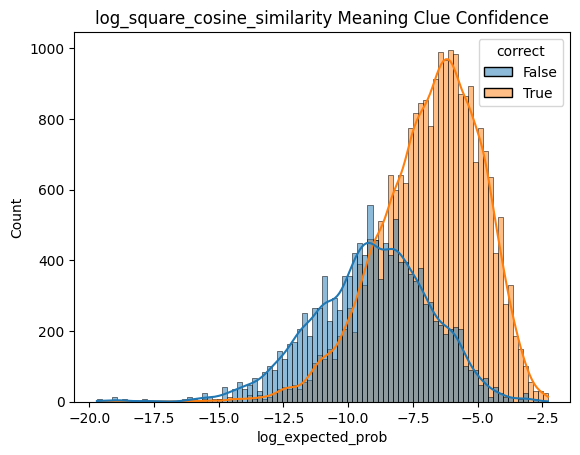

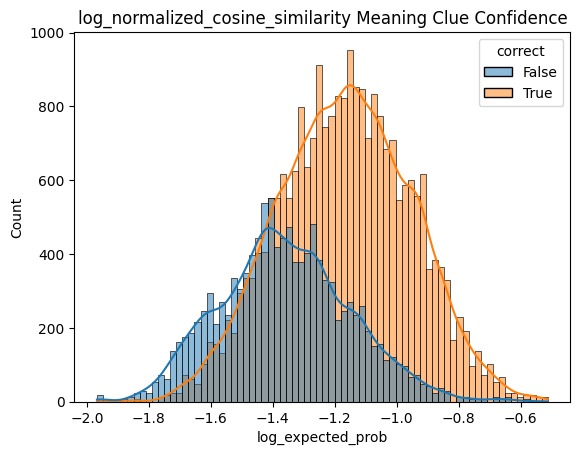

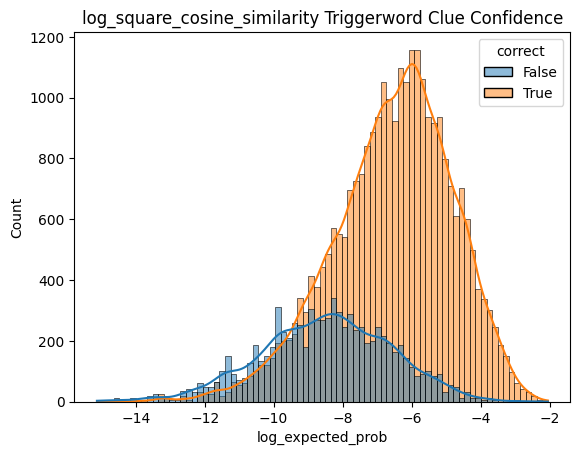

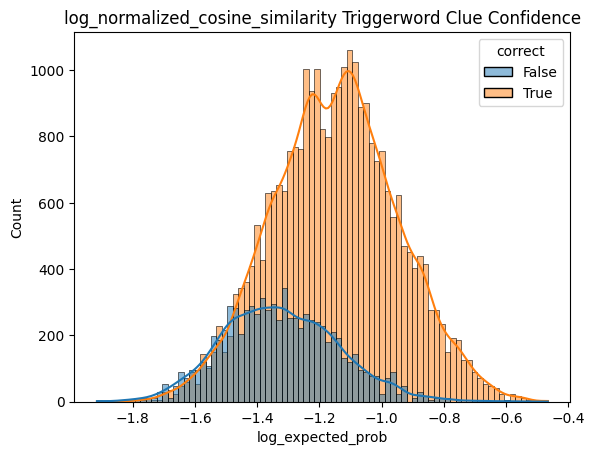

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for suite in suites:
    for strat_func, meaning_guesses_df in guesses_by_suitename_and_strat[suite.name].items():
        _, ax = plt.subplots()
        plot = sns.histplot(ax=ax, data=meaning_guesses_df, x="log_expected_prob", hue="correct", kde=True)
        plot.set(title=f'{strat_func.__name__} {suite.name.capitalize()} Clue Confidence')


Fortunately, we observe that the guessers don't have a false sense of confidence. They assign their incorrect guesses significantly lower probabilities than they assign their correct guesses.

The distributions are also not showing erratic behavior or an obvious pitfall, implying the guessing is working how we expect.

In [ ]:

guessed_wrong_by_suitename_and_strat = defaultdict(dict)
for suite in suites:
    for strat_func, guesses_df in guesses_by_suitename_and_strat[suite.name].items():
        wrong_guesses = guesses_df["correct"] == False
        guessed_wrong = suite.clue_df[wrong_guesses]
        guessed_wrong["guessed_code_index"] = guesses_df["code_index_guess"][wrong_guesses]
        guessed_wrong["correct_code_index"] = suite.correct_code_index[wrong_guesses]
        guessed_wrong_by_suitename_and_strat[suite.name][strat_func] = guessed_wrong

guessed_wrong_by_suitename_and_strat["meaning"][log_square_cosine_similarity].head()


/var/folders/5r/fmvyqtcd33111tp2chr8wmy40000gn/T/ipykernel_83908/1254270730.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guessed_wrong["guessed_code_index"] = guesses_df["code_index_guess"][wrong_guesses]
/var/folders/5r/fmvyqtcd33111tp2chr8wmy40000gn/T/ipykernel_83908/1254270730.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guessed_wrong["correct_code_index"] = suite.correct_code_index[wrong_guesses]
/var/folders/5r/fmvyqtcd33111tp2chr8wmy40000gn/T/ipykernel_83908/1254270730.py:6: SettingWithC

keyword1 keyword2 keyword3 keyword4     clue1         clue2         clue3  \
0  BUTTERFLY  PLUMBER     FOOT    BLOOD  throttle  electricians           leg   
1  BUTTERFLY  PLUMBER     FOOT    BLOOD  throttle  electricians      ancestry   
2  BUTTERFLY  PLUMBER     FOOT    BLOOD  throttle           leg  electricians   
3  BUTTERFLY  PLUMBER     FOOT    BLOOD  throttle           leg      ancestry   
4  BUTTERFLY  PLUMBER     FOOT    BLOOD  throttle      ancestry  electricians   

   guessed_code_index  correct_code_index  
0                14.0                   0  
1                15.0                   1  
2                12.0                   2  
3                13.0                   3  
4                17.0                   4

We see that some of the mistakes the guessers are making are reasonable. A guesser guessed that "butterfly" and "leg" went together more well than "butterfly" and "throttle". In the context of the first guess, it might make sense to say "foot" goes with "throttle" and "butterfly" goes with "leg" just as much as the other way around.

There are 2 primary things to note. One is that the performance of our Guessers rely somewhat on the competence of the Encryptor. We observe that the Encryptor isn't taking into account that some of its choice words may make sense for multiple keywords and result in a conflict.

The other thing to note is that our Guesser may be having trouble with scale, as predicted. We see that it often sticks with a word that seems "most fit" without scaling how fit it is to how common the word is, or how commonly the words are used together. A different heuristic may help with this.

Let's try some of the other ideas I had. That is, scaling the probabilities by word frequency. We can use Zipf's law to approximate frequency. We might also consider a more intutive approach, where we realize that a guess will be harder to get the farther away from the keyword it is.

The Zipf implementation uses Baye's Theorem; we say P(clue | keyword) = (P(clue) / P(keyword)) * P(keyword | clue). To get the probailiities of the individual words, we use Zipf's law, and substitute 1/rank in the Google keyedvectors instance. This leaves us with (rank_keyword / rank_clue) * P(keyword | clue), where we might use one of our previous metrics to get the remaining probability. Let's see how our algorithm performs with these approaches.

As a sanity check, let's also include the Zipf scalings themselves. It should perform poorly because it doesn't compare any embeddings directly, and therefore can't give any information on word similarity apart from if they are similarly frequent. We should expect near random guesses at about 4.166% accuracy.

In [6]:
def cosine_distance(clue_index, keyword_index):
    return 1 - cosine_similarity(clue_index, keyword_index)

def log_zipf(clue_index, keyword_index):
    return np.log(keyword_index) - np.log(clue_index)

def log_outer_radius_proportion(clue_index, keyword_index):
    clue_distance = cosine_distance(clue_index, keyword_index)
    all_word_indices = np.arange(len(google_news_wv))
    all_distances = cosine_distance(np.expand_dims(all_word_indices, axis=-1), keyword_index).swapaxes(-1, -2)
    num_outside =  (all_distances > clue_distance).sum(axis=-1)
    return np.log(num_outside) - np.log(len(google_news_wv))

def log_zipf_scaled(clue_index, keyword_index):
    return log_zipf(clue_index, keyword_index) + log_square_cosine_similarity(clue_index, keyword_index)

def log_outer_radius_proportion_scaled(clue_index, keyword_index):
    return log_outer_radius_proportion(clue_index, keyword_index) + log_square_cosine_similarity(clue_index, keyword_index)

In [8]:
def get_guess(strat_func, input_row):
    keyword_card = (input_row.keyword1, input_row.keyword2, input_row.keyword3, input_row.keyword4)
    clues = (input_row.clue1, input_row.clue2, input_row.clue3)
    wv_kw_card = map(wv_loader.official_keyword_to_word, keyword_card)
    random_vars = nguesser.guesser_random_variables(wv_kw_card, google_news_wv.key_to_index)
    code_log_probabilities = nguesser.log_expected_probabilities_codes(strat_func, random_vars, nguesser.np_clues(clues, google_news_wv.key_to_index))
    raise KeyError(code_log_probabilities)
    code_index_guess = np.argmax(code_log_probabilities)
    return pandas.Series([code_index_guess, code_log_probabilities[code_index_guess]], index=["code_index_guess", "log_expected_prob"])

print(get_guess(log_outer_radius_proportion, meaning_df.iloc[5]))

strat_funcs = [log_outer_radius_proportion, log_zipf, log_zipf_scaled, log_outer_radius_proportion_scaled]
for strat_func in strat_funcs:
    print(strat_func.__name__)
    get_guess_with_strat = partial(get_guess, strat_func)

    for suite in suites:
        guesses = suite.clue_df.swifter.apply(get_guess_with_strat, axis=1)
        guesses["correct"] = guesses["code_index_guess"] == suite.correct_code_index
        percent_correct = 100 * np.sum(guesses["correct"]) / len(guesses)
        print(f"percent {suite.name} clues correct: {percent_correct:.2f}%")
        guesses_by_suitename_and_strat[suite.name][strat_func] = guesses

[[[-9.12610014e-01 -3.96842391e-01 -6.11947843e-02]
  [-1.06963132e+00 -2.40900273e-01 -5.85935380e-01]
  [-4.15670637e-02 -8.34468285e-02 -2.05021015e-04]
  [-9.78631669e-01 -9.00542742e-03 -3.40895004e-02]]

 [[-9.12610014e-01 -3.96842391e-01 -6.11947843e-02]
  [-1.06963132e+00 -2.40900273e-01 -5.85935380e-01]
  [-4.15670637e-02 -8.34468285e-02 -2.05021015e-04]
  [-9.78631669e-01 -9.00542742e-03 -3.40895004e-02]]

 [[-9.12610014e-01 -3.96842391e-01 -6.11947843e-02]
  [-1.06963132e+00 -2.40900273e-01 -5.85935380e-01]
  [-4.15670637e-02 -8.34468285e-02 -2.05021015e-04]
  [-9.78631669e-01 -9.00542742e-03 -3.40895004e-02]]

 [[-9.12610014e-01 -3.96842391e-01 -6.11947843e-02]
  [-1.06963132e+00 -2.40900273e-01 -5.85935380e-01]
  [-4.15670637e-02 -8.34468285e-02 -2.05021015e-04]
  [-9.78631669e-01 -9.00542742e-03 -3.40895004e-02]]]
[[-6.11947843e-02 -2.40900273e-01 -2.05021015e-04 -9.00542742e-03]
 [-6.11947843e-02 -2.40900273e-01 -2.05021015e-04 -9.00542742e-03]
 [-6.11947843e-02 -2.40900

KeyError: array([2.2799936, 2.2799936, 2.2799936, 2.2799936, 2.2799936, 2.2799936,
       2.2799936, 2.2799936, 2.2799936, 2.2799936, 2.2799936, 2.2799936,
       2.2799936, 2.2799936, 2.2799936, 2.2799936, 2.2799936, 2.2799936,
       2.2799936, 2.2799936, 2.2799936, 2.2799936, 2.2799936, 2.2799936])